In [ ]:
#import necessary libraries
! pip install pmdarima
! pip install prophet
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import random
import re
import sklearn
import string
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import pmdarima as pmd
from prophet import Prophet
# Disable scientific notation for display
pd.set_option('display.float_format', lambda x: '%.3f' % x)


# Set the random seed for reproducibility
RAND_SEED = 42
random.seed(RAND_SEED)
np.random.seed(RAND_SEED)
tf.random.set_seed(RAND_SEED)

In [ ]:
%matplotlib inline

import warnings

warnings.filterwarnings("ignore")

import os
import time
import random
import pickle
from tqdm.auto import tqdm
from datetime import datetime
from itertools import product
import torch
from torch import nn
from typing import List, Tuple, Dict, Optional
from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt

! pip install darts
import darts
from darts import TimeSeries
from darts.utils.losses import SmapeLoss
from darts.dataprocessing.transformers import Scaler
from darts.metrics import smape
from darts.utils.utils import SeasonalityMode, TrendMode, ModelMode
from darts.models import *
from darts.models import NBEATSModel
import logging


# Data Cleaning

In [ ]:
# Running this code will query a table in BigQuery and download
# the results to a Pandas DataFrame named `results`.
# Learn more here: https://cloud.google.com/bigquery/docs/visualize-jupyter

%%bigquery df --project vabble-qa
SELECT * FROM `vabble-qa.vabble_dataset_qa.bill_of_lading_history` #this table name was set based on the table you chose to query

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
# You can view the resulting Pandas DataFrame and work with using the Pandas library.
# https://pandas.pydata.org/docs/getting_started/index.html#getting-started
df

,Run_Date,Master_BOL,House_BOL,Voyage__,Bill_Type,Carrier_Code,IMO__,Vessel_Name,Arrival_Date,US_Port_of_Unlading,...,_100_Container_Consignee,Consignee,Consignee_Address,Notify_Party,Notify_Party_Address,Commodity,Number_of_Containers,Marks___Numbers,Container_Numbers,Seal_Numbers
0,2019-10-21,HLCUJK1190836087,MLCWSINH10007611,1934,House Bill,MLCW,9480186,MSC BARCELONA,2019-10-20,"HOUSTON, TEXAS",...,<NA>,PROSERV OPERATIONS LLC,15151 SOMMERMEYER ST HOUSTON TX HOUSTON TX 770...,PENTAGON FREIGHT SERVICES INC,1211 E RICHEY ROAD HOUSTON TX 77073 US 2812098800,PRESSURE TEST BARRIERS,2,PT PROSERV,TCLU5998395|TCNU8093068,HLB6697871|HLB6697872
1,2019-03-09,HLCUJK1181239511,MLCWSINH10006901,906N,House Bill,MLCW,9635688,MONTE CERVANTES,2019-03-08,"HOUSTON, TEXAS",...,<NA>,HALLIBURTON ENERGY SERVICES INC,131 CLENDENNING ROAD HOUMA LA HOUMA LA 70363 U...,None,None,OILWELL EQUIPMENT,1,HALLIBURTON ENERGY SERVICES,CAIU6676226,DOCUMENTAL|HLB4616544
2,2019-03-06,HLCUJK1181221770,MLCWSINH10006866,1904N,House Bill,MLCW,9307279,JPO SCORPIUS,2019-03-05,"HOUSTON, TEXAS",...,<NA>,HALLIBURTON ENERGY SERVICES INC,CASING EQUIPMENT COE 14524 HEATHROW FORREST PK...,None,None,OILWELL EQUIPMENT,1,HALLIBURTON ENERGY SERVICES|HALLIBURTON ENERGY...,HLBU1623360,HLB4615216
3,2023-09-23,SEAU229188768,MIQOMIQSCL017345,335N,House Bill,MIQO,9215880,MAERSK NEWHAVEN,2023-09-19,"LOS ANGELES, CALIFORNIA",...,<NA>,METSO OUTOTEC USA INC,20965 CROSSROADS CIR WAUKESHA WI 53186 US,None,None,MACHINERY PARTS,9,AS ADDRESSED,MRSU5871900|MRSU5995732|MRKU3342947|MRSU423157...,ML-CL0171039|ML-CL0171068|ML-CL0147346|ML-CL01...
4,2023-09-23,SEAU229455993,MIQOMIQSCL017430,331N,House Bill,MIQO,9215880,POLAR COLOMBIA,2023-09-19,"LOS ANGELES, CALIFORNIA",...,<NA>,METSO OUTOTEC USA INC,20965 CROSSROADS CIR WAUKESHA WI 53186 US,None,None,MACHINERY PARTS,1,AS ADDRESSED,TLLU2296876,ML-CL0171047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160347,2023-12-07,HLCUSYD230810229,None,2347S,Master BOL w/in-bond,HLCU,9320398,MSC LAUSANNE,2023-12-06,"HOUSTON, TEXAS",...,<NA>,DHL GLOBAL FORWARDING,11601 WEST TOUHY AVENUE BUILDING 895 CHICAGO I...,DHL GLOBAL FORWARDING,11601 WEST TOUHY AVENUE BUILDING 895 CHICAGO I...,MEDICAL SUPPLIES,2,BAXTER,HLBU9944990|TCLU1172379,A549273|A349274|A549274
160348,2023-12-07,HLCUSYD230810230,None,2347S,Master BOL w/in-bond,HLCU,9320398,MSC LAUSANNE,2023-12-06,"HOUSTON, TEXAS",...,<NA>,DHL GLOBAL FORWARDING,11601 WEST TOUHY AVENUE BUILDING 895 CHICAGO I...,DHL GLOBAL FORWARDING,11601 WEST TOUHY AVENUE BUILDING 895 CHICAGO I...,MEDICAL SUPPLIES,2,BAXTER,HLBU9759121|HLBU9685013,A549381|A549382
160349,2023-12-07,HLCUSYD230810240,None,2347S,Master BOL w/in-bond,HLCU,9320398,MSC LAUSANNE,2023-12-06,"HOUSTON, TEXAS",...,<NA>,DHL GLOBAL FORWARDING,11601 WEST TOUHY AVENUE BUILDING 895 CHICAGO I...,DHL GLOBAL FORWARDING,11601 WEST TOUHY AVENUE BUILDING 895 CHICAGO I...,MEDICAL SUPPLIES,2,BAXTER,HLBU9407521|HLBU9496998,A549239|A549383
160350,2024-01-08,HLCUSJ2231204569,None,2352S,Master BOL w/in-bond,HLCU,9719874,CAPE PIONEER,2024-01-06,"HOUSTON, TEXAS",...,<NA>,MAINFREIGHT INC.,11150 BELTLINE ROAD HOUSTON TX 77067 +1 281 84...,MAINFREIGHT INC.,11150 BELTLINE ROAD HOUSTON TX 77067 +1 281 84...,BEEF LIVER -41 BOX FROZEN BEEF SHORT INTESTINE...,1,NO MARKS|.,HLBU9253730,HLG4250638


## Handle missing values, outliers

In [ ]:
# Check for duplicated rows
duplicates = df.duplicated().sum()
print(f"Number of duplicated rows in the dataset: {duplicates}")
# Drop all duplicated rows
df = df.drop_duplicates()

In [ ]:
# now drop columns when it has more than 30% of missing values
# Define a threshold for the percentage of missing values
threshold = 0.3  # can adjust this

# Calculate the percentage of missing values for each column
missing_percentage = df.isnull().mean()

# Filter columns that have missing values greater than the threshold
columns_to_drop = missing_percentage[missing_percentage > threshold].index

# Drop the columns
df = df.drop(columns=columns_to_drop)

# Display the columns that were dropped and the cleaned data shape
print(f"Columns dropped due to missing values > {threshold*100}%:")
print(columns_to_drop)

Columns dropped due to missing values > 30.0%:
Index(['House_BOL', 'US_Port_of_Destination', 'Foreign_Port_of_Destination',
       '_100_Container_Consignee'],
      dtype='object')


In [ ]:
# Drop rows where 'Shipper' or 'Consignee' or 'Commodity' is empty
df = df.dropna(subset=['Shipper', 'Consignee', 'Commodity'])

# Drop unnecessary columns
columns_to_drop = ['Marks___Numbers','Notify_Party', 'Notify_Party_Address', 'Number_of_Containers', 'Container_Numbers', 'Seal_Numbers']
df = df.drop(columns=columns_to_drop)

In [ ]:
# Define the function to drop rows with empty containers
def drop_rows_with_keywords(dataframe, column_name, keywords):
    pattern = '|'.join(keywords)
    return dataframe[~dataframe[column_name].str.contains(pattern, case=False, na=False)]

# Keywords to drop
keywords_to_drop = ["contendor vacio", "contenedores vacios",'EMPTY CONTAINER','EMPTY CONTAINERS']

# Drop the rows
df = drop_rows_with_keywords(df, 'Commodity', keywords_to_drop)

In [ ]:
# Outliers detections
# Calculate mean and standard deviation
mean_weight = df['Weight__kg_'].mean()
std_weight = df['Weight__kg_'].std()

# Determine outlier thresholds
lower_bound = mean_weight - 3 * std_weight
upper_bound = mean_weight + 3 * std_weight

# Identify outliers
outliers = df[(df['Weight__kg_'] < lower_bound) | (df['Weight__kg_'] > upper_bound)]

# Display the number of rows that contain outliers
print("Number of rows that contain outliers in Weight__kg_ column:", outliers.shape[0])

# Drop outliers from the dataset
df = df[~((df['Weight__kg_'] < lower_bound) | (df['Weight__kg_'] > upper_bound))]


Number of rows that contain outliers in Weight__kg_ column: 44


In [ ]:
print("\nShape of the cleaned dataset:", df.shape)

# Save the cleaned dataset to a new CSV file
cleaned_file_path = 'cleaned.csv'
df.to_csv(cleaned_file_path, index=False)
print(f"Cleaned dataset saved to {cleaned_file_path}")


Shape of the cleaned dataset: (144863, 18)
Cleaned dataset saved to cleaned.csv


## Cleaning 'Commodity' column using LLM




In [ ]:
file_path = 'cleaned.csv'
data = pd.read_csv(file_path)
data.shape

(144863, 18)

In [ ]:
! pip install openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.5/325.5 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 13.4 MB/s eta 0:00:00


In [ ]:
import openai
import os

client = openai.OpenAI(api_key='')
# here I delete my personal API key


def extract_main_commodity(text):
    # Call OpenAI GPT-4 API to extract main commodity
    response = client.chat.completions.create(
        model= "gpt-4o",
        messages=[
            {"role": "system", "content": "You are a good reader."},
            {"role": "user", "content": f"Extract the commodity name from the following text: {text}. Output the name only in small letters. If the original language is not in English, output the name in English."}
        ],
        max_tokens=50,
        temperature=0,
    )

    main_commodity = response.choices[0].message.content.strip()
    return main_commodity

# Example commodity descriptions
commodity_descriptions = [
    "ORGANIC CHIA GRAINS FROM PARAGUAY PACKED IN BIG BAG WITH(1000 KG)LOAD DESTINATION: SEATTLE EE.UULOT: PY-CHB-O-NI-672021NET W: 20.000 KG .GROSS W: 20.270 KG.NCM: 12079990TOTAL BAGS: 20 BAGSPO: 507.24",
    "FROZEN BLUEBERRIES, ORGANIC, 500KG PACKETS, SHIPPED FROM CHILE TO SAN FRANCISCO. TOTAL WEIGHT 10,000 KG",
    "INDUSTRIAL MACHINE PARTS FOR AUTOMOTIVE MANUFACTURING, ORIGIN: GERMANY, DESTINATION: DETROIT",
    "CLOTHING ITEMS: T-SHIRTS, JEANS, AND JACKETS, TOTAL 1500 PIECES, FROM VIETNAM TO NEW YORK",
    "MEDICAL EQUIPMENT INCLUDING X-RAY MACHINES AND MRI SCANNERS, TOTAL WEIGHT 2000 KG, FROM JAPAN TO LOS ANGELES"
]

# Extract main commodities for each description
for description in commodity_descriptions:
    main_commodity = extract_main_commodity(description)
    print(f"Original: {description}")
    print(f"Main Commodity: {main_commodity}\n")

Original: ORGANIC CHIA GRAINS FROM PARAGUAY PACKED IN BIG BAG WITH(1000 KG)LOAD DESTINATION: SEATTLE EE.UULOT: PY-CHB-O-NI-672021NET W: 20.000 KG .GROSS W: 20.270 KG.NCM: 12079990TOTAL BAGS: 20 BAGSPO: 507.24
Main Commodity: organic chia grains

Original: FROZEN BLUEBERRIES, ORGANIC, 500KG PACKETS, SHIPPED FROM CHILE TO SAN FRANCISCO. TOTAL WEIGHT 10,000 KG
Main Commodity: frozen blueberries

Original: INDUSTRIAL MACHINE PARTS FOR AUTOMOTIVE MANUFACTURING, ORIGIN: GERMANY, DESTINATION: DETROIT
Main Commodity: industrial machine parts

Original: CLOTHING ITEMS: T-SHIRTS, JEANS, AND JACKETS, TOTAL 1500 PIECES, FROM VIETNAM TO NEW YORK
Main Commodity: clothing items

Original: MEDICAL EQUIPMENT INCLUDING X-RAY MACHINES AND MRI SCANNERS, TOTAL WEIGHT 2000 KG, FROM JAPAN TO LOS ANGELES
Main Commodity: medical equipment



In [ ]:
# Determine the size of each part
total_rows = len(data)
part_size = total_rows // 3

# Function to process and save part of the dataset
def process_part(data, start_idx, end_idx, part_number):
    part_data = data.iloc[start_idx:end_idx].copy()
    part_data['Commodity_cleaned'] = part_data['Commodity'].apply(extract_main_commodity)
    part_data.to_csv(f'processed_part_{part_number}.csv', index=False)
    print(f'Processed and saved part {part_number}')
       # Print the new column created
    print(part_data[['Commodity', 'Commodity_cleaned']].head())

# Process the first part
process_part(data, 0, part_size, 1)

Processed and saved part 1
                Commodity       Commodity_cleaned
0  PRESSURE TEST BARRIERS  pressure test barriers
1       OILWELL EQUIPMENT       oilwell equipment
2       OILWELL EQUIPMENT       oilwell equipment
3         MACHINERY PARTS         machinery parts
4         MACHINERY PARTS         machinery parts


In [ ]:
# Load the CSV file
file_path = 'processed_part_1.csv'
data = pd.read_csv(file_path)
data

,Run_Date,Master_BOL,Voyage__,Bill_Type,Carrier_Code,IMO__,Vessel_Name,Arrival_Date,US_Port_of_Unlading,Foreign_Port_of_Lading,Place_of_Receipt,Quantity,Weight__kg_,Shipper,Shipper_Address,Consignee,Consignee_Address,Commodity,Commodity_cleaned
0,2019-10-21,HLCUJK1190836087,1934,House Bill,MLCW,9480186.0,MSC BARCELONA,2019-10-20,"HOUSTON, TEXAS",ALL COLUMBIA AMAZON REGION PORTS,SIN,18 PKG,6900,PT PROSERV,JL. DUYUNG KAV III. BATU AMPAR BATAM ISLAND BA...,PROSERV OPERATIONS LLC,15151 SOMMERMEYER ST HOUSTON TX HOUSTON TX 770...,PRESSURE TEST BARRIERS,pressure test barriers
1,2019-03-09,HLCUJK1181239511,906N,House Bill,MLCW,9635688.0,MONTE CERVANTES,2019-03-08,"HOUSTON, TEXAS",ALL COLUMBIA AMAZON REGION PORTS,SIN,12 PKG,3013,PT HALLIBURTON INDONESIA,"JE RE.MARTADINATA,SEKUPA,24900 BATAM ISLAND BA...",HALLIBURTON ENERGY SERVICES INC,131 CLENDENNING ROAD HOUMA LA HOUMA LA 70363 U...,OILWELL EQUIPMENT,oilwell equipment
2,2019-03-06,HLCUJK1181221770,1904N,House Bill,MLCW,9307279.0,JPO SCORPIUS,2019-03-05,"HOUSTON, TEXAS",ALL COLUMBIA AMAZON REGION PORTS,SIN,5 PKG,1556,PT HALLIBURTON INDONESIA,"JE RE.MARTADINATA,SEKUPA,24900 BATAM ISLAND BA...",HALLIBURTON ENERGY SERVICES INC,CASING EQUIPMENT COE 14524 HEATHROW FORREST PK...,OILWELL EQUIPMENT,oilwell equipment
3,2023-09-23,SEAU229188768,335N,House Bill,MIQO,9215880.0,MAERSK NEWHAVEN,2023-09-19,"LOS ANGELES, CALIFORNIA",ALL COLUMBIA AMAZON REGION PORTS,BALBOA,74 PKG,90163,METSO OUTOTEC CHILE SPA,CAMINO INTERNACIONAL #5725-CON CON-CHILE VALPA...,METSO OUTOTEC USA INC,20965 CROSSROADS CIR WAUKESHA WI 53186 US,MACHINERY PARTS,machinery parts
4,2023-09-23,SEAU229455993,331N,House Bill,MIQO,9215880.0,POLAR COLOMBIA,2023-09-19,"LOS ANGELES, CALIFORNIA",ALL COLUMBIA AMAZON REGION PORTS,BALBOA,4 PKG,2009,METSO OUTOTEC CHILE SPA,CAMINO INTERNACIONAL #5725-CON CON-CHILE VALPA...,METSO OUTOTEC USA INC,20965 CROSSROADS CIR WAUKESHA WI 53186 US,MACHINERY PARTS,machinery parts
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48282,2022-01-03,SMLU6916109A,51,Regular Bill,SMLU,9395123.0,ARSOS,2022-01-02,"CHESTER, PENNSYLVANIA",PAITA PERU,PAITA,"1,926 BOX",17400,AGRICOLA LAS MARIAS SAC,"AV BENAVIDES 474 MIRAFLORES LIMA, PERU PER",AM FRESH NORTH AMERICA,711 N MAIN ST GLASSBORO NJ 08028 USA,BOXES FRESH GRAPES SWEET GLOBE (UVAS FRESCAS V...,grapes
48283,2021-12-31,SMLU6914739A,51,Regular Bill,SMLU,9395123.0,ARSOS,2021-12-30,"MIAMI, FLORIDA",PAITA PERU,PAITA,"2,800 BOX",14630,AGROEXPORTACIONES NATHANAEL SAC,"CLL VICTOR RAUL S N PAIJAN, PERU PER",ALTAR PRODUCE LLC,800 HAROLD AVE CALEXICO CA 92231 USA,BOXES FRESH GREEN ASPARAGUS TR JCT6N05ST0 JCT6...,fresh green asparagus
48284,2021-12-31,SMLU6914740A,51,Regular Bill,SMLU,9395123.0,ARSOS,2021-12-30,"MIAMI, FLORIDA",PAITA PERU,PAITA,"2,800 BOX",14630,AGROEXPORTACIONES NATHANAEL SAC,"CLL VICTOR RAUL S N PAIJAN, PERU PER",ALTAR PRODUCE LLC,800 HAROLD AVE CALEXICO CA 92231 USA,BOXES FRESH GREEN ASPARAGUS TR JCT6N05E70 JCT6...,fresh green asparagus
48285,2021-12-31,SMLU6916284A,51,Regular Bill,SMLU,9395123.0,ARSOS,2021-12-30,"MIAMI, FLORIDA",PAITA PERU,PAITA,"2,400 BOX",14000,AGRICOLA CERRO PRIETO SA,CALL DEAN VALDIVIA # 111 INT 1002 LIMA SAN ISI...,ALTAR PRODUCE LLC,800 HAROLD AVE CALEXICO CA 92231 USA,BOXES WITH FRESH ASPARAGUS 2400 CAJAS CON ESPA...,asparagus


In [ ]:
# Save the dataframe to a CSV file
data.to_csv('/part1.csv', index=False)

In [ ]:
data.shape

(48287, 19)

In [ ]:
# process the second part
# Determine the size of each part
total_rows = len(data)
part_size = total_rows // 3

def process_part(data, start_idx, end_idx, part_number):
    part_data = data.iloc[start_idx:end_idx].copy()
    part_data['Commodity_cleaned'] = part_data['Commodity'].apply(extract_main_commodity)
    part_data.to_csv(f'/part_{part_number}.csv', index=False)
    print(f'Processed and saved part {part_number}')
       # Print the new column created
    print(part_data[['Commodity', 'Commodity_cleaned']].head())

process_part(data, part_size, 2 * part_size, 2)

Processed and saved part 2
                                               Commodity Commodity_cleaned
48287  BOXES WITH ORGANIC FRESH GRAPES VARIETY ALLISO...            grapes
48288  BOXES WITH ORGANIC FRESH GRAPES VARIETY ALLISO...            grapes
48289  BOXES WITH ORGANIC FRESH GRAPES VARIETY ALLISO...            grapes
48290  BOXES WITH ORGANIC FRESH GRAPES VARIETY ALLISO...            grapes
48291  BOXES WITH ORGANIC FRESH GRAPES VARIETY ALLISO...            grapes


In [ ]:
file_path = '/part_2.csv'
data2 = pd.read_csv(file_path)
data2

,Run_Date,Master_BOL,Voyage__,Bill_Type,Carrier_Code,IMO__,Vessel_Name,Arrival_Date,US_Port_of_Unlading,Foreign_Port_of_Lading,Place_of_Receipt,Quantity,Weight__kg_,Shipper,Shipper_Address,Consignee,Consignee_Address,Commodity,Commodity_cleaned
0,2023-12-25,SMLU7875025A,114,Regular Bill,SMLU,9395123.0,ARSOS,2023-12-23,"CHESTER, PENNSYLVANIA",PAITA PERU,PAITA,"2,070 BOX",14500,ASICA FARMS SAC,"AV EL GOLF 681 URB PALMERAS DEL GOLF TRUJILLO,...",AWE SUM ORGANICS INC,123 LOCUST ST SANTA CRUZ CA 95060 USA,BOXES WITH ORGANIC FRESH GRAPES VARIETY ALLISO...,grapes
1,2023-12-25,SMLU7875029A,114,Regular Bill,SMLU,9395123.0,ARSOS,2023-12-23,"CHESTER, PENNSYLVANIA",PAITA PERU,PAITA,"1,900 BOX",14800,ASICA FARMS SAC,"AV EL GOLF 681 URB PALMERAS DEL GOLF TRUJILLO,...",AWE SUM ORGANICS INC,123 LOCUST ST SANTA CRUZ CA 95060 USA,BOXES WITH ORGANIC FRESH GRAPES VARIETY ALLISO...,grapes
2,2023-12-25,SMLU7875030A,114,Regular Bill,SMLU,9395123.0,ARSOS,2023-12-23,"CHESTER, PENNSYLVANIA",PAITA PERU,PAITA,"1,830 BOX",15200,ASICA FARMS SAC,"AV EL GOLF 681 URB PALMERAS DEL GOLF TRUJILLO,...",AWE SUM ORGANICS INC,123 LOCUST ST SANTA CRUZ CA 95060 USA,BOXES WITH ORGANIC FRESH GRAPES VARIETY ALLISO...,grapes
3,2023-12-25,SMLU7875031A,114,Regular Bill,SMLU,9395123.0,ARSOS,2023-12-23,"CHESTER, PENNSYLVANIA",PAITA PERU,PAITA,"2,230 BOX",15500,ASICA FARMS SAC,"AV EL GOLF 681 URB PALMERAS DEL GOLF TRUJILLO,...",AWE SUM ORGANICS INC,123 LOCUST ST SANTA CRUZ CA 95060 USA,BOXES WITH ORGANIC FRESH GRAPES VARIETY ALLISO...,grapes
4,2023-12-25,SMLU7875032A,114,Regular Bill,SMLU,9395123.0,ARSOS,2023-12-23,"CHESTER, PENNSYLVANIA",PAITA PERU,PAITA,"1,700 BOX",15500,ASICA FARMS SAC,"AV EL GOLF 681 URB PALMERAS DEL GOLF TRUJILLO,...",AWE SUM ORGANICS INC,123 LOCUST ST SANTA CRUZ CA 95060 USA,BOXES WITH ORGANIC FRESH GRAPES VARIETY ALLISO...,grapes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48282,2023-11-11,CMDUMXO0664918,0VBF8,Master FROB,CMDU,9225615.0,CMA CGM SAN FRANCISCO,2023-11-09,"HOUSTON, TEXAS",VERACRUZ MEXICO,VERACRUZ,"1,326 BOX",22732,TRANSLOGISTIC SA DE CV,"MORENA 228, 2P 202. COL DEL VALLE DELG BENITO ...",AUSTROMAR SPOL SRO,FRANTISKA DIVISE 988 104 00 PRAHA 10-UHRINEVES...,FREIGHT COLLECT 1326 BOXES CONTAINING CHILES J...,chiles jalapeños picados
48283,2023-11-11,CMDUMXO0665280,0VBF8,Master FROB,CMDU,9225615.0,CMA CGM SAN FRANCISCO,2023-11-09,"HOUSTON, TEXAS",VERACRUZ MEXICO,VERACRUZ,"1,193 CTN",9931,KUEHNE + NAGEL FORWARDING SA DE CV,"BLVD ADOLFO RUIZ CORTINES 3720 TORRE II, PISO ...",KUEHNE + NAGEL N.V.,BOOMPJES 40 3011 XB ROTTERDAM NETHERLANDS,FREIGHT PREPAID WITH MENS KNIT LEGGING WOMENS ...,mens knit legging womens knit legging boys kni...
48284,2023-11-11,CMDUMXO0665318,0VBF8,Master FROB,CMDU,9225615.0,CMA CGM SAN FRANCISCO,2023-11-09,"HOUSTON, TEXAS",ALTAMIRA MEXICO,TLAJOMULCO DE ZUN,10 PKG,3511,SCHENKER INTERNATIONAL SA DE CV,BERNARDO QUINTANA NO 300 PISO 6 COL CENTRO SUR...,SCHENKER KFT.,LESHEGY U. 30 2310 SZIGETSZENTMIKLOS HUNGARY,FREIGHT COLLECT 10 PK 847329 (HS) CONTAINING: ...,part for cash register
48285,2023-11-11,CMDUMXO0665416,0VBF8,Master FROB,CMDU,9225615.0,CMA CGM SAN FRANCISCO,2023-11-09,"HOUSTON, TEXAS",ALTAMIRA MEXICO,CIUDAD JUAREZ,48 PKG,79054,DHL GLOBAL FORWARDING (MEXICO) S.A.,DE C.V. AS AGENT FOR DANMAR LINES INSURGENTES ...,DHL GLOBAL FORWARDING (BELGIUM) NV SA,BURCHT SINGELBERG TROUBADOUR TOWER KETENISLAAN...,"870321 (HS) VEHICLE, FLAMMABLE LIQUID POWERED ...","vehicle, flammable liquid powered"


In [ ]:
# process the third part after the second:

# Determine the size of each part
total_rows = len(data)
part_size = total_rows // 3

# Function to process and save part of the dataset
def process_part(data, start_idx, end_idx, part_number):
    part_data = data.iloc[start_idx:end_idx].copy()
    part_data['Commodity_cleaned'] = part_data['Commodity'].apply(extract_main_commodity)
    part_data.to_csv(f'processed_part_{part_number}.csv', index=False)
    print(f'Processed and saved part {part_number}')
       # Print the new column created
    print(part_data[['Commodity', 'Commodity_cleaned']].head())

process_part(data, 2 * part_size, total_rows, 3)

Processed and saved part 3
                                               Commodity  \
96574  870192 (HS) 7200008608 FINISHED VEHICLE VEHICL...   
96575  870192 (HS) 7200008601 VEHICLE, FLAMMABLE LIQU...   
96576  FREIGHT PREPAID CARGO IS STOWED IN A REFRIGERA...   
96577  FREIGHT PREPAID KRAFT PAPER HS CODE 480421 TOT...   
96578  FREIGHT COLLECT HOSE DISCHARGE HOSE SUCTION HS...   

             Commodity_cleaned  
96574                  vehicle  
96575                  vehicle  
96576  pharmaceutical products  
96577              kraft paper  
96578                     hose  


In [ ]:
file_path = 'processed_part_3.csv'
data3 = pd.read_csv(file_path)
data3

,Run_Date,Master_BOL,Voyage__,Bill_Type,Carrier_Code,IMO__,Vessel_Name,Arrival_Date,US_Port_of_Unlading,Foreign_Port_of_Lading,Place_of_Receipt,Quantity,Weight__kg_,Shipper,Shipper_Address,Consignee,Consignee_Address,Commodity,Commodity_cleaned
0,2023-11-11,CMDUMXO0665421,0VBF8,Master FROB,CMDU,9225615.0,CMA CGM SAN FRANCISCO,2023-11-09,"HOUSTON, TEXAS",ALTAMIRA MEXICO,CIUDAD JUAREZ,80 PKG,70146,DHL GLOBAL FORWARDING (MEXICO) S.A.,DE C.V. AS AGENT FOR DANMAR LINES INSURGENTES ...,DHL GLOBAL FORWARDING (BELGIUM) NV SA,BURCHT SINGELBERG TROUBADOUR TOWER KETENISLAAN...,870192 (HS) 7200008608 FINISHED VEHICLE VEHICL...,vehicle
1,2023-11-11,CMDUMXO0665425,0VBF8,Master FROB,CMDU,9225615.0,CMA CGM SAN FRANCISCO,2023-11-09,"HOUSTON, TEXAS",ALTAMIRA MEXICO,CIUDAD JUAREZ,80 PKG,69344,DHL GLOBAL FORWARDING (MEXICO) S.A.,DE C.V. AS AGENT FOR DANMAR LINES INSURGENTES ...,DHL GLOBAL FORWARDING (BELGIUM) NV SA,BURCHT SINGELBERG TROUBADOUR TOWER KETENISLAAN...,"870192 (HS) 7200008601 VEHICLE, FLAMMABLE LIQU...",vehicle
2,2023-11-11,CMDUMXO0665512,0VBF8,Master FROB,CMDU,9225615.0,CMA CGM SAN FRANCISCO,2023-11-09,"HOUSTON, TEXAS",VERACRUZ MEXICO,MEXICO CITY,2 PKG,4754,DHL GLOBAL FORWARDING (MEXICO) S.A.,DE C.V. AS AGENT FOR DANMAR LINES INSURGENTES ...,DHL GLOBAL FORWARDING (NETHERLANDS) B.V.,RIDDERPOORT 37 RIDDERKERK 2984 BG NETHERLANDS,FREIGHT PREPAID CARGO IS STOWED IN A REFRIGERA...,pharmaceutical products
3,2023-11-11,CMDUMXO0665526,0VBF8,Master FROB,CMDU,9225615.0,CMA CGM SAN FRANCISCO,2023-11-09,"HOUSTON, TEXAS",VERACRUZ MEXICO,TUXTEPEC,80 ROL,57333,FMS LOGISTICS MEXICO S DE RL DE CV,"AV. SANTA FE NO. 170, OF. 2 3 04 COL. LOMAS DE...",FR. MEYER'S SOHN (GMBH CO.) KG,STATIONSPLEIN 4P NL-3331LL ZWIJNDRECHT DOCUMEN...,FREIGHT PREPAID KRAFT PAPER HS CODE 480421 TOT...,kraft paper
4,2023-11-11,CMDUMXO0665536,0VBF8,Master FROB,CMDU,9225615.0,CMA CGM SAN FRANCISCO,2023-11-09,"HOUSTON, TEXAS",ALTAMIRA MEXICO,ALTAMIRA,41 PKG,8044,IB SHIPPING S.A. DE C.V.,RENATO LEDUC 174-201 COL. TORIELLO GUERRA 1405...,"DELTA SHIPPING AND TRADING, S.R.O",V OLSINACH 2300 75 10000 PRAHA 10 CZECH REPUBLIC,FREIGHT COLLECT HOSE DISCHARGE HOSE SUCTION HS...,hose
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48284,2023-12-07,HLCUSS5231057477,2347S,Master BOL w/in-bond,HLCU,9320398.0,MSC LAUSANNE,2023-12-06,"HOUSTON, TEXAS",ALTAMIRA MEXICO,"SANTOS, BR","1,530 PCS",19156,LECEX SOLUCOES LOGISTICAS LTDA,"CNPJ 31.239.215 0001-93 RUA TREZE DE MAIO, 768...","ALL WAYS INTERNATIONAL SHIPPING & CHB, INC","6610 TRIBUTARY ST, SUITE 102 BALTIMORE, MD 21224",CLEAR BOPP FILM 01 CONTAINER 40HC WITH 1530 RO...,clear bopp film
48285,2023-12-07,HLCUSYD230810229,2347S,Master BOL w/in-bond,HLCU,9320398.0,MSC LAUSANNE,2023-12-06,"HOUSTON, TEXAS",ALTAMIRA MEXICO,"SYDNEY, NSW, AU","1,992 PCS",22112,DHL GLOBAL FORWARDING AUST PTY LTD,UNIT 1 BUILDING 1 MILLENNIUM COURT 33 41 MILIT...,DHL GLOBAL FORWARDING,11601 WEST TOUHY AVENUE BUILDING 895 CHICAGO I...,MEDICAL SUPPLIES,medical supplies
48286,2023-12-07,HLCUSYD230810230,2347S,Master BOL w/in-bond,HLCU,9320398.0,MSC LAUSANNE,2023-12-06,"HOUSTON, TEXAS",ALTAMIRA MEXICO,"SYDNEY, NSW, AU","2,400 PCS",26640,DHL GLOBAL FORWARDING AUST PTY LTD,UNIT 1 BUILDING 1 MILLENNIUM COURT 33 41 MILIT...,DHL GLOBAL FORWARDING,11601 WEST TOUHY AVENUE BUILDING 895 CHICAGO I...,MEDICAL SUPPLIES,medical supplies
48287,2023-12-07,HLCUSYD230810240,2347S,Master BOL w/in-bond,HLCU,9320398.0,MSC LAUSANNE,2023-12-06,"HOUSTON, TEXAS",ALTAMIRA MEXICO,"SYDNEY, NSW, AU","2,400 PCS",26662,DHL GLOBAL FORWARDING AUST PTY LTD,UNIT 1 BUILDING 1 MILLENNIUM COURT 33 41 MILIT...,DHL GLOBAL FORWARDING,11601 WEST TOUHY AVENUE BUILDING 895 CHICAGO I...,MEDICAL SUPPLIES,medical supplies


## Commodity categorisations

In [ ]:
! pip install openai
import openai
import os

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.5/325.5 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 11.7 MB/s eta 0:00:00


In [ ]:
client = openai.OpenAI(api_key='')
# again I delete my personal API key

# Define categories
categories = [
    "Furniture", "Electronics", "Home Appliances", "Machinery", "Chemicals", "Fruit", "Meat", "Dairy",
    "Vegetables", "Seafood", "Beverages", "Alcohol", "Snacks", "Textiles", "Metals",
    "Automotive Parts", "Agricultural Products", "Construction Materials", "Plastics",
    "Paper Products", "Pharmaceuticals", "Household Goods", "Toys", "Stationery", "Sports Equipment",
    "Cosmetics", "Footwear", "Jewelry", "Glassware", "Bags and Accessories", "Office Supplies",
    "Medical Equipment", "Pet Supplies", "Lubricants", "Tobacco",
     "Musical Instruments", "Books and Media", "Clothing"
]


def categorize_commodity(text):
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are a good reader."},
            {"role": "user", "content": f"Categorize the following commodity into one of these categories: {', '.join(categories)}.
            Output the category name only. If it doesn't fit any category, return 'others'. Commodity: {text}"}
        ],
        max_tokens=50,
        temperature=0.3,
    )

    category = response.choices[0].message.content.strip()
    return category


In [ ]:
# Example usage
commodity_descriptions = [
    "ORGANIC CHIA GRAINS FROM PARAGUAY PACKED IN BIG BAG WITH(1000 KG)LOAD DESTINATION: SEATTLE EE.UULOT: PY-CHB-O-NI-672021NET W: 20.000 KG .GROSS W: 20.270 KG.NCM: 12079990TOTAL BAGS: 20 BAGSPO: 507.24",
    "FROZEN BLUEBERRIES, ORGANIC, 500KG PACKETS, SHIPPED FROM CHILE TO SAN FRANCISCO. TOTAL WEIGHT 10,000 KG",
    "INDUSTRIAL MACHINE PARTS FOR AUTOMOTIVE MANUFACTURING, ORIGIN: GERMANY, DESTINATION: DETROIT",
    "CLOTHING ITEMS: T-SHIRTS, JEANS, AND JACKETS, TOTAL 1500 PIECES, FROM VIETNAM TO NEW YORK",
    "MEDICAL EQUIPMENT INCLUDING X-RAY MACHINES AND MRI SCANNERS, TOTAL WEIGHT 2000 KG, FROM JAPAN TO LOS ANGELES"
]

# Test the categorization function on the examples
for description in commodity_descriptions:
    category = categorize_commodity(description)
    print(f"Commodity: {description}")
    print(f"Category: {category}\n")

Commodity: ORGANIC CHIA GRAINS FROM PARAGUAY PACKED IN BIG BAG WITH(1000 KG)LOAD DESTINATION: SEATTLE EE.UULOT: PY-CHB-O-NI-672021NET W: 20.000 KG .GROSS W: 20.270 KG.NCM: 12079990TOTAL BAGS: 20 BAGSPO: 507.24
Category: Agricultural Products

Commodity: FROZEN BLUEBERRIES, ORGANIC, 500KG PACKETS, SHIPPED FROM CHILE TO SAN FRANCISCO. TOTAL WEIGHT 10,000 KG
Category: Fruit

Commodity: INDUSTRIAL MACHINE PARTS FOR AUTOMOTIVE MANUFACTURING, ORIGIN: GERMANY, DESTINATION: DETROIT
Category: Automotive Parts

Commodity: CLOTHING ITEMS: T-SHIRTS, JEANS, AND JACKETS, TOTAL 1500 PIECES, FROM VIETNAM TO NEW YORK
Category: Clothing

Commodity: MEDICAL EQUIPMENT INCLUDING X-RAY MACHINES AND MRI SCANNERS, TOTAL WEIGHT 2000 KG, FROM JAPAN TO LOS ANGELES
Category: Medical Equipment



In [ ]:
file_path = 'processed_part_1.csv'
data = pd.read_csv(file_path)
data.shape
data

# Apply the categorization function to the Commodity column
data['Category'] = data['Commodity_cleaned'].apply(categorize_commodity)

# Save the results to a new CSV file
data.to_csv('part1cat.csv', index=False)

# Print the new column created
print(data[['Commodity_cleaned', 'Category']].head())


In [ ]:
file_path = 'part_2.csv'
data = pd.read_csv(file_path)
data.shape
data

# Apply the categorization function to the Commodity column
data['Category'] = data['Commodity_cleaned'].apply(categorize_commodity)

# Save the results to a new CSV file
data.to_csv('part2cat.csv', index=False)

# Print the new column created
print(data[['Commodity_cleaned', 'Category']].head())

  Commodity_cleaned Category
0            grapes    Fruit
1            grapes    Fruit
2            grapes    Fruit
3            grapes    Fruit
4            grapes    Fruit


In [ ]:
file_path = 'processed_part_3.csv'
data = pd.read_csv(file_path)
data.shape
data

# Apply the categorization function to the Commodity column
data['Category'] = data['Commodity_cleaned'].apply(categorize_commodity)

# Save the results to a new CSV file
data.to_csv('part3cat.csv', index=False)

# Print the new column created
print(data[['Commodity_cleaned', 'Category']].head())

         Commodity_cleaned                Category
0                  vehicle        Automotive Parts
1                  vehicle        Automotive Parts
2  pharmaceutical products         Pharmaceuticals
3              kraft paper          Paper Products
4                     hose  Construction Materials


In [ ]:

# load separate dataframes
df1 = pd.read_csv('part1cat.csv')
df2 = pd.read_csv('part2cat.csv')
df3 = pd.read_csv('part3cat.csv')

# Concatenate the DataFrames
combined_df = pd.concat([df1, df2, df3])

# Display the combined DataFrame
combined_df.head()  # Display the first few rows of the combined DataFrame

# Save the combined DataFrame to a new CSV file
combined_df.to_csv('combined.csv', index=False)


,Run_Date,Master_BOL,Voyage__,Bill_Type,Carrier_Code,IMO__,Vessel_Name,Arrival_Date,US_Port_of_Unlading,Foreign_Port_of_Lading,Place_of_Receipt,Quantity,Weight__kg_,Shipper,Shipper_Address,Consignee,Consignee_Address,Commodity,Commodity_cleaned,Category
0,2019-10-21,HLCUJK1190836087,1934,House Bill,MLCW,9480186.0,MSC BARCELONA,2019-10-20,"HOUSTON, TEXAS",ALL COLUMBIA AMAZON REGION PORTS,SIN,18 PKG,6900,PT PROSERV,JL. DUYUNG KAV III. BATU AMPAR BATAM ISLAND BA...,PROSERV OPERATIONS LLC,15151 SOMMERMEYER ST HOUSTON TX HOUSTON TX 770...,PRESSURE TEST BARRIERS,pressure test barriers,Construction Materials
1,2019-03-09,HLCUJK1181239511,906N,House Bill,MLCW,9635688.0,MONTE CERVANTES,2019-03-08,"HOUSTON, TEXAS",ALL COLUMBIA AMAZON REGION PORTS,SIN,12 PKG,3013,PT HALLIBURTON INDONESIA,"JE RE.MARTADINATA,SEKUPA,24900 BATAM ISLAND BA...",HALLIBURTON ENERGY SERVICES INC,131 CLENDENNING ROAD HOUMA LA HOUMA LA 70363 U...,OILWELL EQUIPMENT,oilwell equipment,Machinery
2,2019-03-06,HLCUJK1181221770,1904N,House Bill,MLCW,9307279.0,JPO SCORPIUS,2019-03-05,"HOUSTON, TEXAS",ALL COLUMBIA AMAZON REGION PORTS,SIN,5 PKG,1556,PT HALLIBURTON INDONESIA,"JE RE.MARTADINATA,SEKUPA,24900 BATAM ISLAND BA...",HALLIBURTON ENERGY SERVICES INC,CASING EQUIPMENT COE 14524 HEATHROW FORREST PK...,OILWELL EQUIPMENT,oilwell equipment,Machinery
3,2023-09-23,SEAU229188768,335N,House Bill,MIQO,9215880.0,MAERSK NEWHAVEN,2023-09-19,"LOS ANGELES, CALIFORNIA",ALL COLUMBIA AMAZON REGION PORTS,BALBOA,74 PKG,90163,METSO OUTOTEC CHILE SPA,CAMINO INTERNACIONAL #5725-CON CON-CHILE VALPA...,METSO OUTOTEC USA INC,20965 CROSSROADS CIR WAUKESHA WI 53186 US,MACHINERY PARTS,machinery parts,Machinery
4,2023-09-23,SEAU229455993,331N,House Bill,MIQO,9215880.0,POLAR COLOMBIA,2023-09-19,"LOS ANGELES, CALIFORNIA",ALL COLUMBIA AMAZON REGION PORTS,BALBOA,4 PKG,2009,METSO OUTOTEC CHILE SPA,CAMINO INTERNACIONAL #5725-CON CON-CHILE VALPA...,METSO OUTOTEC USA INC,20965 CROSSROADS CIR WAUKESHA WI 53186 US,MACHINERY PARTS,machinery parts,Machinery


## Identify Country of Origins

In [ ]:
file_path = 'combined.csv'
data = pd.read_csv(file_path)
data.columns
data.shape
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
data.head(5)

Index(['Run_Date', 'Master_BOL', 'Voyage__', 'Bill_Type', 'Carrier_Code',
       'IMO__', 'Vessel_Name', 'Arrival_Date', 'US_Port_of_Unlading',
       'Foreign_Port_of_Lading', 'Place_of_Receipt', 'Quantity', 'Weight__kg_',
       'Shipper', 'Shipper_Address', 'Consignee', 'Consignee_Address',
       'Commodity', 'Commodity_cleaned', 'Category'],
      dtype='object')

(144863, 20)

,Run_Date,Master_BOL,Voyage__,Bill_Type,Carrier_Code,IMO__,Vessel_Name,Arrival_Date,US_Port_of_Unlading,Foreign_Port_of_Lading,Place_of_Receipt,Quantity,Weight__kg_,Shipper,Shipper_Address,Consignee,Consignee_Address,Commodity,Commodity_cleaned,Category
0,2019-10-21,HLCUJK1190836087,1934,House Bill,MLCW,9480186.0,MSC BARCELONA,2019-10-20,"HOUSTON, TEXAS",ALL COLUMBIA AMAZON REGION PORTS,SIN,18 PKG,6900,PT PROSERV,JL. DUYUNG KAV III. BATU AMPAR BATAM ISLAND BA...,PROSERV OPERATIONS LLC,15151 SOMMERMEYER ST HOUSTON TX HOUSTON TX 770...,PRESSURE TEST BARRIERS,pressure test barriers,Construction Materials
1,2019-03-09,HLCUJK1181239511,906N,House Bill,MLCW,9635688.0,MONTE CERVANTES,2019-03-08,"HOUSTON, TEXAS",ALL COLUMBIA AMAZON REGION PORTS,SIN,12 PKG,3013,PT HALLIBURTON INDONESIA,"JE RE.MARTADINATA,SEKUPA,24900 BATAM ISLAND BA...",HALLIBURTON ENERGY SERVICES INC,131 CLENDENNING ROAD HOUMA LA HOUMA LA 70363 U...,OILWELL EQUIPMENT,oilwell equipment,Machinery
2,2019-03-06,HLCUJK1181221770,1904N,House Bill,MLCW,9307279.0,JPO SCORPIUS,2019-03-05,"HOUSTON, TEXAS",ALL COLUMBIA AMAZON REGION PORTS,SIN,5 PKG,1556,PT HALLIBURTON INDONESIA,"JE RE.MARTADINATA,SEKUPA,24900 BATAM ISLAND BA...",HALLIBURTON ENERGY SERVICES INC,CASING EQUIPMENT COE 14524 HEATHROW FORREST PK...,OILWELL EQUIPMENT,oilwell equipment,Machinery
3,2023-09-23,SEAU229188768,335N,House Bill,MIQO,9215880.0,MAERSK NEWHAVEN,2023-09-19,"LOS ANGELES, CALIFORNIA",ALL COLUMBIA AMAZON REGION PORTS,BALBOA,74 PKG,90163,METSO OUTOTEC CHILE SPA,CAMINO INTERNACIONAL #5725-CON CON-CHILE VALPA...,METSO OUTOTEC USA INC,20965 CROSSROADS CIR WAUKESHA WI 53186 US,MACHINERY PARTS,machinery parts,Machinery
4,2023-09-23,SEAU229455993,331N,House Bill,MIQO,9215880.0,POLAR COLOMBIA,2023-09-19,"LOS ANGELES, CALIFORNIA",ALL COLUMBIA AMAZON REGION PORTS,BALBOA,4 PKG,2009,METSO OUTOTEC CHILE SPA,CAMINO INTERNACIONAL #5725-CON CON-CHILE VALPA...,METSO OUTOTEC USA INC,20965 CROSSROADS CIR WAUKESHA WI 53186 US,MACHINERY PARTS,machinery parts,Machinery


In [ ]:
# Dictionary of country patterns
country_patterns = {
    "USA": ["usa", "u.s.", "us", "united states", "america"],
    "Canada": ["canada", "can"],
    "Brazil": ["brazil", "brasil", "br"],
    "Colombia": ["colombia", "co"],
    "Argentina": ["argentina", "ar"],
    "Paraguay": ["paraguay", "py"],
    "Uruguay": ["uruguay", "uy"],
    "Mexico": ["mexico", "mx"],
    "Chile": ["chile", "cl"],
    "Peru": ["peru", "pe"],
    "Venezuela": ["venezuela", "ve"],
    "Honduras": ["honduras", "hn"],
    "Guatemala": ["guatemala", "gt"],
    "Ecuador": ["ecuador", "ec"],
    "Bolivia": ["bolivia", "bo"],
    "Panama": ["panama", "pa"],
    "Costa Rica": ["costa rica", "cr"],
    "Nicaragua": ["nicaragua", "ni"],
    "El Salvador": ["el salvador", "sv"],
    "Cuba": ["cuba", "cu"],
    "Haiti": ["haiti", "ht"],
    "Dominican Republic": ["dominican republic", "do"],
    "Puerto Rico": ["puerto rico", "pr"],
    "Trinidad and Tobago": ["trinidad and tobago", "tt"],
    # Add more countries and their ISO alpha-2 codes here
    "United Kingdom": ["united kingdom", "uk", "gb", "england", "scotland", "wales", "northern ireland"],
    "Germany": ["germany", "de"],
    "France": ["france", "fr"],
    "Italy": ["italy", "it"],
    "Spain": ["spain", "es"],
    "Netherlands": ["netherlands", "nl"],
    "Belgium": ["belgium", "be"],
    "Switzerland": ["switzerland", "ch"],
    "Austria": ["austria", "at"],
    "Sweden": ["sweden", "se"],
    "Norway": ["norway", "no"],
    "Denmark": ["denmark", "dk"],
    "Finland": ["finland", "fi"],
    "Ireland": ["ireland", "ie"],
    "Australia": ["australia", "au"],
    "New Zealand": ["new zealand", "nz"],
    "Japan": ["japan", "jp"],
    "China": ["china", "cn"],
    "India": ["india", "in"],
    "South Korea": ["south korea", "kr"],
    "Singapore": ["singapore", "sg"],
    "Russia": ["russia", "ru"],
    "South Africa": ["south africa", "za"],
    # Continue adding more countries as needed
}

# Function to extract the country from the consignee address
def extract_country(address, consignee):
    address = str(address).lower()
    consignee = str(consignee).lower()

    # Check address for country patterns
    for country, patterns in country_patterns.items():
        for pattern in patterns:
            if re.search(pattern, address):
                return country

    # Check consignee for country patterns if address is inconclusive
    for country, patterns in country_patterns.items():
        for pattern in patterns:
            if re.search(pattern, consignee):
                return country
    return "Unknown"


# Apply the function to extract country
data['Country_Consignee'] = data.apply(lambda row: extract_country(row['Consignee_Address'], row['Consignee']), axis=1)
data['Country_Shipper'] = data.apply(lambda row: extract_country(row['Shipper_Address'], row['Shipper']), axis=1)

# Count the number of "Unknown" values for consignee and shipper
unknown_count_consignee = data['Country_Consignee'].value_counts().get("Unknown", 0)
unknown_count_shipper = data['Country_Shipper'].value_counts().get("Unknown", 0)
print(f"Number of rows with 'Unknown' country of origin (consignee): {unknown_count_consignee}")
print(f"Number of rows with 'Unknown' country of origin (shipper): {unknown_count_shipper}")

# Drop rows where Country_of_Origin or Country_Shipper is "Unknown"
data_cleaned = data[(data['Country_Consignee'] != "Unknown") & (data['Country_Shipper'] != "Unknown")]

# Display the first 5 rows of the cleaned dataset
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
print(data_cleaned[['Consignee_Address', 'Country_Consignee', 'Shipper_Address',  'Country_Shipper']].head(5))


Number of rows with 'Unknown' country of origin (consignee): 39
Number of rows with 'Unknown' country of origin (shipper): 29
                                   Consignee_Address Country_Consignee  \
0  15151 SOMMERMEYER ST HOUSTON TX HOUSTON TX 770...               USA   
1  131 CLENDENNING ROAD HOUMA LA HOUMA LA 70363 U...               USA   
2  CASING EQUIPMENT COE 14524 HEATHROW FORREST PK...               USA   
3          20965 CROSSROADS CIR WAUKESHA WI 53186 US               USA   
4          20965 CROSSROADS CIR WAUKESHA WI 53186 US               USA   

                                     Shipper_Address Country_Shipper  
0  JL. DUYUNG KAV III. BATU AMPAR BATAM ISLAND BA...       Argentina  
1  JE RE.MARTADINATA,SEKUPA,24900 BATAM ISLAND BA...       Argentina  
2  JE RE.MARTADINATA,SEKUPA,24900 BATAM ISLAND BA...       Argentina  
3  CAMINO INTERNACIONAL #5725-CON CON-CHILE VALPA...        Colombia  
4  CAMINO INTERNACIONAL #5725-CON CON-CHILE VALPA...        Colombia  


In [ ]:
# Save the cleaned dataset to a new CSV file
data.to_csv("final.csv", index=False)

## further clean the 'Category' column

In [ ]:
file_path = 'final.csv'
data = pd.read_csv(file_path)
# Check for missing values
missing_values = data.isnull().sum()
missing_values


# Handling missing values
# For demonstration, we will fill missing IMO__ with 0 and other missing values with 'Unknown'

data['IMO__'] = data['IMO__'].fillna(0)
data['Shipper_Address'] = data['Shipper_Address'].fillna('Unknown')
data['Consignee_Address'] = data['Consignee_Address'].fillna('Unknown')
data['Commodity'] = data['Commodity'].fillna('Unknown')
data['Commodity_cleaned'] = data['Commodity_cleaned'].fillna('Unknown')

# Drop rows where 'Commodity_cleaned' is 'Unknown'
data = data[data['Commodity_cleaned'] != 'Unknown']

# Check if all missing values are handled
missing_values_after = data.isnull().sum()
missing_values_after


Run_Date                     0
Master_BOL                   0
Voyage__                     0
Bill_Type                    0
Carrier_Code                 0
IMO__                     3011
Vessel_Name                  0
Arrival_Date                 0
US_Port_of_Unlading          0
Foreign_Port_of_Lading       0
Place_of_Receipt             0
Quantity                     0
Weight__kg_                  0
Shipper                      0
Shipper_Address             11
Consignee                    0
Consignee_Address           49
Commodity                    6
Commodity_cleaned            1
Category                     0
Country_Consignee            0
Country_Shipper              0
dtype: int64

Run_Date                  0
Master_BOL                0
Voyage__                  0
Bill_Type                 0
Carrier_Code              0
IMO__                     0
Vessel_Name               0
Arrival_Date              0
US_Port_of_Unlading       0
Foreign_Port_of_Lading    0
Place_of_Receipt          0
Quantity                  0
Weight__kg_               0
Shipper                   0
Shipper_Address           0
Consignee                 0
Consignee_Address         0
Commodity                 0
Commodity_cleaned         0
Category                  0
Country_Consignee         0
Country_Shipper           0
dtype: int64

In [ ]:
# Find rows where the 'Category' column has more than 3 words
rows_with_more_than_three_words = data[data['Category'].str.split().str.len() > 3]

# Save these rows into a CSV file
file_path_more_than_three_words = 'rows_with_more_than_three_words.csv'
rows_with_more_than_three_words.to_csv(file_path_more_than_three_words, index=False)

# Output the file path for confirmation
print(f"File saved to: {file_path_more_than_three_words}")

# upon investigation, those rows are non-meaningful data, so we categorise them into 'others'
# Categorize rows with more than 3 words in the 'Category' column into 'Others'
data.loc[data['Category'].str.split().str.len() > 3, 'Category'] = 'Others'

# Verify the changes by printing unique categories
updated_categories = data['Category'].unique()
print(updated_categories)

File saved to: rows_with_more_than_three_words.csv
['Construction Materials' 'Machinery' 'Glassware' 'Chemicals' 'Textiles'
 'Automotive Parts' 'Furniture' 'Household Goods' 'Others'
 'Agricultural Products' 'Paper Products' 'Food' 'Beverages'
 'Medical Equipment' 'Electronics' 'Pet Supplies' 'Metals'
 'Pharmaceuticals' 'Meat' 'Seafood' 'Clothing' 'Plastics'
 'Bags and Accessories' 'Fruit' 'Snacks' 'Jewelry' 'Cosmetics' 'others'
 'Home Appliances' 'Tobacco' 'Dairy' 'Vegetables' 'Alcohol' 'Footwear'
 'Packaging' 'Tobacco - Tobacco' 'Musical Instruments'
 'Wood and Furniture' 'Sports Equipment' 'Office Supplies' 'Hardware'
 'Stationery' 'Beauty' 'Lubricants' 'Artworks' 'Books and Media' 'Leather'
 'Spices' 'Toys' 'Health Supplements' 'Baby Products' 'Canned Vegetables'
 'Packaging Materials' 'Personal Care' 'Toothpaste' 'Accessories'
 'Packaging - Others' 'Tools' 'Art and Crafts' 'Toiletries' 'Flower'
 'Healthcare Products' 'Commodity: Sofa' 'Safety Equipment'
 'Commodity: Laptop' 'Light

In [ ]:
# Get the count of rows in each category
category_counts = data['Category'].value_counts()

# Filter categories with less than 100 rows of data
categories_less_than_100 = category_counts[category_counts < 100]

# Convert to DataFrame for better readability
categories_less_than_100_df = categories_less_than_100.reset_index()
categories_less_than_100_df.columns = ['Category', 'Count']

print(categories_less_than_100_df)

                    Category  Count
0                    Tobacco     71
1                      Tools     71
2        Musical Instruments     48
3              Personal Care     42
4              Art and Media     32
5                    Leather     27
6                Accessories      8
7        Packaging Materials      8
8                 Condiments      7
9          Tobacco - Tobacco      7
10        Art & Collectibles      5
11          Safety Equipment      5
12                Toothpaste      5
13                  Hardware      5
14        Health Supplements      5
15        Packaging - Others      4
16      Art and Collectibles      3
17                Toiletries      3
18                  Lighting      3
19         Canned Vegetables      2
20           Wood and Timber      2
21                Home Decor      2
22                Fragrances      2
23                       Art      2
24                    Beauty      2
25               Kitchenware      2
26               Frozen Food

In [ ]:
import pandas as pd

# Define the refined category mappings
refined_category_mapping = {
    'Tobacco - Tobacco': 'Tobacco',
    'Tools': 'Tools and Hardware',
    'Hardware': 'Tools and Hardware',
    'Personal Care': 'Health and Beauty',
    'Toothpaste': 'Health and Beauty',
    'Health Supplements': 'Health and Beauty',
    'Healthcare':'Health and Beauty',
    'Beauty': 'Health and Beauty',
    'Beauty Products': 'Health and Beauty',
    'Fragrances': 'Health and Beauty',
    'Toiletries': 'Health and Beauty',
    'Art and Media': 'Art and Media',
    'Art & Media': 'Art and Media',
    'Art & Collectibles': 'Art and Media',
    'Art and Collectibles': 'Art and Media',
    'Artworks': 'Art and Media',
    'Art and Crafts': 'Art and Media',
    'Art and Craft': 'Art and Media',
    'Media':'Art and Media',
    'Art and Handicrafts': 'Art and Media',
    'Packaging Materials': 'Packaging',
    'Packaging - Others': 'Packaging',
    'Condiments': 'Other Food',
    'Canned Vegetables': 'Other Food',
    'Frozen Food': 'Other Food',
    'Frozen Fruit': 'Other Food',
    'Herbs': 'Other Food',
    'Frozen guacamole: Snacks': 'Other Food',
    'Wood and Timber': 'Furniture',
    'Wood and Furniture': 'Furniture',
    'Wood': 'Furniture',
    'Home Decor': 'Furniture',
    'Commodity: Sofa': 'Furniture',
    'Healthcare Products': 'Health and Beauty',
    'Medicinal Products': 'Health and Beauty',
    'Commodity: Laptop': 'Electronics',
    'Optical Components': 'Electronics',
    'Optical Instruments': 'Electronics',
    'Baby Supplies': 'Baby Products',
    'Appliances': 'Household Goods',
    'Kitchenware': 'Household Goods',
    'Kitchen Utensils': 'Household Goods',
    'household goods': 'Household Goods',
    'Safety Equipment': 'Safety Equipment',
    'Lighting': 'Lighting',
    'Flower': 'Others',
    'Groceries': 'Groceries',
    'Watches': 'Bags and Accessories',
    'Watches and Jewelry': 'Bags and Accessories',
    'Jewelry and Watches':'Bags and Accessories',
    'Jewelry':'Bags and Accessories',
    'Accessories':'Bags and Accessories',
    'Category: others': 'Others',
    'others': 'Others'
}

# Apply the refined mapping
data['Category'] = data['Category'].replace(refined_category_mapping)

# Get the count of rows in each category
category_counts = data['Category'].value_counts()

# Filter categories with less than 100 rows of data
categories_less_than_100 = category_counts[category_counts < 100]

# Convert to DataFrame for better readability
categories_less_than_100_df = categories_less_than_100.reset_index()
categories_less_than_100_df.columns = ['Category', 'Count']

print(categories_less_than_100_df)


               Category  Count
0               Tobacco     78
1    Tools and Hardware     76
2     Health and Beauty     63
3         Art and Media     49
4   Musical Instruments     48
5               Leather     27
6            Other Food     15
7      Safety Equipment      5
8              Lighting      3
9         Baby Products      2
10                  Art      2
11    Outdoor Equipment      1
12            Groceries      1
13     Chemicals\nFruit      1
14                 Oils      1


In [ ]:
# Get the count of rows in each category
category_counts = data['Category'].value_counts()

# Filter categories with less than 40 rows of data
categories_less_than_40 = category_counts[category_counts < 40].index.tolist()

# Categorize them into 'Others'
data.loc[data['Category'].isin(categories_less_than_40), 'Category'] = 'Others'

# Verify the changes and count unique categories
updated_refined_unique_categories = data['Category'].unique()
num_updated_refined_categories = len(updated_refined_unique_categories)

# Display the categories with their counts
refined_category_counts = data['Category'].value_counts().reset_index()
refined_category_counts.columns = ['Category', 'Count']

print(f"Updated unique categories: {num_updated_refined_categories}")
print(refined_category_counts)

Updated unique categories: 44
                  Category  Count
0                    Fruit  22036
1               Vegetables  18515
2         Automotive Parts  17419
3                Chemicals  10834
4                   Others  10167
5                Beverages   7074
6   Construction Materials   6437
7                 Clothing   5419
8                Machinery   4604
9                  Alcohol   4358
10                  Metals   4336
11   Agricultural Products   3823
12         Household Goods   3745
13         Home Appliances   3227
14             Electronics   2645
15                Plastics   2255
16               Glassware   1983
17                Textiles   1892
18                    Food   1710
19                    Meat   1679
20               Cosmetics   1628
21               Furniture   1180
22         Pharmaceuticals   1016
23                 Seafood   1003
24                  Snacks    856
25       Medical Equipment    840
26                   Dairy    630
27          Paper 

In [ ]:
# Save the cleaned dataset to a new CSV file
data.to_csv("finaldata.csv", index=False)

## Identify buyers from EU and USA

In [ ]:
file_path = 'finaldata.csv'
data = pd.read_csv(file_path)
data.head()

# Identify all unique countries in the Country_Consignee column
unique_countries = data['Country_Consignee'].unique()
unique_countries

# List of EU countries (as of 2024)
eu_countries = [
    'Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark', 'Estonia', 'Finland',
    'France', 'Germany', 'Greece', 'Hungary', 'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta',
    'Netherlands', 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Sweden','United Kingdom'
]

# Function to categorize countries into USA/EU or others
def categorize_country(country):
    if country == 'USA' & "Canada" or country in eu_countries:
        return 'USA/EU'
    else:
        return 'Others'

# Create a new column with the categorized countries
data['Consignee_Category'] = data['Country_Consignee'].apply(categorize_country)

# Display the first few rows to verify the new column
data[['Country_Consignee', 'Consignee_Category']].head()


,Run_Date,Master_BOL,Voyage__,Bill_Type,Carrier_Code,IMO__,Vessel_Name,Arrival_Date,US_Port_of_Unlading,Foreign_Port_of_Lading,...,Weight__kg_,Shipper,Shipper_Address,Consignee,Consignee_Address,Commodity,Commodity_cleaned,Category,Country_Consignee,Country_Shipper
0,2019-10-21,HLCUJK1190836087,1934,House Bill,MLCW,9480186.0,MSC BARCELONA,2019-10-20,"HOUSTON, TEXAS",ALL COLUMBIA AMAZON REGION PORTS,...,6900,PT PROSERV,JL. DUYUNG KAV III. BATU AMPAR BATAM ISLAND BA...,PROSERV OPERATIONS LLC,15151 SOMMERMEYER ST HOUSTON TX HOUSTON TX 770...,PRESSURE TEST BARRIERS,pressure test barriers,Construction Materials,USA,Argentina
1,2019-03-09,HLCUJK1181239511,906N,House Bill,MLCW,9635688.0,MONTE CERVANTES,2019-03-08,"HOUSTON, TEXAS",ALL COLUMBIA AMAZON REGION PORTS,...,3013,PT HALLIBURTON INDONESIA,"JE RE.MARTADINATA,SEKUPA,24900 BATAM ISLAND BA...",HALLIBURTON ENERGY SERVICES INC,131 CLENDENNING ROAD HOUMA LA HOUMA LA 70363 U...,OILWELL EQUIPMENT,oilwell equipment,Machinery,USA,Argentina
2,2019-03-06,HLCUJK1181221770,1904N,House Bill,MLCW,9307279.0,JPO SCORPIUS,2019-03-05,"HOUSTON, TEXAS",ALL COLUMBIA AMAZON REGION PORTS,...,1556,PT HALLIBURTON INDONESIA,"JE RE.MARTADINATA,SEKUPA,24900 BATAM ISLAND BA...",HALLIBURTON ENERGY SERVICES INC,CASING EQUIPMENT COE 14524 HEATHROW FORREST PK...,OILWELL EQUIPMENT,oilwell equipment,Machinery,USA,Argentina
3,2023-09-23,SEAU229188768,335N,House Bill,MIQO,9215880.0,MAERSK NEWHAVEN,2023-09-19,"LOS ANGELES, CALIFORNIA",ALL COLUMBIA AMAZON REGION PORTS,...,90163,METSO OUTOTEC CHILE SPA,CAMINO INTERNACIONAL #5725-CON CON-CHILE VALPA...,METSO OUTOTEC USA INC,20965 CROSSROADS CIR WAUKESHA WI 53186 US,MACHINERY PARTS,machinery parts,Machinery,USA,Colombia
4,2023-09-23,SEAU229455993,331N,House Bill,MIQO,9215880.0,POLAR COLOMBIA,2023-09-19,"LOS ANGELES, CALIFORNIA",ALL COLUMBIA AMAZON REGION PORTS,...,2009,METSO OUTOTEC CHILE SPA,CAMINO INTERNACIONAL #5725-CON CON-CHILE VALPA...,METSO OUTOTEC USA INC,20965 CROSSROADS CIR WAUKESHA WI 53186 US,MACHINERY PARTS,machinery parts,Machinery,USA,Colombia


array(['USA', 'Colombia', 'Venezuela', 'Nicaragua', 'Italy', 'Argentina',
       'Germany', 'Brazil', 'Uruguay', 'Russia', 'Sweden', 'Finland',
       'Peru', 'India', 'Canada', 'Honduras', 'Bolivia', 'Panama',
       'Austria', 'Spain', 'Cuba', 'Belgium', 'Dominican Republic',
       'Switzerland', 'Puerto Rico', 'Costa Rica', 'Chile', 'Ecuador',
       'Norway', 'Guatemala', 'Unknown', 'France', 'Ireland',
       'Trinidad and Tobago', 'Australia', 'Haiti', 'Netherlands',
       'El Salvador', 'United Kingdom', 'Denmark', 'Mexico',
       'South Africa', 'Paraguay', 'China', 'New Zealand', 'South Korea'],
      dtype=object)

,Country_Consignee,Consignee_Category
0,USA,USA/EU
1,USA,USA/EU
2,USA,USA/EU
3,USA,USA/EU
4,USA,USA/EU


In [ ]:
# Save the cleaned dataset to a new CSV file
data.to_csv("finaldata.csv", index=False)

# Modelling



### top 1 combination








In [ ]:
# Load the dataset
file_path = '/content/finaldata (1).csv'
data = pd.read_csv(file_path)

# Filter the data for consignees from the EU/USA
eu_usa_data = data[data['Consignee_Category'] == 'USA/EU']

# Find the combination of Shipper and Commodity_Category with the most data
top_combination = eu_usa_data.groupby(['Shipper', 'Category']).size().idxmax()
top_combination_data = eu_usa_data[(eu_usa_data['Shipper'] == top_combination[0]) & (eu_usa_data['Category'] == top_combination[1])]
top_combination


('CAMPOSOL SA', 'Fruit')

In [ ]:
# Print all unique shipper names that contain "CAMPOSOL"
unique_camp_shippers = eu_usa_data['Shipper'].unique()
camp_shippers = [name for name in unique_camp_shippers if 'CAMPOSOL' in name]
camp_shippers

# Filter the data for the specific variations and category 'Fruit'
camp_variations = [
    'CAMPOSOL SA',
    'CAMPOSOL S.A.',
    'CAMPOSOL S.A',
    'CAMPOSOL S.A AV. EL DERBY 250, PISO 4 URB. EL DERBY DE MONTERRICO SA'
]

# Filter data for the identified variations and category 'Fruit'
filtered_fruit_data = eu_usa_data[
    (eu_usa_data['Shipper'].isin(camp_variations)) &
    (eu_usa_data['Category'] == 'Fruit')
]

# Display the filtered data
filtered_fruit_data
filtered_fruit_data.describe(include='all')

# Count the number of data points for the selected combination
num_data_points = len(filtered_fruit_data)
num_data_points

['CAMPOSOL URUGUAY SRL',
 'CAMPOSOL URUGUAY S.R.L.',
 'CAMPOSOL SA',
 'CAMPOSOL S.A.',
 'CAMPOSOL S.A',
 'CAMPOSOL S.A AV. EL DERBY 250, PISO 4 URB. EL DERBY DE MONTERRICO SA']

,Run_Date,Master_BOL,Voyage__,Bill_Type,Carrier_Code,IMO__,Vessel_Name,Arrival_Date,US_Port_of_Unlading,Foreign_Port_of_Lading,...,Shipper,Shipper_Address,Consignee,Consignee_Address,Commodity,Commodity_cleaned,Category,Country_Consignee,Country_Shipper,Consignee_Category
15477,2024-02-05,SMLU7923978A,116,Regular Bill,SMLU,0.0,ARSOS,2024-02-03,"CHESTER, PENNSYLVANIA",PAITA PERU,...,CAMPOSOL SA,AV EL DERBY NRO 250 INT 401 URB EL DERBY (PISO...,CAMPOSOL FRESH USA INC,5555 ANGLERS AVE STE 10 FORT LAUDERDALE FL 333...,BOXES WITH FRESH MANGOES 5808 CAJAS CON MANGOS...,mangoes,Fruit,USA,Colombia,USA/EU
15478,2024-02-05,SMLU7923977A,116,Regular Bill,SMLU,0.0,ARSOS,2024-02-03,"CHESTER, PENNSYLVANIA",PAITA PERU,...,CAMPOSOL SA,AV EL DERBY NRO 250 INT 401 URB EL DERBY (PISO...,CAMPOSOL FRESH USA INC,5555 ANGLERS AVE STE 10 FORT LAUDERDALE FL 333...,BOXES WITH FRESH MANGOES 5600 CAJAS CON MANGO ...,mangoes,Fruit,USA,Colombia,USA/EU
15479,2024-02-05,SMLU7923979A,116,Regular Bill,SMLU,0.0,ARSOS,2024-02-03,"CHESTER, PENNSYLVANIA",PAITA PERU,...,CAMPOSOL SA,AV EL DERBY NRO 250 INT 401 URB EL DERBY (PISO...,CAMPOSOL FRESH USA INC,5555 ANGLERS AVE STE 10 FORT LAUDERDALE FL 333...,BOXES WITH FRESH MANGOES 5700 CAJAS CON MANGOS...,mangoes,Fruit,USA,Colombia,USA/EU
15480,2024-02-05,SMLU7923980A,116,Regular Bill,SMLU,0.0,ARSOS,2024-02-03,"CHESTER, PENNSYLVANIA",PAITA PERU,...,CAMPOSOL SA,AV EL DERBY NRO 250 INT 401 URB EL DERBY (PISO...,CAMPOSOL FRESH USA INC,5555 ANGLERS AVE STE 10 FORT LAUDERDALE FL 333...,BOXES WITH FRESH MANGOES 5030 CAJAS CON MANGOS...,mangoes,Fruit,USA,Colombia,USA/EU
15481,2024-02-05,SMLU7927354A,116,Regular Bill,SMLU,0.0,ARSOS,2024-02-03,"CHESTER, PENNSYLVANIA",PAITA PERU,...,CAMPOSOL SA,AV EL DERBY NRO 250 INT 401 URB EL DERBY (PISO...,CAMPOSOL FRESH USA INC,5555 ANGLERS AVE STE 10 FORT LAUDERDALE FL 333...,BOXES WITH FRESH MANGOES 5600 CAJAS CON MANGOS...,mangoes,Fruit,USA,Colombia,USA/EU
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50145,2021-01-19,SMLU6424123A,40,Regular Bill,SMLU,9395123.0,ARSOS,2021-01-18,"CHESTER, PENNSYLVANIA",PAITA PERU,...,CAMPOSOL SA,"AV EL DERBY #250 SANTIAGO DE SURCO LIMA, PERU PER",CAMPOSOL FRESH USA INC,5555 ANGLERS AVE STE 20 FORT LAUDERDALE FL 333...,BOXES WITH FRESH BLUEBERRIES 3902 CAJAS CON AR...,blueberries,Fruit,USA,Colombia,USA/EU
50146,2021-01-19,SMLU6427890A,40,Regular Bill,SMLU,9395123.0,ARSOS,2021-01-18,"CHESTER, PENNSYLVANIA",PAITA PERU,...,CAMPOSOL SA,"AV EL DERBY #250 SANTIAGO DE SURCO LIMA, PERU PER",CAMPOSOL FRESH USA INC,5555 ANGLERS AVE STE 20 FORT LAUDERDALE FL 333...,BOXES WITH FRESH MANGOES 5040 CAJAS CON MANGO ...,mangoes,Fruit,USA,Colombia,USA/EU
50147,2021-01-19,SMLU6427883A,40,Regular Bill,SMLU,9395123.0,ARSOS,2021-01-18,"CHESTER, PENNSYLVANIA",PAITA PERU,...,CAMPOSOL SA,"AV EL DERBY #250 SANTIAGO DE SURCO LIMA, PERU PER",CAMPOSOL FRESH USA INC,5555 ANGLERS AVE STE 20 FORT LAUDERDALE FL 333...,BOXES WITH FRESH MANGOES 5040 CAJAS CON MANGO ...,mangoes,Fruit,USA,Colombia,USA/EU
50148,2021-01-19,SMLU6427885A,40,Regular Bill,SMLU,9395123.0,ARSOS,2021-01-18,"CHESTER, PENNSYLVANIA",PAITA PERU,...,CAMPOSOL SA,"AV EL DERBY #250 SANTIAGO DE SURCO LIMA, PERU PER",CAMPOSOL FRESH USA INC,5555 ANGLERS AVE STE 20 FORT LAUDERDALE FL 333...,BOXES WITH FRESH MANGOES 5040 CAJAS CON MANGO ...,mangoes,Fruit,USA,Colombia,USA/EU


,Run_Date,Master_BOL,Voyage__,Bill_Type,Carrier_Code,IMO__,Vessel_Name,Arrival_Date,US_Port_of_Unlading,Foreign_Port_of_Lading,...,Shipper,Shipper_Address,Consignee,Consignee_Address,Commodity,Commodity_cleaned,Category,Country_Consignee,Country_Shipper,Consignee_Category
count,1972,1972,1972,1972,1972,1.972000e+03,1972,1972,1972,1972,...,1972,1972,1972,1972,1972,1972,1972,1972,1972,1972
unique,158,1972,149,2,8,NaN,33,149,7,2,...,4,24,5,17,1407,11,1,1,2,1
top,2022-11-07,SMLU7923978A,79,Regular Bill,SMLU,NaN,ARSOS,2022-11-05,"CHESTER, PENNSYLVANIA",PAITA PERU,...,CAMPOSOL SA,"AV EL DERBY # 250 PISO 3 SANTIAGO DE SURCO,LIM...",CAMPOSOL FRESH USA INC,5555 ANGLERS AVE STE 10 FORT LAUDERDALE FL 333...,FRESH BLUEBERRIES,blueberries,Fruit,USA,Colombia,USA/EU
freq,68,1,68,1967,1325,NaN,425,68,1313,1923,...,1328,1126,1358,1300,322,678,1972,1972,1971,1972
mean,NaN,NaN,NaN,NaN,NaN,9.448339e+06,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,9.073613e+05,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,9.395032e+06,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,9.395123e+06,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,9.869667e+06,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


1972

<ipython-input-51-59e8e48ac073>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_fruit_data['Run_Date'] = pd.to_datetime(filtered_fruit_data['Run_Date'])
<ipython-input-51-59e8e48ac073>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_fruit_data['YearMonth'] = filtered_fruit_data['Run_Date'].dt.to_period('M')


<Figure size 1400x700 with 0 Axes>

<Axes: title={'center': 'Monthly Total Weight for CAMPOSOL Variations - Fruit (Consignees in EU/USA)'}, xlabel='YearMonth'>

Text(0.5, 0, 'Year-Month')

Text(0, 0.5, 'Total Weight (kg)')

([<matplotlib.axis.XTick at 0x780de33b02b0>,
 [Text(590, 0, '2019-03'),
  Text(598, 0, '2019-11'),
  Text(599, 0, '2019-12'),
  Text(600, 0, '2020-01'),
  Text(601, 0, '2020-02'),
  Text(612, 0, '2021-01'),
  Text(614, 0, '2021-03'),
  Text(619, 0, '2021-08'),
  Text(620, 0, '2021-09'),
  Text(621, 0, '2021-10'),
  Text(622, 0, '2021-11'),
  Text(623, 0, '2021-12'),
  Text(624, 0, '2022-01'),
  Text(625, 0, '2022-02'),
  Text(627, 0, '2022-04'),
  Text(628, 0, '2022-05'),
  Text(629, 0, '2022-06'),
  Text(630, 0, '2022-07'),
  Text(631, 0, '2022-08'),
  Text(632, 0, '2022-09'),
  Text(633, 0, '2022-10'),
  Text(634, 0, '2022-11'),
  Text(635, 0, '2022-12'),
  Text(636, 0, '2023-01'),
  Text(637, 0, '2023-02'),
  Text(638, 0, '2023-03'),
  Text(643, 0, '2023-08'),
  Text(644, 0, '2023-09'),
  Text(645, 0, '2023-10'),
  Text(646, 0, '2023-11'),
  Text(647, 0, '2023-12'),
  Text(648, 0, '2024-01'),
  Text(649, 0, '2024-02')])

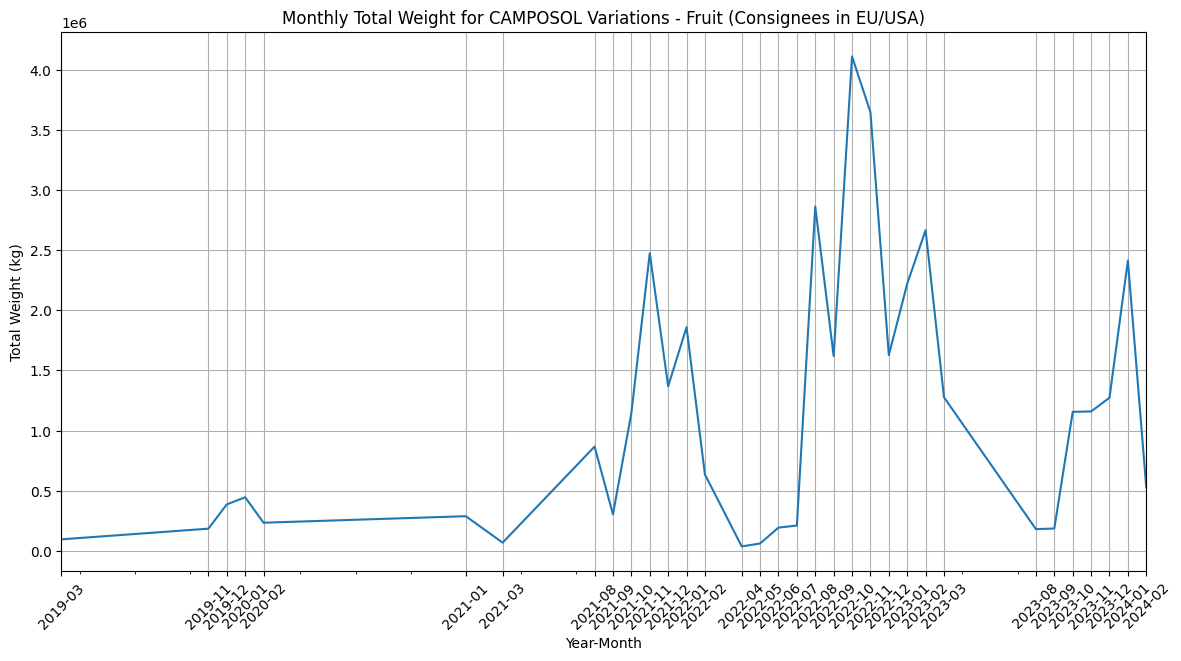

In [ ]:
# Correct the process by ensuring that 'Run_Date' is in datetime format
filtered_fruit_data['Run_Date'] = pd.to_datetime(filtered_fruit_data['Run_Date'])

# Aggregate total weight by month for the filtered combination
filtered_fruit_data['YearMonth'] = filtered_fruit_data['Run_Date'].dt.to_period('M')
monthly_fruit_weight = filtered_fruit_data.groupby('YearMonth')['Weight__kg_'].sum()

# Plot the total weight per month for the filtered combination with adjusted x-axis to show specific months
plt.figure(figsize=(14, 7))
monthly_fruit_weight.plot(kind='line', title='Monthly Total Weight for CAMPOSOL Variations - Fruit (Consignees in EU/USA)')
plt.xlabel('Year-Month')
plt.ylabel('Total Weight (kg)')
plt.xticks(ticks=monthly_fruit_weight.index.to_timestamp(), labels=monthly_fruit_weight.index.strftime('%Y-%m'), rotation=45)  # Show specific months on the x-axis
plt.grid(True)
plt.show()


In [ ]:
filtered_fruit_data.to_csv('CAMPOSOL.csv')

## EDA

In [ ]:
# Load the selected combination
data = pd.read_csv('CAMPOSOL.csv')

# Convert date columns to datetime
data['YearMonth'] = pd.to_datetime(data['YearMonth'], format='%Y-%m', errors='coerce')

# Aggregate data by YearMonth using the 'Weight__kg_' column
monthly_weight_data = data.groupby('YearMonth')['Weight__kg_'].sum().reset_index()

# Set YearMonth as the index and sort the index
monthly_weight_data.set_index('YearMonth', inplace=True)
monthly_weight_data.sort_index(inplace=True)

# Fill any missing months with 0 weight
monthly_weight_data = monthly_weight_data.asfreq('MS').fillna(0)

# save the monthly aggregated data into csv
monthly_weight_data.to_csv('monthlydata.csv')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 60 entries, 2019-03-01 to 2024-02-01
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Weight__kg_  60 non-null     float64
dtypes: float64(1)
memory usage: 960.0 bytes
       Weight__kg_
count       60.000
mean    629993.883
std     996937.191
min          0.000
25%          0.000
50%      82668.000
75%    1148383.000
max    4110695.000


<Figure size 800x600 with 0 Axes>

Text(0.5, 1.0, 'Monthly Shipping Volume of Fruit (2019-2024)')

Text(0.5, 0, 'Year-Month')

Text(0, 0.5, 'Weight (kg)')

(array([17532., 17897., 18262., 18628., 18993., 19358., 19723.]),
 [Text(17532.0, 0, '2018'),
  Text(17897.0, 0, '2019'),
  Text(18262.0, 0, '2020'),
  Text(18628.0, 0, '2021'),
  Text(18993.0, 0, '2022'),
  Text(19358.0, 0, '2023'),
  Text(19723.0, 0, '2024')])

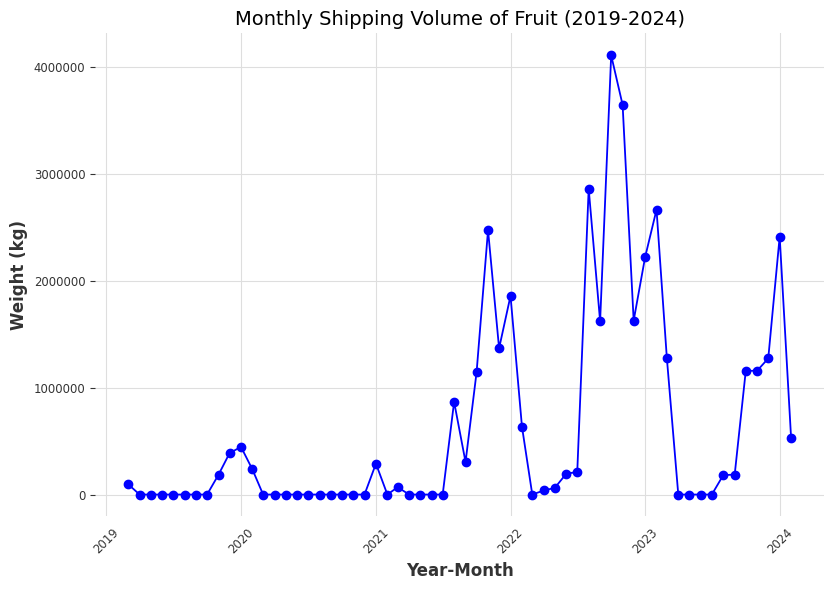

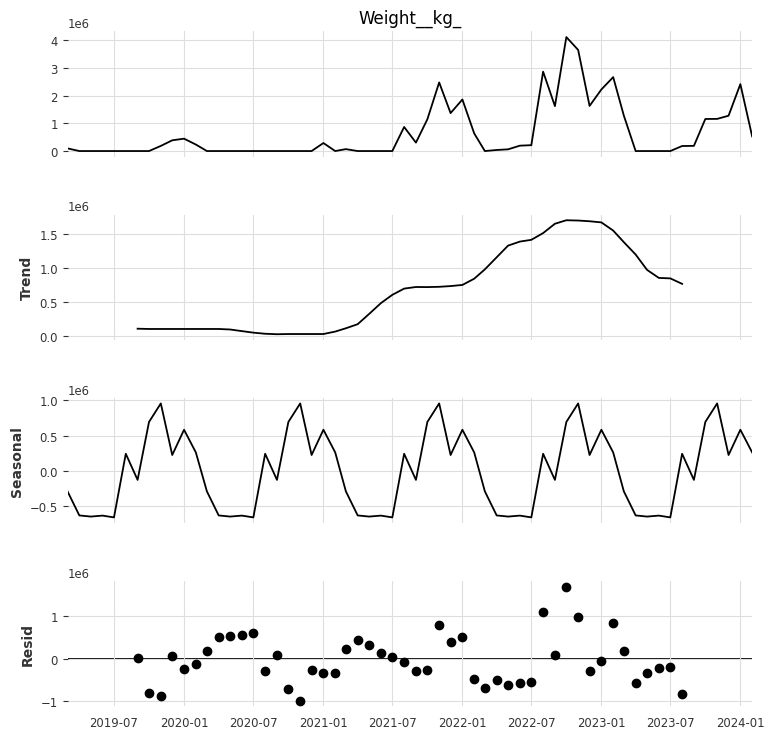

<Figure size 800x600 with 0 Axes>

<Axes: xlabel='Month', ylabel='Weight__kg_'>

Text(0.5, 1.0, 'Seasonal Analysis of Shipping Volume by Month')

Text(0.5, 0, 'Month')

Text(0, 0.5, 'Weight (kg)')

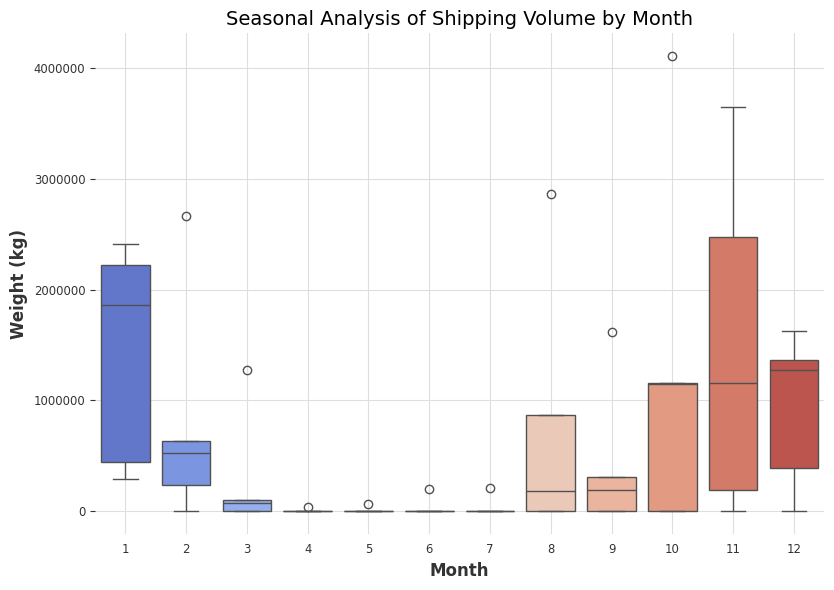

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

# Load the dataset
file_path = 'monthlydata.csv'
data = pd.read_csv(file_path)

# Convert 'YearMonth' to datetime format
data['YearMonth'] = pd.to_datetime(data['YearMonth'])

# Set 'YearMonth' as the index
data.set_index('YearMonth', inplace=True)

# Basic Data Cleaning and Preparation
data.info()
print(data.describe())

# Plot the data to visualize the trend over time
plt.figure(figsize=(8, 6))
plt.plot(data.index, data['Weight__kg_'], marker='o', linestyle='-', color='b')
plt.title('Monthly Shipping Volume of Fruit (2019-2024)', fontsize=14)
plt.xlabel('Year-Month', fontsize=12)
plt.ylabel('Weight (kg)', fontsize=12)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.ticklabel_format(style='plain', axis='y')
plt.show()

# Perform seasonal decomposition
decomposition = seasonal_decompose(data['Weight__kg_'], model='additive', period=12)

# Plot the decomposition results
fig = decomposition.plot()
fig.set_size_inches(8, 8)
plt.show()

# Extract month and year for further analysis
data['Year'] = data.index.year
data['Month'] = data.index.month

# Plot the seasonal component by month
plt.figure(figsize=(8, 6))
sns.boxplot(x='Month', y='Weight__kg_', data=data, palette='coolwarm')
plt.title('Seasonal Analysis of Shipping Volume by Month', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Weight (kg)', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.ticklabel_format(style='plain', axis='y')
plt.show()


## Naive (shift) method

Shift Method In-Sample RMSE: 765406.2813254439
Shift Method In-Sample MAE: 396471.15555555554
Shift Method Rolling Forecast RMSE: 843123.7981400308
Shift Method Rolling Forecast MAE: 571714.7857142857


<ipython-input-9-4be1940de640>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['InSample_Predicted'] = train_data['Shifted']
<ipython-input-9-4be1940de640>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Predicted'] = test_data['Shifted']


<Figure size 1400x700 with 0 Axes>

Text(0.5, 1.0, 'Naive Model (Shift Method) Forecast')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Weight (kg)')

(array([17897., 17928., 17956., 17987., 18017., 18048., 18078., 18109.,
        18140., 18170., 18201., 18231., 18262., 18293., 18322., 18353.,
        18383., 18414., 18444., 18475., 18506., 18536., 18567., 18597.,
        18628., 18659., 18687., 18718., 18748., 18779., 18809., 18840.,
        18871., 18901., 18932., 18962., 18993., 19024., 19052., 19083.,
        19113., 19144., 19174., 19205., 19236., 19266., 19297., 19327.,
        19358., 19389., 19417., 19448., 19478., 19509., 19539., 19570.,
        19601., 19631., 19662., 19692., 19723., 19754., 19783., 19814.]),
 [Text(17897.0, 0, '2019-01'),
  Text(17928.0, 0, '2019-02'),
  Text(17956.0, 0, '2019-03'),
  Text(17987.0, 0, '2019-04'),
  Text(18017.0, 0, '2019-05'),
  Text(18048.0, 0, '2019-06'),
  Text(18078.0, 0, '2019-07'),
  Text(18109.0, 0, '2019-08'),
  Text(18140.0, 0, '2019-09'),
  Text(18170.0, 0, '2019-10'),
  Text(18201.0, 0, '2019-11'),
  Text(18231.0, 0, '2019-12'),
  Text(18262.0, 0, '2020-01'),
  Text(18293.0, 0, 

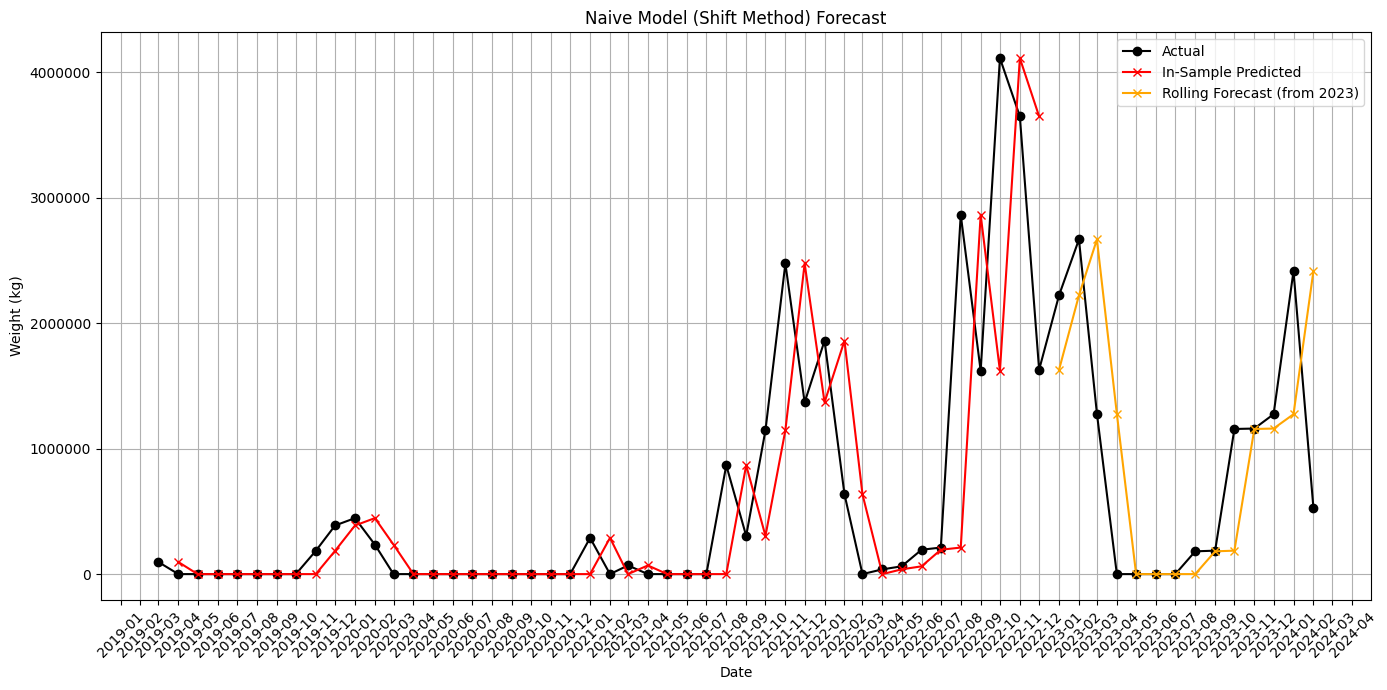

,Date,Weight,Shifted,InSample_Predicted,Predicted
1,2019-04-01,0.000,96390.000,96390.000,NaN
2,2019-05-01,0.000,0.000,0.000,NaN
3,2019-06-01,0.000,0.000,0.000,NaN
4,2019-07-01,0.000,0.000,0.000,NaN
5,2019-08-01,0.000,0.000,0.000,NaN


In [ ]:
# Load the dataset
file_path = 'monthlydata.csv'
data = pd.read_csv(file_path)

# Correct column names if necessary
data.columns = ['Date', 'Weight']
data['Date'] = pd.to_datetime(data['Date'])

# Create a new column with shifted values (previous month's value)
data['Shifted'] = data['Weight'].shift(1)

# Split the dataset into training and testing sets
train_data = data[data['Date'] < '2023-01-01']
test_data = data[data['Date'] >= '2023-01-01']

# In-sample predictions (shifted values within the training set)
train_data['InSample_Predicted'] = train_data['Shifted']

# Rolling forecast predictions (shifted values from the previous month in the test set)
test_data['Predicted'] = test_data['Shifted']

# Drop the first row in both datasets since it will have NaN value for the shifted column
train_data = train_data.dropna()
test_data = test_data.dropna()

# Calculate the performance metrics for in-sample predictions
in_sample_rmse = mean_squared_error(train_data['Weight'], train_data['InSample_Predicted'], squared=False)
in_sample_mae = mean_absolute_error(train_data['Weight'], train_data['InSample_Predicted'])

print('Shift Method In-Sample RMSE:', in_sample_rmse)
print('Shift Method In-Sample MAE:', in_sample_mae)

# Calculate the performance metrics for rolling forecast
shift_rmse = mean_squared_error(test_data['Weight'], test_data['Predicted'], squared=False)
shift_mae = mean_absolute_error(test_data['Weight'], test_data['Predicted'])

print('Shift Method Rolling Forecast RMSE:', shift_rmse)
print('Shift Method Rolling Forecast MAE:', shift_mae)

# Create a DataFrame with actual, in-sample, and rolling forecast predictions
results = pd.concat([train_data, test_data])

# Save the DataFrame to a CSV file
results.to_csv('shift_method.csv', index=False)

# Plot the actual data, in-sample predictions, and rolling forecasts
plt.figure(figsize=(14, 7))
plt.plot(data['Date'], data['Weight'], label='Actual', color='black', marker='o', linestyle='-')
plt.plot(train_data['Date'], train_data['InSample_Predicted'], label='In-Sample Predicted', color='red', marker='x', linestyle='-')
plt.plot(test_data['Date'], test_data['Predicted'], label='Rolling Forecast (from 2023)', color='orange', marker='x', linestyle='-')
plt.title('Naive Model (Shift Method) Forecast')
plt.xlabel('Date')
plt.ylabel('Weight (kg)')
plt.legend()
plt.grid(True)
plt.ticklabel_format(style='plain', axis='y')

# Set date format on the x-axis to show each month
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Display the DataFrame
results.head()


Shift Method In-Sample RMSE: 765406.2813254439
Shift Method In-Sample MAE: 396471.15555555554
Shift Method Rolling Forecast RMSE: 843123.7981400308
Shift Method Rolling Forecast MAE: 571714.7857142857


<Figure size 1200x600 with 0 Axes>

Text(0.5, 1.0, 'Naive Model (Shift Method) Forecast')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Weight (kg)')

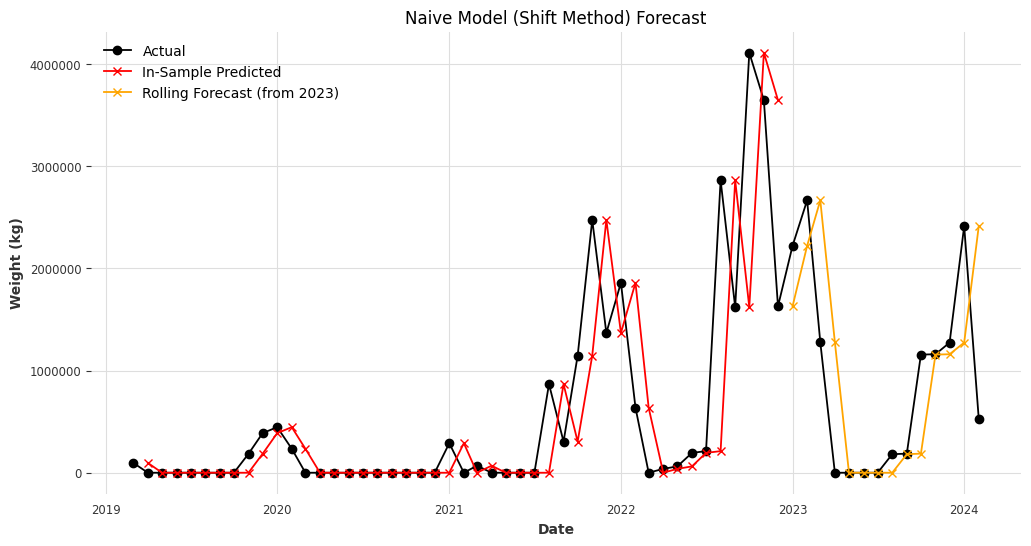

,Date,Weight,Shifted,InSample_Predicted,Predicted
1,2019-04-01,0.000,96390.000,96390.000,NaN
2,2019-05-01,0.000,0.000,0.000,NaN
3,2019-06-01,0.000,0.000,0.000,NaN
4,2019-07-01,0.000,0.000,0.000,NaN
5,2019-08-01,0.000,0.000,0.000,NaN


In [ ]:
# Load the dataset
file_path = 'monthlydata.csv'
data = pd.read_csv(file_path)

# Correct column names if necessary
data.columns = ['Date', 'Weight']
data['Date'] = pd.to_datetime(data['Date'])

# Create a new column with shifted values (previous month's value)
data['Shifted'] = data['Weight'].shift(1)

# Split the dataset into training and testing sets
train_data = data[data['Date'] < '2023-01-01']
test_data = data[data['Date'] >= '2023-01-01']

# In-sample predictions (shifted values within the training set)
train_data['InSample_Predicted'] = train_data['Shifted']

# Rolling forecast predictions (shifted values from the previous month in the test set)
test_data['Predicted'] = test_data['Shifted']

# Drop the first row in both datasets since it will have NaN value for the shifted column
train_data = train_data.dropna()
test_data = test_data.dropna()

# Calculate the performance metrics for in-sample predictions
in_sample_rmse = mean_squared_error(train_data['Weight'], train_data['InSample_Predicted'], squared=False)
in_sample_mae = mean_absolute_error(train_data['Weight'], train_data['InSample_Predicted'])

print('Shift Method In-Sample RMSE:', in_sample_rmse)
print('Shift Method In-Sample MAE:', in_sample_mae)

# Calculate the performance metrics for rolling forecast
shift_rmse = mean_squared_error(test_data['Weight'], test_data['Predicted'], squared=False)
shift_mae = mean_absolute_error(test_data['Weight'], test_data['Predicted'])

print('Shift Method Rolling Forecast RMSE:', shift_rmse)
print('Shift Method Rolling Forecast MAE:', shift_mae)

# Create a DataFrame with actual, in-sample, and rolling forecast predictions
results = pd.concat([train_data, test_data])

# Save the DataFrame to a CSV file
results.to_csv('shift_method.csv', index=False)

# Plot the actual data, in-sample predictions, and rolling forecasts
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Weight'], label='Actual', color='black', marker='o', linestyle='-')
plt.plot(train_data['Date'], train_data['InSample_Predicted'], label='In-Sample Predicted', color='red', marker='x', linestyle='-')
plt.plot(test_data['Date'], test_data['Predicted'], label='Rolling Forecast (from 2023)', color='orange', marker='x', linestyle='-')
plt.title('Naive Model (Shift Method) Forecast')
plt.xlabel('Date')
plt.ylabel('Weight (kg)')
plt.legend()
plt.grid(True)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

# Display the DataFrame
results.head()


## ARIMA



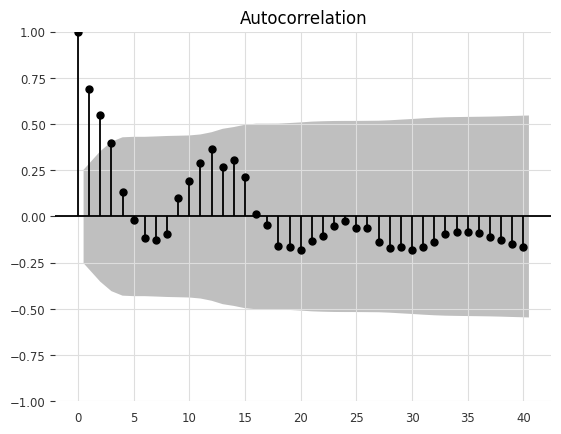

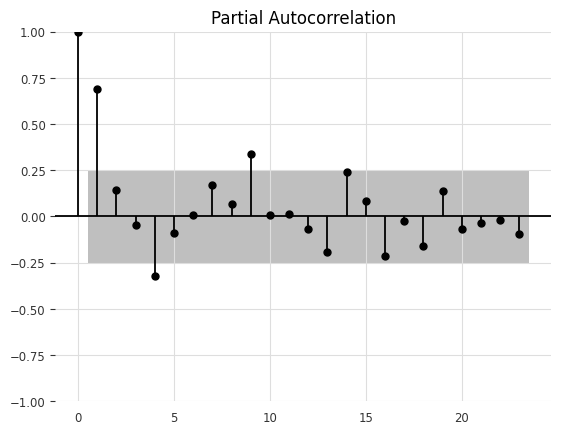

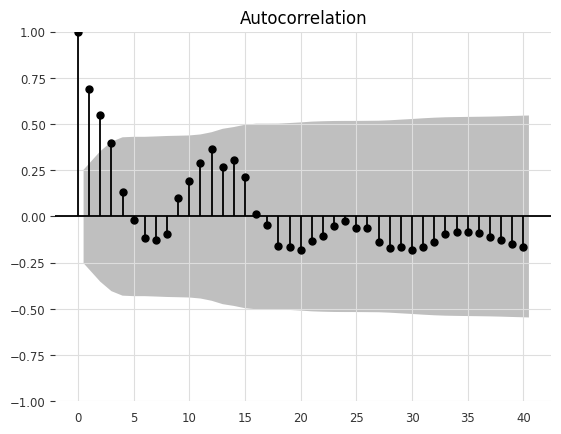

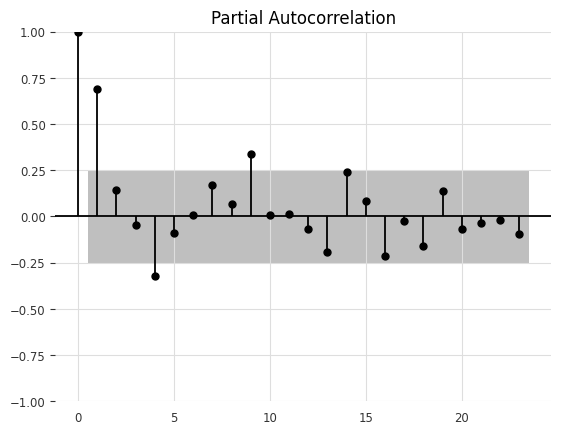

In [ ]:
# Plot the ACF and PACF
plot_acf(monthly_weight_data['Weight__kg_'], lags=40)
plot_pacf(monthly_weight_data['Weight__kg_'], lags=23)
plt.show()

In [ ]:
# Perform the Augmented Dickey-Fuller test
adf_test = adfuller(monthly_weight_data['Weight__kg_'])
adf_result = {
    'ADF Statistic': adf_test[0],
    'p-value': adf_test[1],
    'Critical Values': adf_test[4]
}
adf_result
# p-value < 5%, our dataset is not stationary

{'ADF Statistic': -1.3034737325889731,
 'p-value': 0.6275815820506814,
 'Critical Values': {'1%': -3.5656240522121956,
  '5%': -2.920142229157715,
  '10%': -2.598014675124952}}

ARIMA In-Sample RMSE: 550505.3728966027
ARIMA In-Sample MAE: 314136.4862873436
ARIMA Rolling Forecast RMSE: 1194658.899242919
ARIMA Rolling Forecast MAE: 879204.3262366006


<Figure size 1200x600 with 0 Axes>

Text(0.5, 1.0, 'ARIMA Rolling Forecast with In-Sample Predictions')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Weight (kg)')

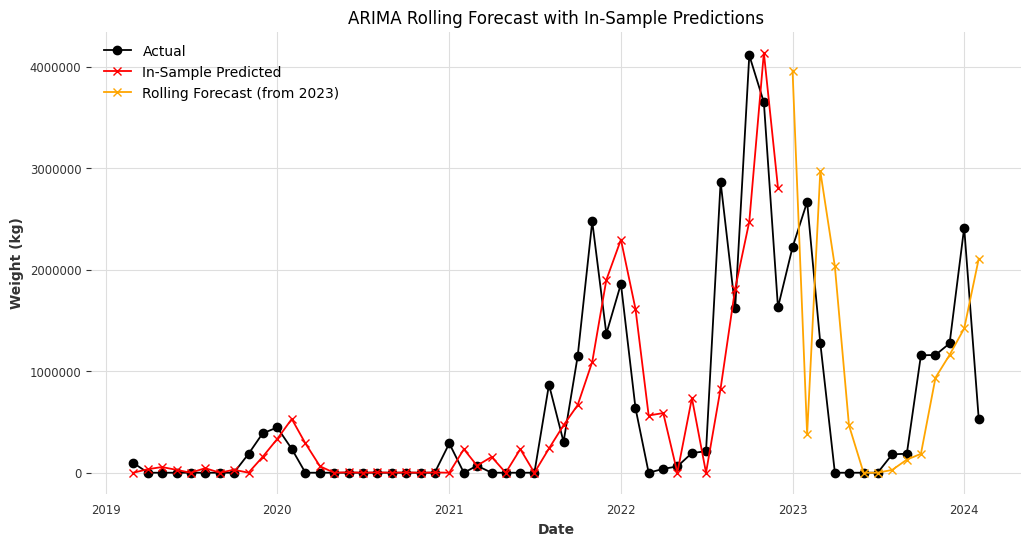

,Date,Weight,InSample_Predicted,Predicted
0,2019-03-01,96390.000,0.000,NaN
1,2019-04-01,0.000,34821.207,NaN
2,2019-05-01,0.000,55892.878,NaN
3,2019-06-01,0.000,28303.617,NaN
4,2019-07-01,0.000,0.000,NaN


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load the dataset
file_path = 'monthlydata.csv'
data = pd.read_csv(file_path)

# Correct column names if necessary
data.columns = ['Date', 'Weight']
data['Date'] = pd.to_datetime(data['Date'])

# Split the dataset into training and testing sets
train_data = data[data['Date'] < '2023-01-01']
test_data = data[data['Date'] >= '2023-01-01']

# Define the rolling forecast function
def rolling_forecast_arima(train_data, test_data, order):
    history = [x for x in train_data['Weight']]
    predictions = []

    for t in range(len(test_data)):
        model = ARIMA(history, order=order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        yhat = max(yhat, 0)  # Ensure non-negative predictions
        predictions.append(yhat)
        history.append(test_data['Weight'].iloc[t])

    return predictions

# Define the ARIMA order (example parameters, can be tuned)
order = (3, 1, 1)

# Perform rolling forecast
arima_predictions = rolling_forecast_arima(train_data, test_data, order)

# In-sample predictions
initial_arima_model = ARIMA(train_data['Weight'], order=order)
initial_arima_fit = initial_arima_model.fit()
in_sample_predictions = initial_arima_fit.predict(start=0, end=len(train_data) - 1, typ='levels')

# Ensure non-negative in-sample predictions
in_sample_predictions = np.maximum(in_sample_predictions, 0)

# Calculate the performance metrics for in-sample predictions
in_sample_rmse = mean_squared_error(train_data['Weight'], in_sample_predictions, squared=False)
in_sample_mae = mean_absolute_error(train_data['Weight'], in_sample_predictions)

print('ARIMA In-Sample RMSE:', in_sample_rmse)
print('ARIMA In-Sample MAE:', in_sample_mae)

# Calculate the performance metrics for rolling forecast
arima_rmse = mean_squared_error(test_data['Weight'], arima_predictions, squared=False)
arima_mae = mean_absolute_error(test_data['Weight'], arima_predictions)

print('ARIMA Rolling Forecast RMSE:', arima_rmse)
print('ARIMA Rolling Forecast MAE:', arima_mae)

# Create a DataFrame with actual, in-sample, and rolling forecast predictions
results = pd.concat([train_data, test_data])
results['InSample_Predicted'] = np.concatenate([in_sample_predictions, [np.nan] * len(test_data)])
results.loc[results['Date'] >= '2023-01-01', 'Predicted'] = arima_predictions

# Save the DataFrame to a CSV file
results.to_csv('arima_rolling.csv', index=False)

# Plot the actual data, in-sample predictions, and rolling forecasts
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Weight'], label='Actual', color='black', marker='o', linestyle='-')
plt.plot(train_data['Date'], in_sample_predictions, label='In-Sample Predicted', color='red', marker='x', linestyle='-')
plt.plot(test_data['Date'], arima_predictions, label='Rolling Forecast (from 2023)', color='orange', marker='x', linestyle='-')
plt.title('ARIMA Rolling Forecast with In-Sample Predictions')
plt.xlabel('Date')
plt.ylabel('Weight (kg)')
plt.legend()
plt.grid(True)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

# Display the DataFrame
results.head()


## SARIMA

SARIMA In-Sample RMSE: 728301.0934741007
SARIMA In-Sample MAE: 361739.4572161283
SARIMA Rolling Forecast RMSE: 1063349.8361578104
SARIMA Rolling Forecast MAE: 709653.4456064395


<Figure size 1200x600 with 0 Axes>

Text(0.5, 1.0, 'SARIMA Rolling Forecast with In-Sample Predictions')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Weight (kg)')

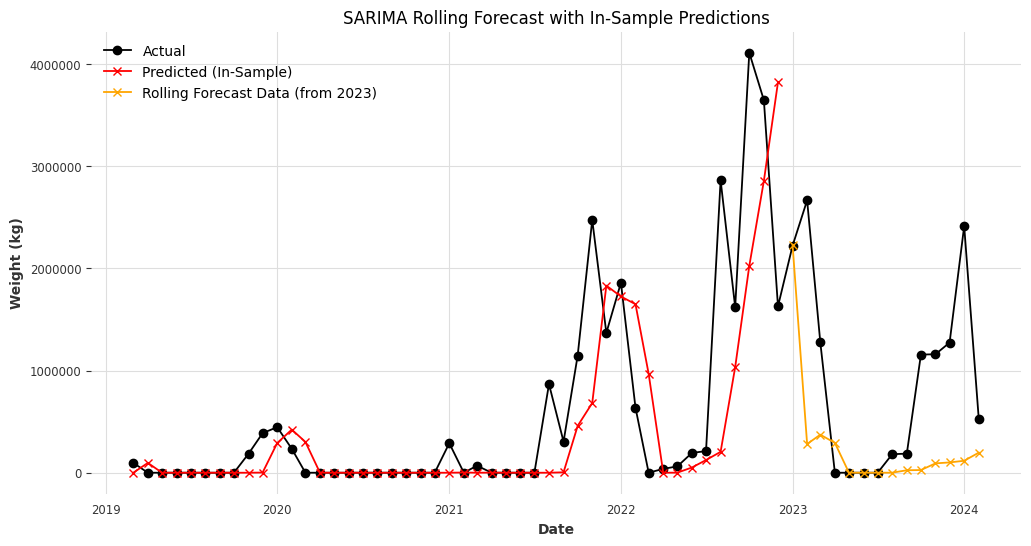

,Date,Weight,LogWeight,InSample_Predicted,Predicted
0,2019-03-01,96390.000,11.476,0.000,NaN
1,2019-04-01,0.000,0.000,96375.575,NaN
2,2019-05-01,0.000,0.000,87.893,NaN
3,2019-06-01,0.000,0.000,0.000,NaN
4,2019-07-01,0.000,0.000,0.000,NaN


In [ ]:
import pmdarima as pm
# Load the dataset
file_path = 'monthlydata.csv'
data = pd.read_csv(file_path)

# Correct column names if necessary
data.columns = ['Date', 'Weight']
data['Date'] = pd.to_datetime(data['Date'])

# Log transform to stabilize variance
data['LogWeight'] = np.log1p(data['Weight'])

# Split the dataset into training and testing sets
train_data = data[data['Date'] < '2023-01-01']
test_data = data[data['Date'] >= '2023-01-01']

# Define the rolling forecast function with SARIMA
def rolling_forecast_sarima(train_data, test_data):
    history = [x for x in train_data['LogWeight']]
    predictions = []

    for t in range(len(test_data)):
        # Using pmdarima to search for the best combination of parameters for SARIMA
        sarima_model = pm.auto_arima(history,
                                     start_p=1, start_q=1,
                                     test='adf',
                                     m=12,
                                     seasonal=True,
                                     trace=False,
                                     error_action='ignore',
                                     suppress_warnings=True,
                                     stepwise=True)

        yhat = sarima_model.predict(n_periods=1)[0]
        yhat = max(np.expm1(yhat), 0)  # Ensure non-negative predictions and invert the log transform
        predictions.append(yhat)
        history.append(np.log1p(test_data['Weight'].iloc[t]))  # Use log-transformed values

    return predictions

# Perform rolling forecast
sarima_predictions = rolling_forecast_sarima(train_data, test_data)

# In-sample predictions
initial_sarima_model = pm.auto_arima(train_data['LogWeight'],
                                     start_p=1, start_q=1,
                                     test='adf',
                                     m=12,
                                     seasonal=True,
                                     trace=False,
                                     error_action='ignore',
                                     suppress_warnings=True,
                                     stepwise=True)

in_sample_predictions = initial_sarima_model.predict_in_sample()
in_sample_predictions = np.expm1(in_sample_predictions)  # Invert log transformation

# Ensure non-negative in-sample predictions
in_sample_predictions = np.maximum(in_sample_predictions, 0)

# Calculate the performance metrics for in-sample predictions
in_sample_rmse = mean_squared_error(train_data['Weight'], in_sample_predictions, squared=False)
in_sample_mae = mean_absolute_error(train_data['Weight'], in_sample_predictions)

print('SARIMA In-Sample RMSE:', in_sample_rmse)
print('SARIMA In-Sample MAE:', in_sample_mae)

# Calculate the performance metrics for rolling forecast
sarima_rmse = mean_squared_error(test_data['Weight'], sarima_predictions, squared=False)
sarima_mae = mean_absolute_error(test_data['Weight'], sarima_predictions)

print('SARIMA Rolling Forecast RMSE:', sarima_rmse)
print('SARIMA Rolling Forecast MAE:', sarima_mae)

# Create a DataFrame with actual, in-sample, and rolling forecast predictions
results = pd.concat([train_data, test_data])
results['InSample_Predicted'] = np.concatenate([in_sample_predictions, [np.nan] * len(test_data)])
results.loc[results['Date'] >= '2023-01-01', 'Predicted'] = sarima_predictions

# Plot the actual data, in-sample predictions, and rolling forecasts
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Weight'], marker='o', linestyle='-', color='black', label='Actual')
plt.plot(train_data['Date'], in_sample_predictions, marker='x', linestyle='-', color='r', label='Predicted (In-Sample)')
plt.plot(test_data['Date'], sarima_predictions, label='Rolling Forecast Data (from 2023)', marker='x', linestyle='-', color='orange')
plt.title('SARIMA Rolling Forecast with In-Sample Predictions')
plt.xlabel('Date')
plt.ylabel('Weight (kg)')
plt.legend()
plt.grid(True)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

# Display the DataFrame
results.head()
results.to_csv("sarima_rolling.csv", index=False)

## Prophet

DEBUG:cmdstanpy:input tempfile: /tmp/tmpkro4gbes/fsy1x8d6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkro4gbes/gw3ekf5r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49023', 'data', 'file=/tmp/tmpkro4gbes/fsy1x8d6.json', 'init=/tmp/tmpkro4gbes/gw3ekf5r.json', 'output', 'file=/tmp/tmpkro4gbes/prophet_modelz2nw99um/prophet_model-20240718092556.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:25:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:25:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkro4gbes/eu5095_b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkro4gbes/laqpmu7m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

         Date  Actual_Weight_kg  Predicted_Weight_kg
0  2019-03-31             96390                0.000
1  2019-04-30                 0                0.000
2  2019-05-31                 0                0.000
3  2019-06-30                 0                0.000
4  2019-07-31                 0                0.000
5  2019-08-31                 0           272678.071
6  2019-09-30                 0                0.000
7  2019-10-31                 0           731973.777
8  2019-11-30            185232          1133179.442
9  2019-12-31            387226            81696.751
10 2020-01-31            445992           416110.760
11 2020-02-29            234586                0.000
12 2020-03-31                 0                0.000
13 2020-04-30                 0                0.000
14 2020-05-31                 0                0.000
15 2020-06-30                 0                0.000
16 2020-07-31                 0                0.000
17 2020-08-31                 0               

<Figure size 1200x600 with 0 Axes>

Text(0.5, 1.0, 'Prophet Rolling Forecast with In-Sample Predictions')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Weight (kg)')

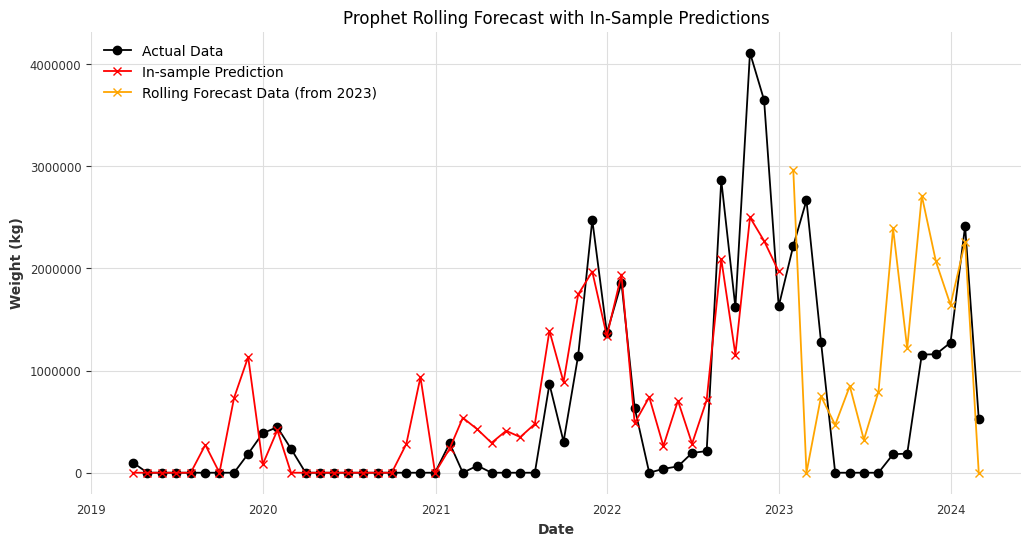

{'Prophet_RMSE': 1172299.9787936506, 'Prophet_MAE': 937665.516153602, 'InSample_RMSE': 501967.12227302644, 'InSample_MAE': 337967.08105745434}


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Disable scientific notation for display
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Load and prepare the data
file_path = 'CAMPOSOL.csv'
data = pd.read_csv(file_path)

data['Run_Date'] = pd.to_datetime(data['Run_Date'], errors='coerce')
data = data[['Run_Date', 'Weight__kg_']].dropna()
data['Weight__kg_'] = pd.to_numeric(data['Weight__kg_'], errors='coerce')
data = data.dropna(subset=['Weight__kg_'])
monthly_shipping_data = data.set_index('Run_Date').resample('M').sum().reset_index()

# Prepare data for Prophet
prophet_data = monthly_shipping_data.rename(columns={'Run_Date': 'ds', 'Weight__kg_': 'y'})

# Split into training (2019-2022) and test (2023-2024) sets
train_data = prophet_data[(prophet_data['ds'] >= '2019-01-01') & (prophet_data['ds'] <= '2022-12-31')]
test_data = prophet_data[(prophet_data['ds'] >= '2023-01-01') & (prophet_data['ds'] <= '2024-02-29')]

# Define holidays
holidays = pd.DataFrame({
    'holiday': 'holiday',
    'ds': pd.to_datetime(['2020-01-01', '2020-12-25', '2021-01-01', '2021-12-25',
                          '2022-01-01', '2022-12-25', '2023-01-01', '2023-12-25']),
    'lower_window': 0,
    'upper_window': 1,
})

# Initialize and train the Prophet model with additional components
def train_and_forecast(train_data, periods=1):
    model = Prophet(holidays=holidays, yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
    model.add_seasonality(name='monthly', period=30.5, fourier_order=1)
    model.fit(train_data)
    future = model.make_future_dataframe(periods=periods, freq='M')
    forecast = model.predict(future)
    return forecast

# Perform rolling forecast
history = train_data.copy()
rolling_predictions = []

for t in range(len(test_data)):
    forecast = train_and_forecast(history, periods=1)
    yhat = forecast['yhat'].iloc[-1]
    yhat = max(0, yhat)  # Ensure non-negative predictions
    rolling_predictions.append(yhat)
    new_row = test_data.iloc[t:t+1]
    history = pd.concat([history, new_row])

# Make in-sample predictions
in_sample_forecast = train_and_forecast(train_data, periods=0)
in_sample_forecast['yhat'] = in_sample_forecast['yhat'].apply(lambda x: max(0, x))  # Ensure non-negative predictions

# Combine in-sample and out-of-sample forecasts
all_forecasts = pd.concat([in_sample_forecast[['ds', 'yhat']], pd.DataFrame({'ds': test_data['ds'], 'yhat': rolling_predictions})], axis=0).reset_index(drop=True)
all_forecasts.rename(columns={'ds': 'Date', 'yhat': 'Predicted_Weight_kg'}, inplace=True)

# Combine actual data for the entire period
all_data = pd.concat([train_data, test_data], axis=0).reset_index(drop=True)
all_data.rename(columns={'ds': 'Date', 'y': 'Actual_Weight_kg'}, inplace=True)

# Merge the predictions with the actual data
results = pd.merge(all_data, all_forecasts, on='Date', how='left')

# Display the merged dataframe
print(results)

# Save to a CSV file if needed
results.to_csv('prophet_rolling_predictions.csv', index=False)

# Plot predictions
plt.figure(figsize=(12, 6))
plt.plot(results['Date'], results['Actual_Weight_kg'], label='Actual Data', color='black', marker='o', linestyle='-')
plt.plot(in_sample_forecast['ds'], in_sample_forecast['yhat'], label='In-sample Prediction', color='red', marker='x', linestyle='-')
plt.plot(test_data['ds'], rolling_predictions, label='Rolling Forecast Data (from 2023)', color='orange', marker='x', linestyle='-')
plt.title('Prophet Rolling Forecast with In-Sample Predictions')
plt.xlabel('Date')
plt.ylabel('Weight (kg)')
plt.legend()
plt.grid(True)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

# Compute error metrics for rolling forecast
prophet_rmse = mean_squared_error(test_data['y'], rolling_predictions, squared=False)
prophet_mae = mean_absolute_error(test_data['y'], rolling_predictions)

# Compute error metrics for in-sample predictions
in_sample_rmse = mean_squared_error(train_data['y'], in_sample_forecast['yhat'], squared=False)
in_sample_mae = mean_absolute_error(train_data['y'], in_sample_forecast['yhat'])

prophet_error_metrics = {
    'Prophet_RMSE': prophet_rmse,
    'Prophet_MAE': prophet_mae,
    'InSample_RMSE': in_sample_rmse,
    'InSample_MAE': in_sample_mae
}

print(prophet_error_metrics)

## LSTM

1/1 [==============================] - 0s 278ms/step


1/1 [==============================] - 0s 241ms/step


1/1 [==============================] - 0s 235ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 233ms/step


1/1 [==============================] - 0s 238ms/step


1/1 [==============================] - 0s 247ms/step


1/1 [==============================] - 0s 236ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 247ms/step


1/1 [==============================] - 0s 233ms/step


2/2 [==============================] - 0s 6ms/step
LSTM Rolling Forecast RMSE: 565914.0196332448
LSTM Rolling Forecast MAE: 431683.7391546466
LSTM In-Sample RMSE: 544135.1705512556
LSTM In-Sample MAE: 315235.7113917151


<Figure size 1200x600 with 0 Axes>

Text(0.5, 1.0, 'LSTM Rolling Forecast with In-Sample Predictions')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Weight (kg)')

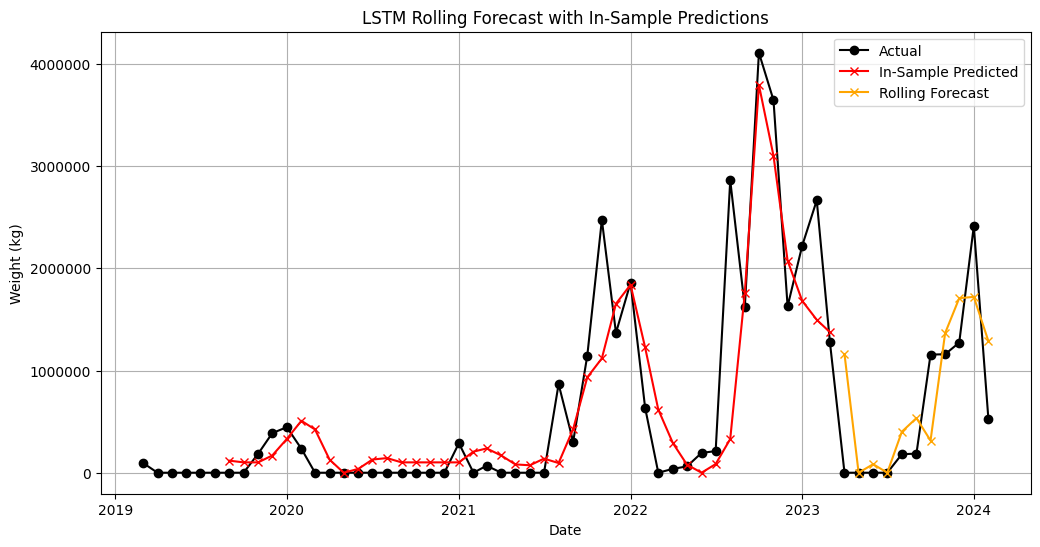

,Date,Actual,Predicted
0,2019-09-01,0.000,118054.039
1,2019-10-01,0.000,101327.344
2,2019-11-01,185232.000,101327.344
3,2019-12-01,387226.000,168555.234
4,2020-01-01,445992.000,330250.469


In [ ]:
# Disable scientific notation for display
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Load the dataset
data = pd.read_csv('CAMPOSOL.csv')

# Convert date columns to datetime
data['YearMonth'] = pd.to_datetime(data['YearMonth'], format='%Y-%m', errors='coerce')

# Aggregate data by YearMonth using the 'Weight__kg_' column
monthly_weight_data = data.groupby('YearMonth')['Weight__kg_'].sum().reset_index()

# Set YearMonth as the index and sort the index
monthly_weight_data.set_index('YearMonth', inplace=True)
monthly_weight_data.sort_index(inplace=True)

# Fill any missing months with 0 weight
monthly_weight_data = monthly_weight_data.asfreq('MS').fillna(0)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(monthly_weight_data)

# Create a DataFrame for the scaled data
scaled_data_df = pd.DataFrame(scaled_data, index=monthly_weight_data.index, columns=['Weight__kg_'])

# Function to create sequences for LSTM
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Create sequences
seq_length = 6  # Use a sequence length of 6 months
X, y = create_sequences(scaled_data_df.values, seq_length)

# Reshape X for LSTM [samples, time steps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

# Split the data into initial training and testing sets
initial_train_size = int(len(X) * 0.8)
X_initial_train, X_test = X[:initial_train_size], X[initial_train_size:]
y_initial_train, y_test = y[:initial_train_size], y[initial_train_size:]

# Define the LSTM model
def create_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=input_shape))
    model.add(LSTM(units=50, activation='relu'))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Perform rolling forecast
history_X, history_y = X_initial_train.tolist(), y_initial_train.tolist()
predictions = []

for t in range(len(X_test)):
    # Create and train the model
    model = create_model((seq_length, 1))
    model.fit(np.array(history_X), np.array(history_y), epochs=100, batch_size=1, verbose=0)

    # Make one-step forecast
    yhat = model.predict(X_test[t].reshape(1, seq_length, 1))[0][0]
    yhat = scaler.inverse_transform([[yhat]])[0][0]
    predictions.append(yhat)

    # Update history with the true observation
    history_X.append(X_test[t])
    history_y.append(y_test[t])

# In-sample predictions
model = create_model((seq_length, 1))
model.fit(X_initial_train, y_initial_train, epochs=100, batch_size=1, verbose=0)
in_sample_predictions = model.predict(X_initial_train)
in_sample_predictions = scaler.inverse_transform(in_sample_predictions)

# Disable negative predictions
predictions = [max(0, pred) for pred in predictions]
in_sample_predictions[in_sample_predictions < 0] = 0

# Inverse transform the actual values to original scale
y_initial_train_inv = scaler.inverse_transform(y_initial_train.reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Create DataFrames with actual vs predicted values
train_index = monthly_weight_data.index[seq_length:initial_train_size + seq_length]
test_index = monthly_weight_data.index[initial_train_size + seq_length:]

train_df = pd.DataFrame({'Date': train_index, 'Actual': y_initial_train_inv.flatten(), 'Predicted': in_sample_predictions.flatten()})
test_df = pd.DataFrame({'Date': test_index, 'Actual': y_test_inv.flatten(), 'Predicted': predictions})

# Concatenate the in-sample and out-of-sample predictions
all_predictions_df = pd.concat([train_df, test_df])

# Calculate error metrics for out-of-sample predictions
rmse = np.sqrt(mean_squared_error(test_df['Actual'], test_df['Predicted']))
mae = mean_absolute_error(test_df['Actual'], test_df['Predicted'])

# Calculate error metrics for in-sample predictions
in_sample_rmse = np.sqrt(mean_squared_error(train_df['Actual'], train_df['Predicted']))
in_sample_mae = mean_absolute_error(train_df['Actual'], train_df['Predicted'])

print('LSTM Rolling Forecast RMSE:', rmse)
print('LSTM Rolling Forecast MAE:', mae)
print('LSTM In-Sample RMSE:', in_sample_rmse)
print('LSTM In-Sample MAE:', in_sample_mae)

# Plot the actual data, in-sample predictions, and rolling forecasts
plt.figure(figsize=(12, 6))
plt.plot(monthly_weight_data.index, monthly_weight_data['Weight__kg_'], label='Actual', color='black', marker='o', linestyle='-')
plt.plot(train_df['Date'], train_df['Predicted'], label='In-Sample Predicted', color='red', marker='x', linestyle='-')
plt.plot(test_df['Date'], test_df['Predicted'], label='Rolling Forecast', color='orange', marker='x', linestyle='-')
plt.title('LSTM Rolling Forecast with In-Sample Predictions')
plt.xlabel('Date')
plt.ylabel('Weight (kg)')
plt.legend()
plt.grid(True)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

# Display the DataFrame
all_predictions_df.head()


In [ ]:
all_predictions_df.to_csv("lstm_rolling.csv")

## N-BEATS

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 696 K  | train
-------------------------------------------------------------
695 K     Trainable params
1.3 K     Non-trainable params
696 K     Total params
2.787     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=10, num_blocks=1, num_layers=2, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.2, activation=ReLU, input_chunk_length=4, output_chunk_length=1, n_epochs=200, random_state=0)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

<Figure size 1200x600 with 0 Axes>

Text(0.5, 1.0, 'N-BEATS Rolling Forecast with In-Sample Predictions')

Text(0.5, 0, 'YearMonth')

Text(0, 0.5, 'Weight (kg)')

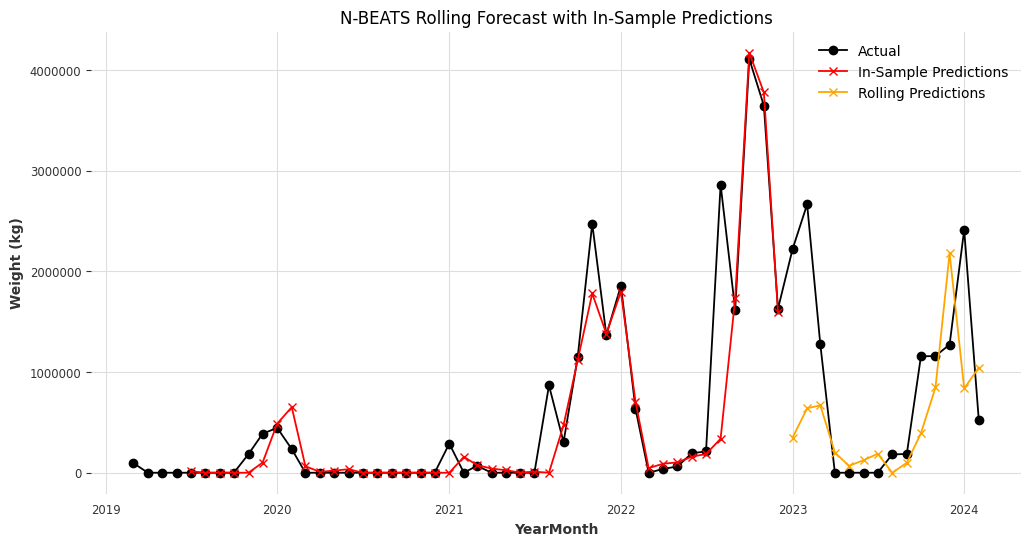

Mean Absolute Error (MAE) for In-Sample Predictions: 156262.428632646
Root Mean Squared Error (RMSE) for In-Sample Predictions: 439154.3789012335
Mean Absolute Error (MAE) for Rolling Predictions: 673801.6209916653
Root Mean Squared Error (RMSE) for Rolling Predictions: 940131.6527349623


In [ ]:

# Suppress Darts logging for clearer output
logging.getLogger("darts").setLevel(logging.ERROR)

# Load the dataset
file_path = 'monthlydata.csv'
data = pd.read_csv(file_path)
data['YearMonth'] = pd.to_datetime(data['YearMonth'])
data.set_index('YearMonth', inplace=True)

# Split the dataset into training and testing
train_data = data[data.index < '2023-01-01']
test_data = data[(data.index >= '2023-01-01') & (data.index <= '2024-12-31')]

# Convert the data to a TimeSeries object
series = TimeSeries.from_series(data['Weight__kg_'])
train_series = TimeSeries.from_series(train_data['Weight__kg_'])
test_series = TimeSeries.from_series(test_data['Weight__kg_'])

# Initialize and train the N-BEATS model
model = NBEATSModel(
    input_chunk_length=4,
    output_chunk_length=1,
    num_stacks=10,
    num_blocks=1,
    num_layers=2,
    layer_widths=256,
    n_epochs=200,
    dropout=0.2,
    random_state=0
)

model.fit(train_series)

# In-sample predictions for the training period
in_sample_predictions = model.historical_forecasts(
    series=train_series,
    start=train_series.time_index[4],  # Ensure start index matches the input_chunk_length
    forecast_horizon=1,
    stride=1,
    retrain=False
)

# Perform rolling forecast manually
rolling_predictions = []
history = train_series
for i in range(len(test_series)):
    forecast = model.predict(n=1, series=history)
    rolling_predictions.append(forecast.values()[0][0])  # Get the forecast value
    history = history.append(test_series[i])

# Create DataFrames for in-sample and rolling predictions
in_sample_predictions_df = pd.DataFrame({
    'Date': train_series.time_index[4:],  # Adjust to start from the right index
    'In_Sample_Predicted': in_sample_predictions.values().flatten()
})

rolling_predictions_df = pd.DataFrame({
    'Date': test_series.time_index,
    'Actual': test_series.values().flatten(),
    'Rolling_Predicted': rolling_predictions
})

# Combine the DataFrames
combined_df = pd.concat([in_sample_predictions_df.set_index('Date'), rolling_predictions_df.set_index('Date')], axis=1)
combined_df = combined_df.reset_index()

# Disable negative predictions
combined_df['In_Sample_Predicted'] = combined_df['In_Sample_Predicted'].apply(lambda x: max(x, 0) if not np.isnan(x) else x)
combined_df['Rolling_Predicted'] = combined_df['Rolling_Predicted'].apply(lambda x: max(x, 0) if not np.isnan(x) else x)

# Compute error metrics for in-sample predictions
in_sample_actuals = train_data['Weight__kg_'].iloc[4:].values
in_sample_mae_value = mean_absolute_error(in_sample_actuals, in_sample_predictions_df['In_Sample_Predicted'])
in_sample_rmse_value = np.sqrt(mean_squared_error(in_sample_actuals, in_sample_predictions_df['In_Sample_Predicted']))

# Compute error metrics for rolling predictions
rolling_mae_value = mean_absolute_error(rolling_predictions_df['Actual'], rolling_predictions_df['Rolling_Predicted'])
rolling_rmse_value = np.sqrt(mean_squared_error(rolling_predictions_df['Actual'], rolling_predictions_df['Rolling_Predicted']))

# Save the DataFrame to a CSV file
combined_df.to_csv("nbeats_all_predictions.csv", index=False)

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Weight__kg_'], label='Actual', color='black', marker='o', linestyle='-')
plt.plot(combined_df['Date'], combined_df['In_Sample_Predicted'], label='In-Sample Predictions', color='red', marker='x', linestyle='-')
plt.plot(combined_df['Date'], combined_df['Rolling_Predicted'], label='Rolling Predictions',  color='orange', marker='x', linestyle='-')
plt.legend()
plt.title('N-BEATS Rolling Forecast with In-Sample Predictions')
plt.xlabel('YearMonth')
plt.ylabel('Weight (kg)')
plt.ticklabel_format(style='plain', axis='y')
plt.show()


print(f"Mean Absolute Error (MAE) for In-Sample Predictions: {in_sample_mae_value}")
print(f"Root Mean Squared Error (RMSE) for In-Sample Predictions: {in_sample_rmse_value}")
print(f"Mean Absolute Error (MAE) for Rolling Predictions: {rolling_mae_value}")
print(f"Root Mean Squared Error (RMSE) for Rolling Predictions: {rolling_rmse_value}")


## TimesFM (pre-trained model by Google)

In [ ]:
! pip install timesfm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 72.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.2/440.2 kB 50.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.3/363.3 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.5/22.5 MB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 895.7/895.7 kB 65.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import timesfm

In [ ]:
JAX_PLATFORMS='cpu'
# Disable scientific notation for display
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Load your data
data = pd.read_csv('monthlydata.csv')
data['YearMonth'] = pd.to_datetime(data['YearMonth'])

# Set 'YearMonth' as the index
data.set_index('YearMonth', inplace=True)

# Split the data into training (2019-2022) and testing (2023-2024) sets
train_data = data['2019-01-01':'2022-12-31']
test_data = data['2023-01-01':'2024-12-31']

# Reset the index to make sure the 'YearMonth' column is available for joining
data.reset_index(inplace=True)

# Prepare the data for TimesFM
# Create input DataFrame as expected by TimesFM
input_df = train_data.reset_index()[['YearMonth', 'Weight__kg_']].rename(columns={'YearMonth': 'ds', 'Weight__kg_': 'y'})

# Add a unique_id column if dealing with multiple time series
input_df['unique_id'] = 'T1'  # Replace 'T1' with a unique identifier for each series

# Set the frequency
freq = 'M'  # Monthly data

# Initialize the TimesFM model
tfm = timesfm.TimesFm(
    context_len=32,  # minimum context length has to be set to 32
    horizon_len=15,  # forecasting horizon length
    input_patch_len=32,  # Set input patch length to match context_len
    output_patch_len=128,  # Set output patch length to match horizon_len
    num_layers=20,
    model_dims=1280,
    backend='cpu',  # Use 'cpu' as the backend
)


# Load the pre-trained checkpoint
tfm.load_from_checkpoint(repo_id="google/timesfm-1.0-200m")

# Perform forecasting using TimesFM
forecast_df = tfm.forecast_on_df(
    inputs=input_df,
    freq=freq,  # 'M' for monthly data
    value_name='y',
    num_jobs=-1
)

# Ensure the forecast includes the test period
forecast_df = forecast_df[forecast_df['ds'] >= '2023-01-01']
forecast_df

# Extract out-of-sample predictions
out_of_sample_predictions = forecast_df.set_index('ds')['timesfm']


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

README.md:   0%|          | 0.00/5.73k [00:00<?, ?B/s]

(…)nts/checkpoint_1100000/metadata/metadata:   0%|          | 0.00/43.9k [00:00<?, ?B/s]

checkpoint:   0%|          | 0.00/814M [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.60k [00:00<?, ?B/s]

(…)oint_1100000/descriptor/descriptor.pbtxt:   0%|          | 0.00/499 [00:00<?, ?B/s]

Constructing model weights.


Constructed model weights in 4.28 seconds.
Restoring checkpoint from /root/.cache/huggingface/hub/models--google--timesfm-1.0-200m/snapshots/8775f7531211ac864b739fe776b0b255c277e2be/checkpoints.


ERROR:absl:For checkpoint version > 1.0, we require users to provide
          `train_state_unpadded_shape_dtype_struct` during checkpoint
          saving/restoring, to avoid potential silent bugs when loading
          checkpoints to incompatible unpadded shapes of TrainState.


Restored checkpoint in 2.33 seconds.
Jitting decoding.
Jitted decoding in 25.18 seconds.
Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.


,unique_id,ds,timesfm,timesfm-q-0.1,timesfm-q-0.2,timesfm-q-0.3,timesfm-q-0.4,timesfm-q-0.5,timesfm-q-0.6,timesfm-q-0.7,timesfm-q-0.8,timesfm-q-0.9
1,T1,2023-01-31,941438.250,113638.859,355932.719,511110.000,739345.625,941438.250,1157448.875,1466185.500,1816921.625,2465620.000
2,T1,2023-02-28,825757.250,47105.949,289851.250,442787.594,662768.812,825757.250,1069236.625,1317591.250,1680992.750,2336597.000
3,T1,2023-03-31,633986.875,0.000,113659.711,263026.781,458700.969,633986.875,852786.438,1088290.250,1447919.625,2130609.750
4,T1,2023-04-30,593468.312,0.000,95883.859,239377.953,410518.375,593468.312,779813.438,1024654.812,1363287.500,2060965.375
5,T1,2023-05-31,634636.688,0.000,99587.859,275353.781,443939.156,634636.688,833423.750,1070635.500,1401761.000,2070957.875
6,T1,2023-06-30,732336.750,0.000,193419.469,348946.938,545552.375,732336.750,943478.938,1195566.250,1571454.375,2255606.250
7,T1,2023-07-31,965867.062,145382.688,373395.594,560835.562,753306.500,965867.062,1187645.625,1466594.125,1842786.250,2584459.500
8,T1,2023-08-31,926885.125,83911.641,288539.844,505662.094,702709.375,926885.125,1149518.625,1425338.250,1805178.375,2547042.250
9,T1,2023-09-30,995145.062,108693.383,332518.688,562393.938,782403.438,995145.062,1227179.125,1542955.125,1928024.000,2686579.250
10,T1,2023-10-31,1139068.250,181582.406,448080.594,669893.812,904587.625,1139068.250,1407979.125,1690423.500,2095844.000,2890775.500


In [ ]:
out_of_sample_predictions
out_of_sample_predictions.to_csv('timesfm_rolling.csv')

ds
2023-01-31    941438.250
2023-02-28    825757.250
2023-03-31    633986.875
2023-04-30    593468.312
2023-05-31    634636.688
2023-06-30    732336.750
2023-07-31    965867.062
2023-08-31    926885.125
2023-09-30    995145.062
2023-10-31   1139068.250
2023-11-30    813973.312
2023-12-31    688634.250
2024-01-31    596397.625
2024-02-29    516755.031
Name: timesfm, dtype: float32

In [ ]:
# Calculate error metrics for the out-of-sample predictions
mae = mean_absolute_error(test_data['Weight__kg_'], out_of_sample_predictions)
mse = mean_squared_error(test_data['Weight__kg_'], out_of_sample_predictions)
rmse = np.sqrt(mse)


print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 787104.0111607143
Mean Squared Error (MSE): 902564444652.681
Root Mean Squared Error (RMSE): 950033.9176327764


<Figure size 1200x600 with 0 Axes>

Text(0.5, 1.0, 'Actual vs Predicted Shipping Volume of Fruit')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Weight (kg)')

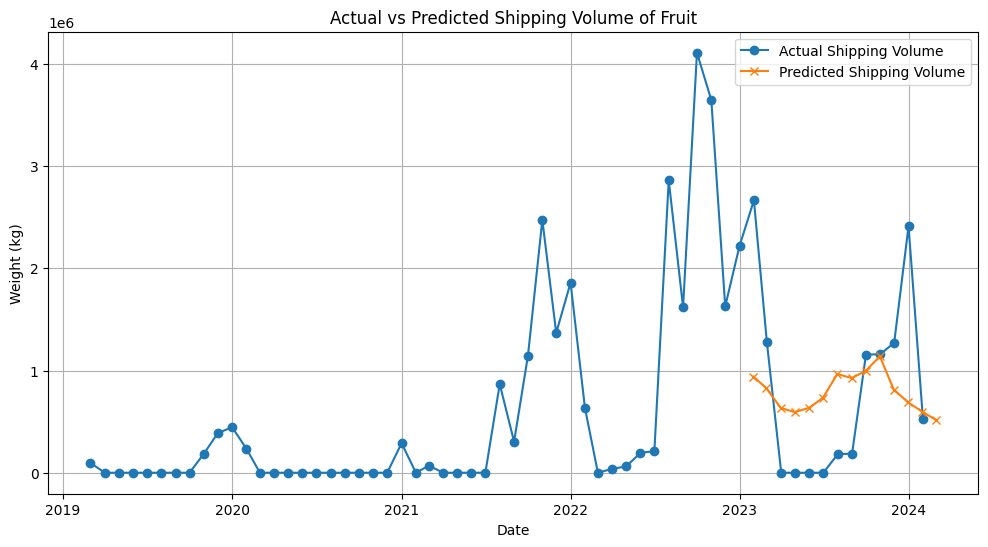

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the original dataset
data_file_path = 'monthlydata.csv'  # Replace with your actual file path
data = pd.read_csv(data_file_path)
data['YearMonth'] = pd.to_datetime(data['YearMonth'])
data.set_index('YearMonth', inplace=True)

# Manually creating the predictions DataFrame based on the provided data
predictions_data = {
    "ds": ["2023-01-31", "2023-02-28", "2023-03-31", "2023-04-30", "2023-05-31",
           "2023-06-30", "2023-07-31", "2023-08-31", "2023-09-30", "2023-10-31",
           "2023-11-30", "2023-12-31", "2024-01-31", "2024-02-29"],
    "Weight__kg_": [941438.25, 825757.25, 633986.875, 593468.3125, 634636.6875,
                     732336.75, 965867.06, 926885.12, 995145.06, 1139068.25,
                    813973.31, 688634.25,  596397.62,  516755.031]
}

predictions = pd.DataFrame(predictions_data)
predictions['ds'] = pd.to_datetime(predictions['ds'])
predictions.set_index('ds', inplace=True)

# Plotting the actual and predicted shipping volumes
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Weight__kg_'], label='Actual Shipping Volume', marker='o')
plt.plot(predictions.index, predictions['Weight__kg_'], label='Predicted Shipping Volume', marker='x')
plt.title('Actual vs Predicted Shipping Volume of Fruit')
plt.xlabel('Date')
plt.ylabel('Weight (kg)')
plt.legend()
plt.grid(True)
plt.show()


## Ensemble

In [ ]:
# Disable scientific notation for display
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# File paths
arima_file = 'arima_rolling.csv'
lstm_file = 'lstm_rolling.csv'
nbeats_file = 'nbeats_all_predictions.csv'
sarima_file = 'sarima_rolling.csv'
shift_file = 'shift_method.csv'
prophet_file='prophet_rolling_predictions.csv'

# Load data
arima_df = pd.read_csv(arima_file)
lstm_df = pd.read_csv(lstm_file)
sarima_df = pd.read_csv(sarima_file)
shift_df = pd.read_csv(shift_file)
nbeats_df = pd.read_csv(nbeats_file)
prophet_df = pd.read_csv(prophet_file)

# Display the first few rows of each DataFrame
arima_df.head(), lstm_df.head(), shift_df.head(), sarima_df.head(), nbeats_df.head(), prophet_df.head()

(        Date  Weight  Predicted
 0   2019/9/1       0      0.000
 1  2019/10/1       0  29633.801
 2  2019/11/1  185232      0.000
 3  2019/12/1  387226 155406.154
 4   2020/1/1  445992 331899.815,
    Unnamed: 0        Date     Actual  Predicted
 0           0  2019-09-01      0.000 118054.039
 1           1  2019-10-01      0.000 101327.344
 2           2  2019-11-01 185232.000 101327.344
 3           3  2019-12-01 387226.000 168555.234
 4           4  2020-01-01 445992.000 330250.469,
         Date  Weight  Shifted  Predicted  rolling_Predicted
 0   2019/9/1       0        0          0                NaN
 1  2019/10/1       0        0          0                NaN
 2  2019/11/1  185232        0          0                NaN
 3  2019/12/1  387226   185232     185232                NaN
 4   2020/1/1  445992   387226     387226                NaN,
    Unnamed: 0       Date  Weight  LogWeight  Predicted  rolling_Predicted
 0           6   2019/9/1       0      0.000      0.000         

In [ ]:
# Ensure each DataFrame has the correct columns and data types
arima_df.columns = ['Date', 'Actual','ARIMA']

# Convert 'Date' columns to datetime format if necessary
arima_df['Date'] = pd.to_datetime(arima_df['Date'])


In [ ]:
# Add new columns to the ARIMA DataFrame
arima_df['LSTM'] = lstm_df['Predicted']
arima_df['SARIMA'] = sarima_df['Predicted']
arima_df['NBEATS'] = nbeats_df['Predicted']
arima_df['SHIFT'] = shift_df['Predicted']
arima_df['PROPHET'] = prophet_df['Predicted_Weight_kg']
arima_df

,Date,Actual,ARIMA,LSTM,SARIMA,NBEATS,SHIFT,PROPHET
0,2019-09-01,0,0.000,118054.039,0.000,46.868,0,0.000
1,2019-10-01,0,29633.801,101327.344,0.000,46.868,0,731973.777
2,2019-11-01,185232,0.000,101327.344,0.000,46.868,0,1133179.442
3,2019-12-01,387226,155406.154,168555.234,1613.077,100983.619,185232,81696.751
4,2020-01-01,445992,331899.815,330250.469,290228.717,488111.205,387226,416110.760
5,2020-02-01,234586,529369.867,508346.438,422019.925,651353.391,445992,0.000
6,2020-03-01,0,289038.966,423288.625,301583.158,64567.410,234586,0.000
7,2020-04-01,0,63643.523,127813.266,124.866,8194.186,0,0.000
8,2020-05-01,0,0.000,0.000,0.000,21138.541,0,0.000
9,2020-06-01,0,4331.417,37428.785,0.000,34639.052,0,0.000


In [ ]:
arima_df.to_csv('ensemble.csv')

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='neg_mean_absolute_error')

Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


RandomForestRegressor(n_estimators=50, random_state=42)

RandomForestRegressor(n_estimators=50, random_state=42)

RandomForestRegressor(n_estimators=50, random_state=42)

RandomForestRegressor(n_estimators=50, random_state=42)

RandomForestRegressor(n_estimators=50, random_state=42)

RandomForestRegressor(n_estimators=50, random_state=42)

RandomForestRegressor(n_estimators=50, random_state=42)

RandomForestRegressor(n_estimators=50, random_state=42)

RandomForestRegressor(n_estimators=50, random_state=42)

RandomForestRegressor(n_estimators=50, random_state=42)

RandomForestRegressor(n_estimators=50, random_state=42)

RandomForestRegressor(n_estimators=50, random_state=42)

RandomForestRegressor(n_estimators=50, random_state=42)

RandomForestRegressor(n_estimators=50, random_state=42)

RandomForestRegressor(n_estimators=50, random_state=42)

Out-of-sample RMSE: 781539.7187343921
Out-of-sample MAE: 560223.3342857143
In-sample RMSE: 195361.09582699416
In-sample MAE: 96898.07485714286


<Figure size 1400x700 with 0 Axes>

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Weight (kg)')

Text(0.5, 1.0, 'Ensemble Rolling Forecast with In-Sample Predictions')

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48],
 [Text(0, 0, '2020-02-01'),
  Text(1, 0, '2020-03-01'),
  Text(2, 0, '2020-04-01'),
  Text(3, 0, '2020-05-01'),
  Text(4, 0, '2020-06-01'),
  Text(5, 0, '2020-07-01'),
  Text(6, 0, '2020-08-01'),
  Text(7, 0, '2020-09-01'),
  Text(8, 0, '2020-10-01'),
  Text(9, 0, '2020-11-01'),
  Text(10, 0, '2020-12-01'),
  Text(11, 0, '2021-01-01'),
  Text(12, 0, '2021-02-01'),
  Text(13, 0, '2021-03-01'),
  Text(14, 0, '2021-04-01'),
  Text(15, 0, '2021-05-01'),
  Text(16, 0, '2021-06-01'),
  Text(17, 0, '2021-07-01'),
  Text(18, 0, '2021-08-01'),
  Text(19, 0, '2021-09-01'),
  Text(20, 0, '2021-10-01'),
  Text(21, 0, '2021-11-01'),
  Text(22, 0, '2021-12-01'),
  Text(23, 0, '2022-01-01'),
  Text(24, 0, '2022-02-01'),


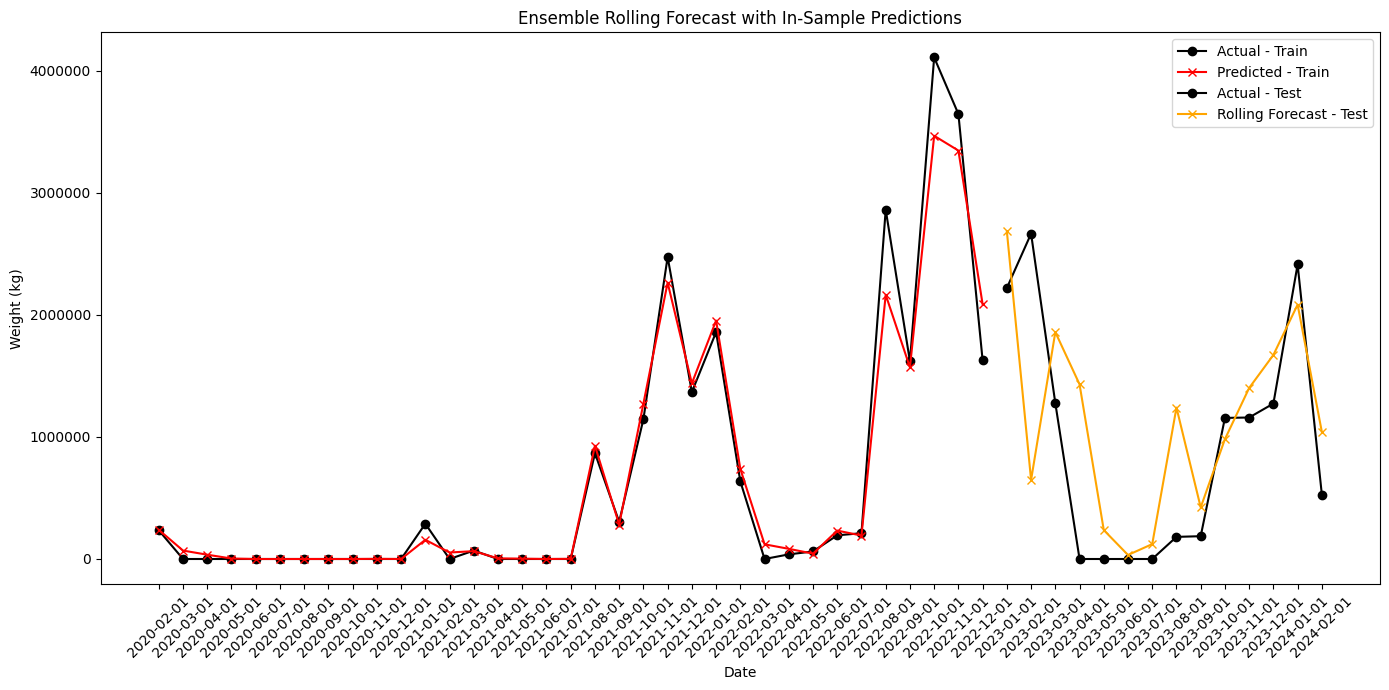

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'ensemble.csv'
data = pd.read_csv(file_path)

# Create lag features and moving averages
data['lag_1'] = data['Actual'].shift(1)
data['lag_2'] = data['Actual'].shift(2)
data['lag_3'] = data['Actual'].shift(3)
data['moving_avg_3'] = data['Actual'].rolling(window=3).mean()
data['moving_avg_6'] = data['Actual'].rolling(window=6).mean()

# Drop any rows with NaN values created by lagging
data = data.dropna()

# Split the data into training and testing sets
train_df = data[data['Date'] < '2023-01-01']
test_df = data[data['Date'] >= '2023-01-01']

# Prepare the feature matrix and target vector
features = ['ARIMA', 'NBEATS', 'SARIMA', 'LSTM', 'SHIFT', 'PROPHET', 'lag_1', 'lag_2', 'lag_3', 'moving_avg_3', 'moving_avg_6']
X_train = train_df[features]
y_train = train_df['Actual']
X_test = test_df[features]
y_test = test_df['Actual']

# Initialize model
ensemble_model = RandomForestRegressor(random_state=42)

# Define hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform Grid Search
grid_search = GridSearchCV(estimator=ensemble_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f'Best parameters found: {best_params}')

# Train the model with the best parameters
best_ensemble_model = RandomForestRegressor(**best_params, random_state=42)
best_ensemble_model.fit(X_train, y_train)

# In-sample predictions
y_train_pred = best_ensemble_model.predict(X_train)

# Initialize list to store rolling predictions
rolling_predictions = []

# Perform rolling forecast
for i in range(len(X_test)):
    X = pd.concat([X_train, X_test.iloc[:i]], axis=0)
    y = pd.concat([y_train, y_test.iloc[:i]], axis=0)

    best_ensemble_model.fit(X, y)

    next_pred = best_ensemble_model.predict(X_test.iloc[[i]])
    rolling_predictions.append(next_pred[0])

# Compute error metrics for out-of-sample predictions
rmse_test = np.sqrt(mean_squared_error(y_test, rolling_predictions))
mae_test = mean_absolute_error(y_test, rolling_predictions)

# Compute error metrics for in-sample predictions
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
mae_train = mean_absolute_error(y_train, y_train_pred)

# Print the error metrics
print(f'Out-of-sample RMSE: {rmse_test}')
print(f'Out-of-sample MAE: {mae_test}')
print(f'In-sample RMSE: {rmse_train}')
print(f'In-sample MAE: {mae_train}')

# Plot the actual vs rolling forecast predictions
plt.figure(figsize=(14, 7))
plt.plot(train_df['Date'], y_train, label='Actual - Train', color='black', marker='o', linestyle='-')
plt.plot(train_df['Date'], y_train_pred, label='Predicted - Train', color='red', linestyle='-', marker='x')
plt.plot(test_df['Date'], y_test, label='Actual - Test', color='black', marker='o', linestyle='-')
plt.plot(test_df['Date'], rolling_predictions, label='Rolling Forecast - Test', color='orange', linestyle='-', marker='x')
plt.xlabel('Date')
plt.ylabel('Weight (kg)')
plt.title('Ensemble Rolling Forecast with In-Sample Predictions')
plt.legend()
plt.ticklabel_format(style='plain', axis='y')

# Improve date formatting
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='neg_mean_absolute_error')

Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


RandomForestRegressor(n_estimators=50, random_state=42)

RandomForestRegressor(n_estimators=50, random_state=42)

RandomForestRegressor(n_estimators=50, random_state=42)

RandomForestRegressor(n_estimators=50, random_state=42)

RandomForestRegressor(n_estimators=50, random_state=42)

RandomForestRegressor(n_estimators=50, random_state=42)

RandomForestRegressor(n_estimators=50, random_state=42)

RandomForestRegressor(n_estimators=50, random_state=42)

RandomForestRegressor(n_estimators=50, random_state=42)

RandomForestRegressor(n_estimators=50, random_state=42)

RandomForestRegressor(n_estimators=50, random_state=42)

RandomForestRegressor(n_estimators=50, random_state=42)

RandomForestRegressor(n_estimators=50, random_state=42)

RandomForestRegressor(n_estimators=50, random_state=42)

RandomForestRegressor(n_estimators=50, random_state=42)

Out-of-sample RMSE: 781539.7187343921
Out-of-sample MAE: 560223.3342857143
In-sample RMSE: 195361.09582699416
In-sample MAE: 96898.07485714286


<Figure size 1400x700 with 0 Axes>

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Weight (kg)')

Text(0.5, 1.0, 'Ensemble Rolling Forecast with In-Sample Predictions')

(array([17897., 18262., 18628., 18993., 19358., 19723.]),
 [Text(17897.0, 0, '2019'),
  Text(18262.0, 0, '2020'),
  Text(18628.0, 0, '2021'),
  Text(18993.0, 0, '2022'),
  Text(19358.0, 0, '2023'),
  Text(19723.0, 0, '2024')])

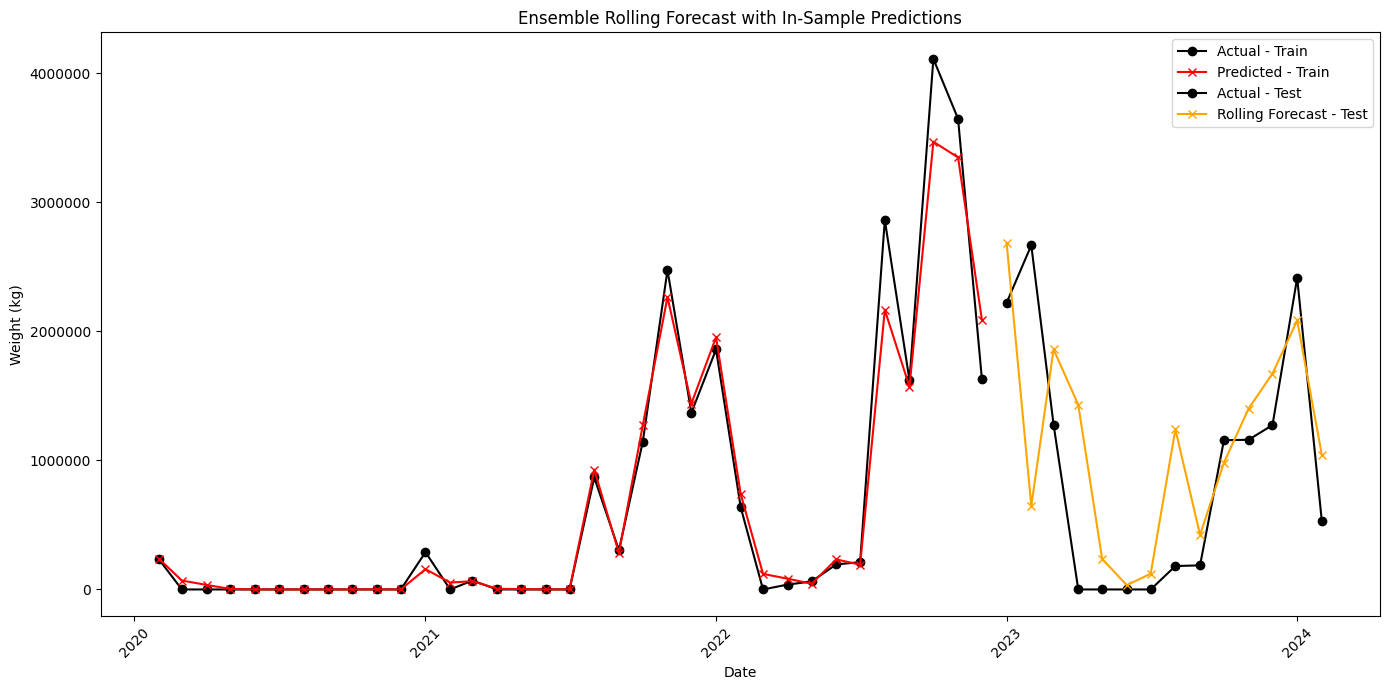

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'ensemble.csv'
data = pd.read_csv(file_path)

# Convert the Date column to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Create lag features and moving averages
data['lag_1'] = data['Actual'].shift(1)
data['lag_2'] = data['Actual'].shift(2)
data['lag_3'] = data['Actual'].shift(3)
data['moving_avg_3'] = data['Actual'].rolling(window=3).mean()
data['moving_avg_6'] = data['Actual'].rolling(window=6).mean()

# Drop any rows with NaN values created by lagging
data = data.dropna()

# Split the data into training and testing sets
train_df = data[data['Date'] < '2023-01-01']
test_df = data[data['Date'] >= '2023-01-01']

# Prepare the feature matrix and target vector
features = ['ARIMA', 'NBEATS', 'SARIMA', 'LSTM', 'SHIFT', 'PROPHET', 'lag_1', 'lag_2', 'lag_3', 'moving_avg_3', 'moving_avg_6']
X_train = train_df[features]
y_train = train_df['Actual']
X_test = test_df[features]
y_test = test_df['Actual']

# Initialize model
ensemble_model = RandomForestRegressor(random_state=42)

# Define hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform Grid Search
grid_search = GridSearchCV(estimator=ensemble_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f'Best parameters found: {best_params}')

# Train the model with the best parameters
best_ensemble_model = RandomForestRegressor(**best_params, random_state=42)
best_ensemble_model.fit(X_train, y_train)

# In-sample predictions
y_train_pred = best_ensemble_model.predict(X_train)

# Initialize list to store rolling predictions
rolling_predictions = []

# Perform rolling forecast
for i in range(len(X_test)):
    X = pd.concat([X_train, X_test.iloc[:i]], axis=0)
    y = pd.concat([y_train, y_test.iloc[:i]], axis=0)

    best_ensemble_model.fit(X, y)

    next_pred = best_ensemble_model.predict(X_test.iloc[[i]])
    rolling_predictions.append(next_pred[0])

# Compute error metrics for out-of-sample predictions
rmse_test = np.sqrt(mean_squared_error(y_test, rolling_predictions))
mae_test = mean_absolute_error(y_test, rolling_predictions)

# Compute error metrics for in-sample predictions
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
mae_train = mean_absolute_error(y_train, y_train_pred)

# Print the error metrics
print(f'Out-of-sample RMSE: {rmse_test}')
print(f'Out-of-sample MAE: {mae_test}')
print(f'In-sample RMSE: {rmse_train}')
print(f'In-sample MAE: {mae_train}')

# Plot the actual vs rolling forecast predictions
plt.figure(figsize=(14, 7))
plt.plot(train_df['Date'], y_train, label='Actual - Train', color='black', marker='o', linestyle='-')
plt.plot(train_df['Date'], y_train_pred, label='Predicted - Train', color='red', linestyle='-', marker='x')
plt.plot(test_df['Date'], y_test, label='Actual - Test', color='black', marker='o', linestyle='-')
plt.plot(test_df['Date'], rolling_predictions, label='Rolling Forecast - Test', color='orange', linestyle='-', marker='x')
plt.xlabel('Date')
plt.ylabel('Weight (kg)')
plt.title('Ensemble Rolling Forecast with In-Sample Predictions')
plt.legend()
plt.grid(False)  # Remove granular grid

# Set x-axis to show only the year
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.YearLocator())
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))

plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:

# Save the in-sample and rolling forecast predictions into a dataframe
results_df = pd.DataFrame({
    'Date': pd.concat([train_df['Date'], test_df['Date']]),
    'Actual': pd.concat([y_train, y_test]),
    'Prediction': np.concatenate([y_train_pred, rolling_predictions])
})

# Display the dataframe to the user
results_df

,Date,Actual,Prediction
5,2020-02-01,234586,238747.700
6,2020-03-01,0,69022.380
7,2020-04-01,0,35155.460
8,2020-05-01,0,3881.800
9,2020-06-01,0,0.000
10,2020-07-01,0,0.000
11,2020-08-01,0,0.000
12,2020-09-01,0,0.000
13,2020-10-01,0,0.000
14,2020-11-01,0,1239.120


In [ ]:
results_df.to_csv("ensemble_rolling.csv")

Feature importance has been saved to feature_importance.csv.


,Feature,Importance
9,moving_avg_3,0.338
1,NBEATS,0.253
3,LSTM,0.188
5,PROPHET,0.133
8,lag_3,0.025
0,ARIMA,0.024
4,SHIFT,0.013
2,SARIMA,0.012
10,moving_avg_6,0.006
6,lag_1,0.006


<Figure size 1000x600 with 0 Axes>

<BarContainer object of 11 artists>

Text(0.5, 0, 'Importance')

Text(0, 0.5, 'Feature')

Text(0.5, 1.0, 'Feature Importance')

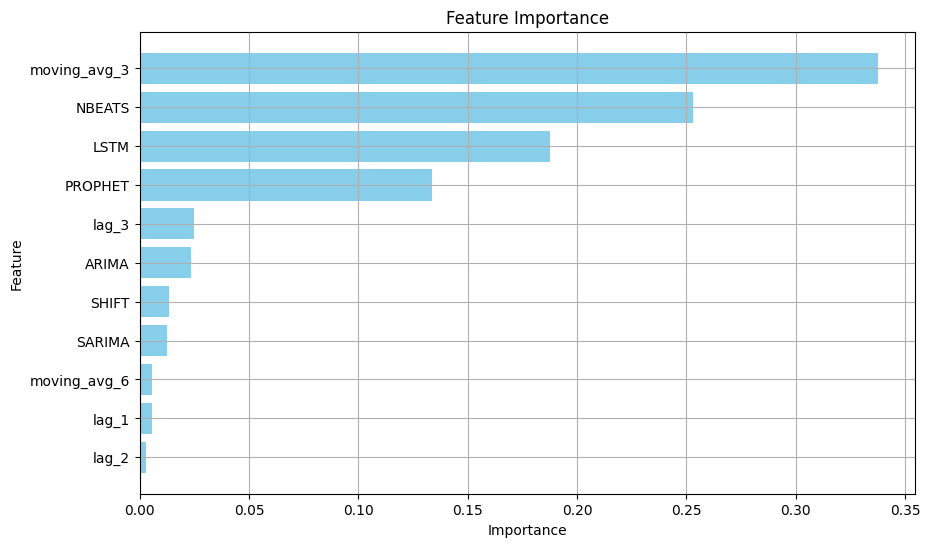

In [ ]:
# Evaluate feature importance
feature_importances = best_ensemble_model.feature_importances_

# Create a DataFrame to display the feature importances
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Save the feature importance dataframe to a CSV file
importance_df.to_csv('feature_importance.csv', index=False)
print("Feature importance has been saved to feature_importance.csv.")
importance_df

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.grid(True)
plt.show()


# Directional Accuracy Evaluation

In [ ]:
#
# Re-load the data for clarity and consistency
file_path = 'monthlydata.csv'
data = pd.read_csv(file_path)

# Convert the 'YearMonth' column to datetime
data['YearMonth'] = pd.to_datetime(data['YearMonth'])

# Set 'YearMonth' as the index
data.set_index('YearMonth', inplace=True)

# Compute the difference between consecutive actual values
data['Difference'] = data['Weight__kg_'].diff()

# Determine the direction of changes: increase, decrease, or unchanged
data['Direction'] = data['Difference'].apply(lambda x: 'Increase' if x > 0 else ('Decrease' if x < 0 else 'Unchanged'))


<Figure size 1000x600 with 0 Axes>

Text(0.0, 23.5, '23')

Text(1.0, 22.5, '22')

Text(2.0, 15.5, '15')

(0.0, 28.0)

Text(0.5, 1.0, 'Counts of Directional Changes')

Text(0.5, 0, 'Direction')

Text(0, 0.5, 'Count')

([0, 1, 2],
 [Text(0, 0, 'Increase'), Text(1, 0, 'Unchanged'), Text(2, 0, 'Decrease')])

(array([ 0.,  5., 10., 15., 20., 25., 30.]),
 [Text(0, 0.0, '0'),
  Text(0, 5.0, '5'),
  Text(0, 10.0, '10'),
  Text(0, 15.0, '15'),
  Text(0, 20.0, '20'),
  Text(0, 25.0, '25'),
  Text(0, 30.0, '30')])

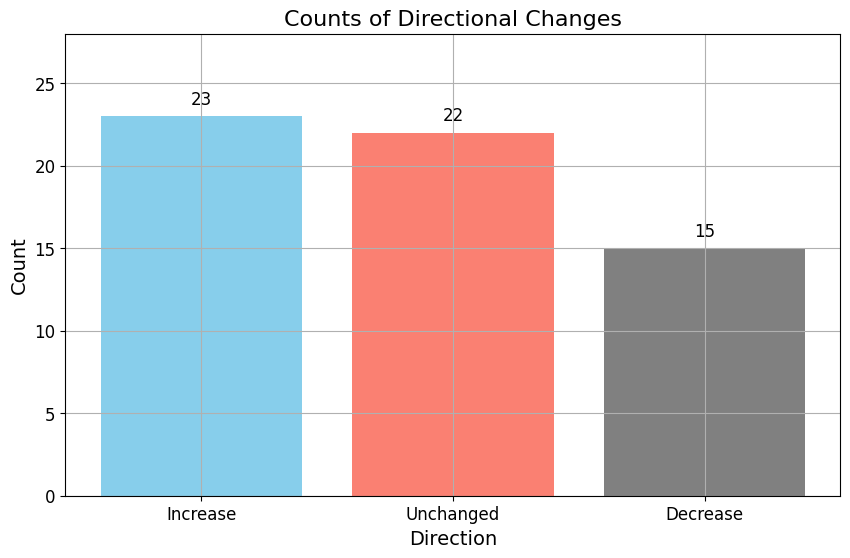

In [ ]:
# Compute the counts for each direction
direction_counts = data['Direction'].value_counts()

# Create a DataFrame for visualization
direction_counts_df = pd.DataFrame({
    'Direction': direction_counts.index,
    'Count': direction_counts.values
})

# Compute the counts for each direction
direction_counts = data['Direction'].value_counts()

# Create a DataFrame for visualization
direction_counts_df = pd.DataFrame({
    'Direction': direction_counts.index,
    'Count': direction_counts.values
})
# Adjust the plot size and y-axis to make it more readable
plt.figure(figsize=(10, 6))
bars = plt.bar(direction_counts_df['Direction'], direction_counts_df['Count'], color=['skyblue', 'salmon', 'gray'])

# Add text annotations to display the counts on each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, int(yval), ha='center', va='bottom', fontsize=12)

# Set y-axis limits for better readability
plt.ylim(0, max(direction_counts_df['Count']) + 5)

plt.title('Counts of Directional Changes', fontsize=16)
plt.xlabel('Direction', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.show()


<Figure size 1000x800 with 0 Axes>

Text(0.0, 23.5, '23')

Text(1.0, 22.5, '22')

Text(2.0, 15.5, '15')

Text(0.5, 1.0, 'Counts of Directional Changes')

Text(0.5, 0, 'Direction')

Text(0, 0.5, 'Count')

([0, 1, 2],
 [Text(0, 0, 'Increase'), Text(1, 0, 'Unchanged'), Text(2, 0, 'Decrease')])

(array([ 0.,  5., 10., 15., 20., 25.]),
 [Text(0, 0.0, '0'),
  Text(0, 5.0, '5'),
  Text(0, 10.0, '10'),
  Text(0, 15.0, '15'),
  Text(0, 20.0, '20'),
  Text(0, 25.0, '25')])

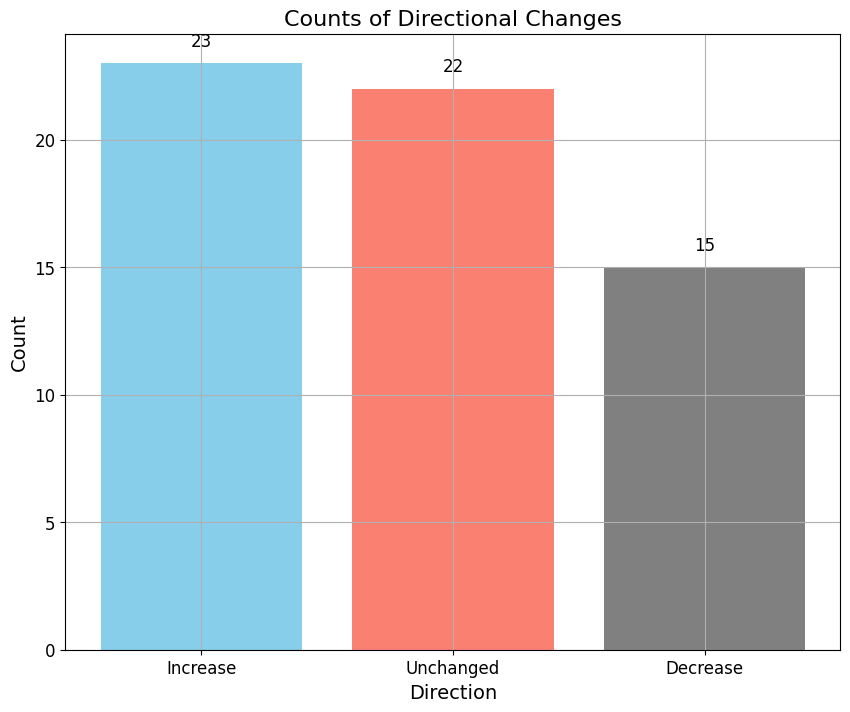

In [ ]:
# Compute the counts for each direction
direction_counts = data['Direction'].value_counts()

# Create a DataFrame for visualization
direction_counts_df = pd.DataFrame({
    'Direction': direction_counts.index,
    'Count': direction_counts.values
})

import matplotlib.pyplot as plt

# Adjust the plot size to make it more readable
plt.figure(figsize=(10, 8))
bars = plt.bar(direction_counts_df['Direction'], direction_counts_df['Count'], color=['skyblue', 'salmon', 'gray'])

# Add text annotations to display the counts on each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, int(yval), ha='center', va='bottom', fontsize=12)

plt.title('Counts of Directional Changes', fontsize=16)
plt.xlabel('Direction', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load the data from the uploaded CSV file
file_path = 'ensemble.csv'
data = pd.read_csv(file_path)

# Remove the Unnamed: 0 column and convert the Date column to datetime format
data_cleaned = data.drop(columns=['Unnamed: 0'])

# Filter the data to only keep rows starting from 2023
data_filtered = data_cleaned[data_cleaned['Date'] >= '2023-01-01']

ensemble = pd.read_csv('ensemble_rolling.csv')
ensemble = ensemble.drop(columns=['Unnamed: 0'])
ensemble_filtered = ensemble[ensemble['Date'] >= '2023-01-01']

In [ ]:
df_merged = data_filtered.merge(ensemble_filtered[['Date', 'Prediction']], on='Date', how='left')
df_merged.rename(columns={'Prediction': 'ENSEMBLE'}, inplace=True)
df_merged.to_csv('merged.csv')
df_merged

,Date,Actual,ARIMA,LSTM,SARIMA,NBEATS,SHIFT,PROPHET,ENSEMBLE
0,2023-01-01,2220878,3958451.306,1682587.375,2231404.219,348502.480,1627818,2965307.671,2685560.020
1,2023-02-01,2666227,377758.017,1496807.125,280923.752,639736.299,2220878,0.000,647249.720
2,2023-03-01,1277384,2970973.020,1375434.625,372466.044,669727.475,2666227,747689.257,1859566.360
3,2023-04-01,0,2030906.374,1161195.010,292131.262,200791.268,1277384,467786.476,1431480.880
4,2023-05-01,0,466632.663,0.000,216.835,68180.813,0,847802.960,237048.380
5,2023-06-01,0,0.000,83477.295,0.000,123917.628,0,322766.074,32891.640
6,2023-07-01,0,0.000,0.000,0.000,188597.169,0,792862.555,122120.120
7,2023-08-01,181340,27876.134,401449.484,441.131,46.868,0,2391319.937,1240904.640
8,2023-09-01,186794,128942.997,534853.105,24253.767,98861.947,181340,1216325.897,423163.680
9,2023-10-01,1156219,185637.250,314813.421,26257.596,391755.089,186794,2711392.027,982160.120


In [ ]:
file_path = 'merged.csv'
data = pd.read_csv(file_path)
timesfm =pd.read_csv('timesfm_rolling.csv')
data['TIMESFM']= timesfm['timesfm']
data

,Unnamed: 0,Date,Actual,ARIMA,LSTM,SARIMA,NBEATS,SHIFT,PROPHET,ENSEMBLE,TIMESFM
0,0,2023-01-01,2220878,3958451.306,1682587.375,2231404.219,348502.480,1627818,2965307.671,2685560.020,941438.250
1,1,2023-02-01,2666227,377758.017,1496807.125,280923.752,639736.299,2220878,0.000,647249.720,825757.250
2,2,2023-03-01,1277384,2970973.020,1375434.625,372466.044,669727.475,2666227,747689.257,1859566.360,633986.900
3,3,2023-04-01,0,2030906.374,1161195.010,292131.262,200791.268,1277384,467786.476,1431480.880,593468.300
4,4,2023-05-01,0,466632.663,0.000,216.835,68180.813,0,847802.960,237048.380,634636.700
5,5,2023-06-01,0,0.000,83477.295,0.000,123917.628,0,322766.074,32891.640,732336.750
6,6,2023-07-01,0,0.000,0.000,0.000,188597.169,0,792862.555,122120.120,965867.060
7,7,2023-08-01,181340,27876.134,401449.484,441.131,46.868,0,2391319.937,1240904.640,926885.100
8,8,2023-09-01,186794,128942.997,534853.105,24253.767,98861.947,181340,1216325.897,423163.680,995145.060
9,9,2023-10-01,1156219,185637.250,314813.421,26257.596,391755.089,186794,2711392.027,982160.120,1139068.200


In [ ]:
import pandas as pd
from sklearn.metrics import balanced_accuracy_score, f1_score


# Define the model columns
model_columns = ['ARIMA', 'LSTM', 'SARIMA', 'NBEATS', 'SHIFT', 'PROPHET', 'ENSEMBLE','TIMESFM']

# Function to determine directional changes
def directional_changes(series):
    differences = series.diff()
    changes = differences.apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
    return changes

# Calculate actual directional changes
data['Actual_Diff'] = data['Actual'].diff()
data['Actual_Change'] = directional_changes(data['Actual'])

# Initialize dictionary to store results
metric_results = {}

# Compute directional changes and metrics for each model
for model in model_columns:
    # Calculate directional changes for the model's predictions
    data[f'{model}_Change'] = directional_changes(data[model])

    # Calculate Balanced Accuracy and Macro F1-Score
    model_balanced_accuracy = balanced_accuracy_score(data['Actual_Change'], data[f'{model}_Change'])
    model_f1_score = f1_score(data['Actual_Change'], data[f'{model}_Change'], average='macro')

    # Store the results
    metric_results[model] = {
        'Balanced Accuracy': model_balanced_accuracy,
        'Macro F1-Score': model_f1_score
    }

# Display the results
print(metric_results)


{'ARIMA': {'Balanced Accuracy': 0.5634920634920634, 'Macro F1-Score': 0.5841269841269842}, 'LSTM': {'Balanced Accuracy': 0.6547619047619048, 'Macro F1-Score': 0.5897435897435898}, 'SARIMA': {'Balanced Accuracy': 0.5634920634920634, 'Macro F1-Score': 0.5841269841269842}, 'NBEATS': {'Balanced Accuracy': 0.4325396825396825, 'Macro F1-Score': 0.43690476190476196}, 'SHIFT': {'Balanced Accuracy': 0.6468253968253967, 'Macro F1-Score': 0.6499999999999999}, 'PROPHET': {'Balanced Accuracy': 0.4484126984126984, 'Macro F1-Score': 0.4205128205128205}, 'ENSEMBLE': {'Balanced Accuracy': 0.5436507936507936, 'Macro F1-Score': 0.5195767195767196}, 'TIMESFM': {'Balanced Accuracy': 0.5119047619047619, 'Macro F1-Score': 0.4262626262626263}}


# Model Comparison

<BarContainer object of 8 artists>

Text(0.5, 1.0, 'Out-of-Sample RMSE of Models (Ranked)')

Text(0.5, 0, 'Model')

Text(0, 0.5, 'RMSE (in thousands)')

<ipython-input-10-c22ceea0c27e>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels([f'{int(x/1000)}' for x in ax[0].get_yticks()], fontsize=10)


[Text(0, 0.0, '0'),
 Text(0, 200000.0, '200'),
 Text(0, 400000.0, '400'),
 Text(0, 600000.0, '600'),
 Text(0, 800000.0, '800'),
 Text(0, 1000000.0, '1000'),
 Text(0, 1200000.0, '1200'),
 Text(0, 1400000.0, '1400')]

(0.0, 1400000.0)

Text(0, 615914, '565')

Text(1, 831539, '781')

Text(2, 893123, '843')

Text(3, 990131, '940')

Text(4, 1000033, '950')

Text(5, 1113349, '1063')

Text(6, 1222299, '1172')

Text(7, 1244658, '1194')

<BarContainer object of 8 artists>

Text(0.5, 1.0, 'Out-of-Sample MAE of Models (Ranked)')

Text(0.5, 0, 'Model')

Text(0, 0.5, 'MAE (in thousands)')

<ipython-input-10-c22ceea0c27e>:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels([f'{int(x/1000)}' for x in ax[1].get_yticks()], fontsize=10)


[Text(0, 0.0, '0'),
 Text(0, 200000.0, '200'),
 Text(0, 400000.0, '400'),
 Text(0, 600000.0, '600'),
 Text(0, 800000.0, '800'),
 Text(0, 1000000.0, '1000')]

(0.0, 1400000.0)

Text(0, 481683, '431')

Text(1, 610223, '560')

Text(2, 621714, '571')

Text(3, 723801, '673')

Text(4, 759653, '709')

Text(5, 837104, '787')

Text(6, 929204, '879')

Text(7, 987665, '937')

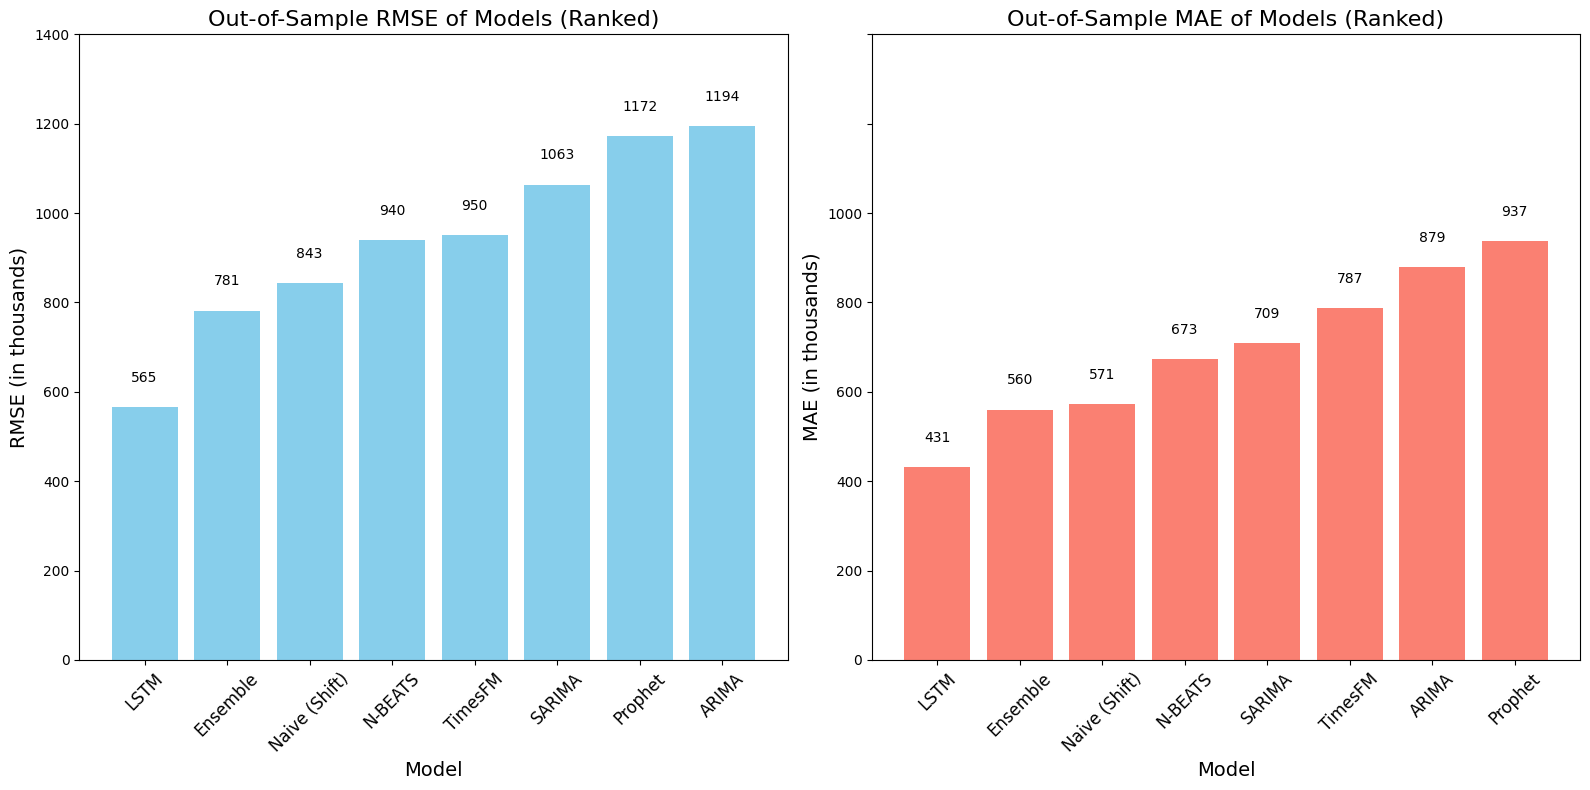

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Data from the provided image
data = {
    "Model": ["Naive (Shift)", "ARIMA", "SARIMA", "Prophet", "LSTM", "N-BEATS", "TimesFM", "Ensemble"],
    "RMSE": [843123, 1194658, 1063349, 1172299, 565914, 940131, 950033, 781539],
    "MAE": [571714, 879204, 709653, 937665, 431683, 673801, 787104, 560223]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Rank the models based on RMSE and MAE
df['RMSE Rank'] = df['RMSE'].rank()
df['MAE Rank'] = df['MAE'].rank()

# Re-order the DataFrame based on RMSE Rank
df_sorted_rmse = df.sort_values(by='RMSE Rank')

# Re-plot the graphs
fig, ax = plt.subplots(1, 2, figsize=(16, 8))  # Increased figure size to make y-axis bigger

# RMSE Bar Plot in ranking order
ax[0].bar(df_sorted_rmse['Model'], df_sorted_rmse['RMSE'], color='skyblue')
ax[0].set_title('Out-of-Sample RMSE of Models (Ranked)', fontsize=16)
ax[0].set_xlabel('Model', fontsize=14)
ax[0].set_ylabel('RMSE (in thousands)', fontsize=14)
ax[0].tick_params(axis='x', rotation=45, labelsize=12)
ax[0].ticklabel_format(style='plain', axis='y')
ax[0].set_yticklabels([f'{int(x/1000)}' for x in ax[0].get_yticks()], fontsize=10)
ax[0].set_ylim(0, 1400000)  # Increase y-axis limit

# Annotate each bar with the RMSE value in thousands
for i, v in enumerate(df_sorted_rmse['RMSE']):
    ax[0].text(i, v + 50000, f'{int(v/1000)}', ha='center', va='bottom', fontsize=10)

# MAE Bar Plot in ranking order
df_sorted_mae = df.sort_values(by='MAE Rank')
ax[1].bar(df_sorted_mae['Model'], df_sorted_mae['MAE'], color='salmon')
ax[1].set_title('Out-of-Sample MAE of Models (Ranked)', fontsize=16)
ax[1].set_xlabel('Model', fontsize=14)
ax[1].set_ylabel('MAE (in thousands)', fontsize=14)
ax[1].tick_params(axis='x', rotation=45, labelsize=12)
ax[1].ticklabel_format(style='plain', axis='y')
ax[1].set_yticklabels([f'{int(x/1000)}' for x in ax[1].get_yticks()], fontsize=10)
ax[1].set_ylim(0, 1400000)  # Increase y-axis limit to match RMSE

# Annotate each bar with the MAE value in thousands
for i, v in enumerate(df_sorted_mae['MAE']):
    ax[1].text(i, v + 50000, f'{int(v/1000)}', ha='center', va='bottom', fontsize=10)

# Adjust layout
plt.tight_layout()

# Display the plots
plt.show()


<BarContainer object of 7 artists>

Text(0.5, 1.0, 'In-Sample RMSE of Models (Ranked)')

Text(0.5, 0, 'Model')

Text(0, 0.5, 'RMSE (in thousands)')

<ipython-input-11-37607618f27a>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels([f'{int(x/1000)}' for x in ax[0].get_yticks()], fontsize=10)


[Text(0, 0.0, '0'),
 Text(0, 100000.0, '100'),
 Text(0, 200000.0, '200'),
 Text(0, 300000.0, '300'),
 Text(0, 400000.0, '400'),
 Text(0, 500000.0, '500'),
 Text(0, 600000.0, '600'),
 Text(0, 700000.0, '700'),
 Text(0, 800000.0, '800'),
 Text(0, 900000.0, '900')]

(0.0, 900000.0)

Text(0, 215361, '195')

Text(1, 459154, '439')

Text(2, 521967, '501')

Text(3, 564135, '544')

Text(4, 570505, '550')

Text(5, 748301, '728')

Text(6, 785406, '765')

<BarContainer object of 7 artists>

Text(0.5, 1.0, 'In-Sample MAE of Models (Ranked)')

Text(0.5, 0, 'Model')

Text(0, 0.5, 'MAE (in thousands)')

<ipython-input-11-37607618f27a>:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels([f'{int(x/1000)}' for x in ax[1].get_yticks()], fontsize=10)


[Text(0, 0.0, '0'),
 Text(0, 50000.0, '50'),
 Text(0, 100000.0, '100'),
 Text(0, 150000.0, '150'),
 Text(0, 200000.0, '200'),
 Text(0, 250000.0, '250'),
 Text(0, 300000.0, '300'),
 Text(0, 350000.0, '350'),
 Text(0, 400000.0, '400'),
 Text(0, 450000.0, '450')]

(0.0, 900000.0)

Text(0, 116898, '96')

Text(1, 176262, '156')

Text(2, 334136, '314')

Text(3, 335235, '315')

Text(4, 357967, '337')

Text(5, 381739, '361')

Text(6, 416471, '396')

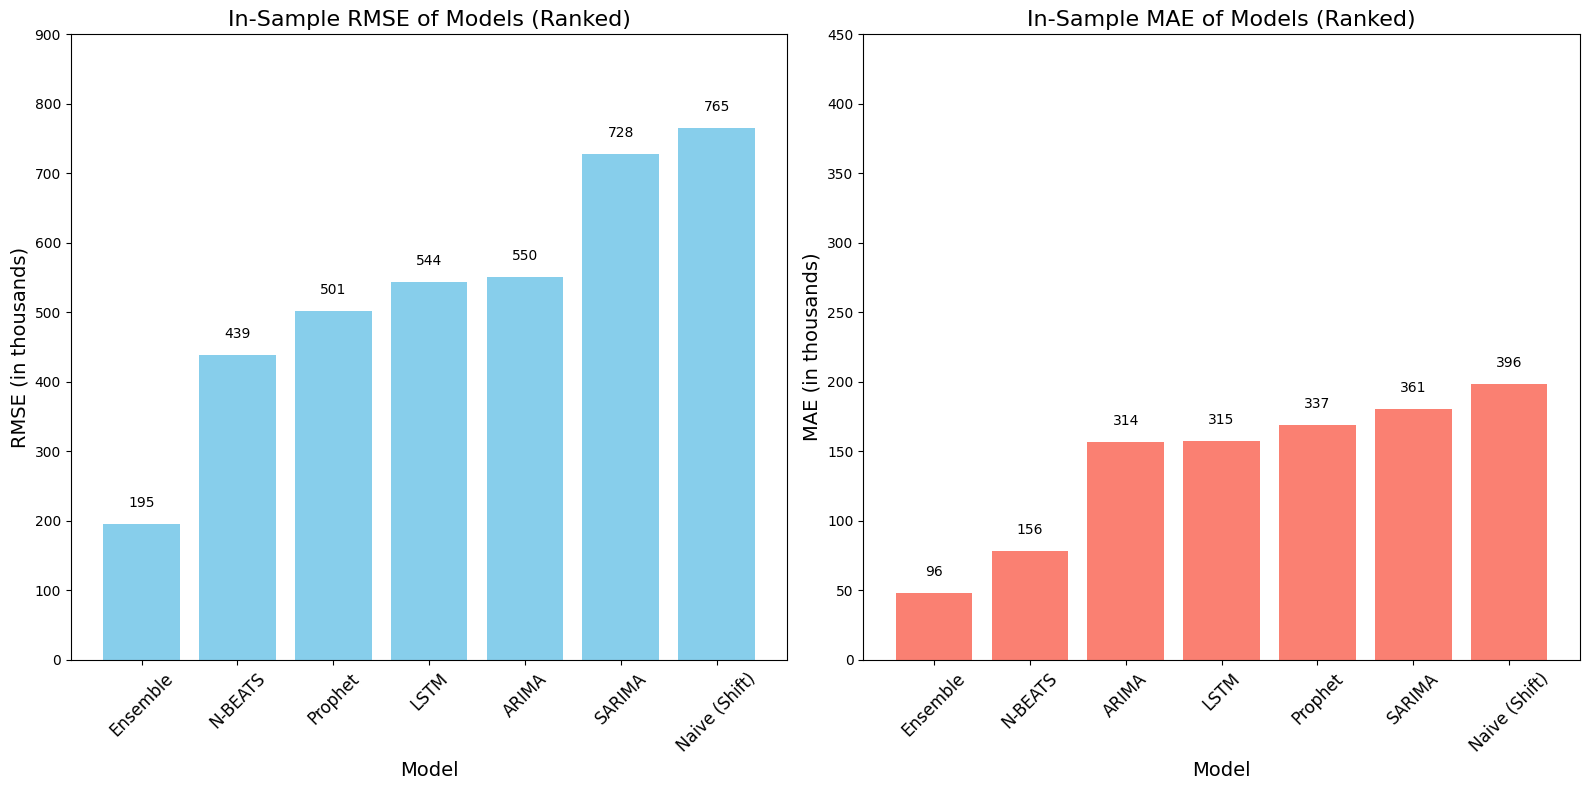

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Data from the new provided image
data_in_sample = {
    "Model": ["Naive (Shift)", "ARIMA", "SARIMA", "Prophet", "LSTM", "N-BEATS", "Ensemble"],
    "RMSE": [765406, 550505, 728301, 501967, 544135, 439154, 195361],
    "MAE": [396471, 314136, 361739, 337967, 315235, 156262, 96898]
}

# Create a DataFrame
df_in_sample = pd.DataFrame(data_in_sample)

# Rank the models based on RMSE and MAE
df_in_sample['RMSE Rank'] = df_in_sample['RMSE'].rank()
df_in_sample['MAE Rank'] = df_in_sample['MAE'].rank()

# Re-order the DataFrame based on RMSE Rank
df_sorted_rmse_in_sample = df_in_sample.sort_values(by='RMSE Rank')
df_sorted_mae_in_sample = df_in_sample.sort_values(by='MAE Rank')

# Plotting RMSE and MAE
fig, ax = plt.subplots(1, 2, figsize=(16, 8))  # Increased figure size to make y-axis bigger

# RMSE Bar Plot in ranking order with adjusted axis
ax[0].bar(df_sorted_rmse_in_sample['Model'], df_sorted_rmse_in_sample['RMSE'], color='skyblue')
ax[0].set_title('In-Sample RMSE of Models (Ranked)', fontsize=16)
ax[0].set_xlabel('Model', fontsize=14)
ax[0].set_ylabel('RMSE (in thousands)', fontsize=14)
ax[0].tick_params(axis='x', rotation=45, labelsize=12)
ax[0].ticklabel_format(style='plain', axis='y')
ax[0].set_yticklabels([f'{int(x/1000)}' for x in ax[0].get_yticks()], fontsize=10)
ax[0].set_ylim(0, 900000)  # Increase y-axis limit

# Annotate each bar with the RMSE value in thousands
for i, v in enumerate(df_sorted_rmse_in_sample['RMSE']):
    ax[0].text(i, v + 20000, f'{int(v/1000)}', ha='center', va='bottom', fontsize=10)

# MAE Bar Plot in ranking order with adjusted axis
ax[1].bar(df_sorted_mae_in_sample['Model'], df_sorted_mae_in_sample['MAE'], color='salmon')
ax[1].set_title('In-Sample MAE of Models (Ranked)', fontsize=16)
ax[1].set_xlabel('Model', fontsize=14)
ax[1].set_ylabel('MAE (in thousands)', fontsize=14)
ax[1].tick_params(axis='x', rotation=45, labelsize=12)
ax[1].ticklabel_format(style='plain', axis='y')
ax[1].set_yticklabels([f'{int(x/1000)}' for x in ax[1].get_yticks()], fontsize=10)
ax[1].set_ylim(0, 900000)  # Increase y-axis limit to match RMSE

# Annotate each bar with the MAE value in thousands
for i, v in enumerate(df_sorted_mae_in_sample['MAE']):
    ax[1].text(i, v + 20000, f'{int(v/1000)}', ha='center', va='bottom', fontsize=10)

# Adjust layout
plt.tight_layout()

# Display the plots
plt.show()


Text(0.5, 0, 'Models')

Text(0, 0.5, 'Scores')

Text(0.5, 1.0, 'Model Performance Sorted by Combined Score')

[Text(0, 0, 'Naive (Shift)'),
 Text(1, 0, 'LSTM'),
 Text(2, 0, 'ARIMA'),
 Text(3, 0, 'SARIMA'),
 Text(4, 0, 'Ensemble'),
 Text(5, 0, 'TimesFM'),
 Text(6, 0, 'N-BEATS'),
 Text(7, 0, 'Prophet')]

[Text(0, 3, '0.647'),
 Text(0, 3, '0.655'),
 Text(0, 3, '0.563'),
 Text(0, 3, '0.563'),
 Text(0, 3, '0.544'),
 Text(0, 3, '0.512'),
 Text(0, 3, '0.433'),
 Text(0, 3, '0.448')]

[Text(0, 3, '0.65'),
 Text(0, 3, '0.59'),
 Text(0, 3, '0.584'),
 Text(0, 3, '0.584'),
 Text(0, 3, '0.52'),
 Text(0, 3, '0.426'),
 Text(0, 3, '0.437'),
 Text(0, 3, '0.421')]

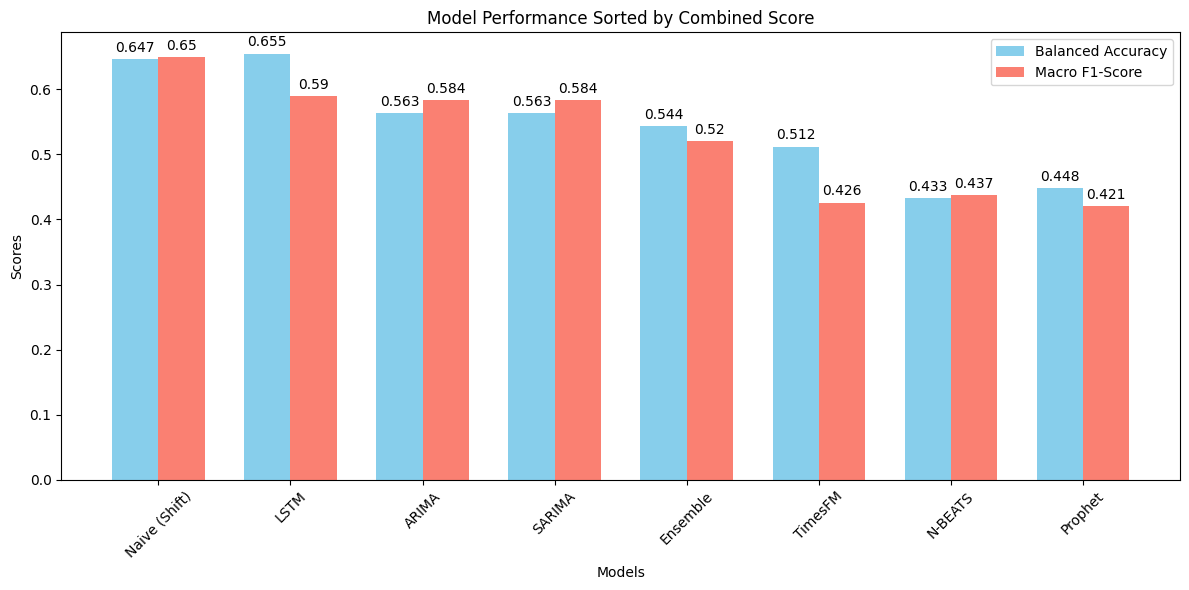

In [ ]:
import matplotlib.pyplot as plt

# Data from the user
models = ['Naive (Shift)', 'ARIMA', 'SARIMA', 'Prophet', 'LSTM', 'N-BEATS', 'TimesFM', 'Ensemble']
balanced_accuracy = [0.647, 0.563, 0.563, 0.448, 0.655, 0.433, 0.512, 0.544]
macro_f1_score = [0.650, 0.584, 0.584, 0.421, 0.590, 0.437, 0.426, 0.520]

# Calculate combined scores and sort the models based on this score
combined_scores = [(ba + f1) / 2 for ba, f1 in zip(balanced_accuracy, macro_f1_score)]
model_scores = sorted(zip(models, balanced_accuracy, macro_f1_score, combined_scores), key=lambda x: x[3], reverse=True)
sorted_models, sorted_balanced_accuracy, sorted_macro_f1_score, _ = zip(*model_scores)

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))
width = 0.35  # Width of the bars
x_sorted = range(len(sorted_models))  # x positions for the sorted models
rects1_sorted = ax.bar([x - width/2 for x in x_sorted], sorted_balanced_accuracy, width, label='Balanced Accuracy', color='skyblue')
rects2_sorted = ax.bar([x + width/2 for x in x_sorted], sorted_macro_f1_score, width, label='Macro F1-Score', color='salmon')

# Add labels and title
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Model Performance Sorted by Combined Score')
ax.set_xticks(x_sorted)
ax.set_xticklabels(sorted_models, rotation=45)
ax.legend()

# Add labels on the bars
ax.bar_label(rects1_sorted, padding=3)
ax.bar_label(rects2_sorted, padding=3)

fig.tight_layout()

plt.show()
